# Self-Driving Car Engineer Nanodegree

## Deep Learning

## Project: Build a Traffic Sign Recognition Classifier

In this notebook, a template is provided for you to implement your functionality in stages which is required to successfully complete this project. If additional code is required that cannot be included in the notebook, be sure that the Python code is successfully imported and included in your submission, if necessary. Sections that begin with **'Implementation'** in the header indicate where you should begin your implementation for your project. Note that some sections of implementation are optional, and will be marked with **'Optional'** in the header.

In addition to implementing code, there will be questions that you must answer which relate to the project and your implementation. Each section where you will answer a question is preceded by a **'Question'** header. Carefully read each question and provide thorough answers in the following text boxes that begin with **'Answer:'**. Your project submission will be evaluated based on your answers to each of the questions and the implementation you provide.

>**Note:** Code and Markdown cells can be executed using the **Shift + Enter** keyboard shortcut. In addition, Markdown cells can be edited by typically double-clicking the cell to enter edit mode.

---

## Step 1: Dataset Exploration

Visualize the German Traffic Signs Dataset. This is open ended, some suggestions include: plotting traffic signs images, plotting the count of each sign, etc. Be creative!


The pickled data is a dictionary with 4 key/value pairs:

- features -> the images pixel values, (width, height, channels)
- labels -> the label of the traffic sign
- sizes -> the original width and height of the image, (width, height)
- coords -> coordinates of a bounding box around the sign in the image, (x1, y1, x2, y2). Based the original image (not the resized version).

In [1]:
## This code will download the train/test zip file and extract it in the current directory 
import os.path
has_train_data = os.path.isfile('train.p') 
if not has_train_data:
    from zipfile import ZipFile
    import urllib.request
    from tempfile import mktemp

    zipurl = 'https://d17h27t6h515a5.cloudfront.net/topher/2016/November/581faac4_traffic-signs-data/traffic-signs-data.zip'
    from urllib.request import urlopen
    from zipfile import ZipFile
    zipresp = urlopen(zipurl)
    tempzip = open("/tmp/tempfile.zip", "wb")
    tempzip.write(zipresp.read())
    tempzip.close()
    zf = ZipFile("/tmp/tempfile.zip")
    zf.extractall()
    zf.close()

In [2]:
## extract the training and testing data
import pickle
training_file = 'train.p'
testing_file = 'test.p'

with open(training_file, mode='rb') as f:
    train = pickle.load(f)
with open(testing_file, mode='rb') as f:
    test = pickle.load(f)
    
X_train, y_train = train['features'], train['labels']
X_test, y_test = test['features'], test['labels']
del train, test # Free up memory

In [3]:
### To start off let's do a basic data summary.

# TODO: number of training examples
n_train = len(X_train)

# TODO: number of testing examples
n_test = len(X_test)

# TODO: what's the shape of an image?
image_shape = X_train[0].shape

# TODO: how many classes are in the dataset
n_classes = len(set(y_train))

print("Number of training examples =", n_train)
print("Number of testing examples =", n_test)
print("Image data shape =", image_shape)
print("Number of classes =", n_classes)

Number of training examples = 39209
Number of testing examples = 12630
Image data shape = (32, 32, 3)
Number of classes = 43


In [4]:
### Data exploration visualization goes here.
### Feel free to use as many code cells as needed.

In [5]:
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

##Imort label names
df = pd.read_csv('signnames.csv')
sign_names = df.set_index('ClassId').to_dict()['SignName']

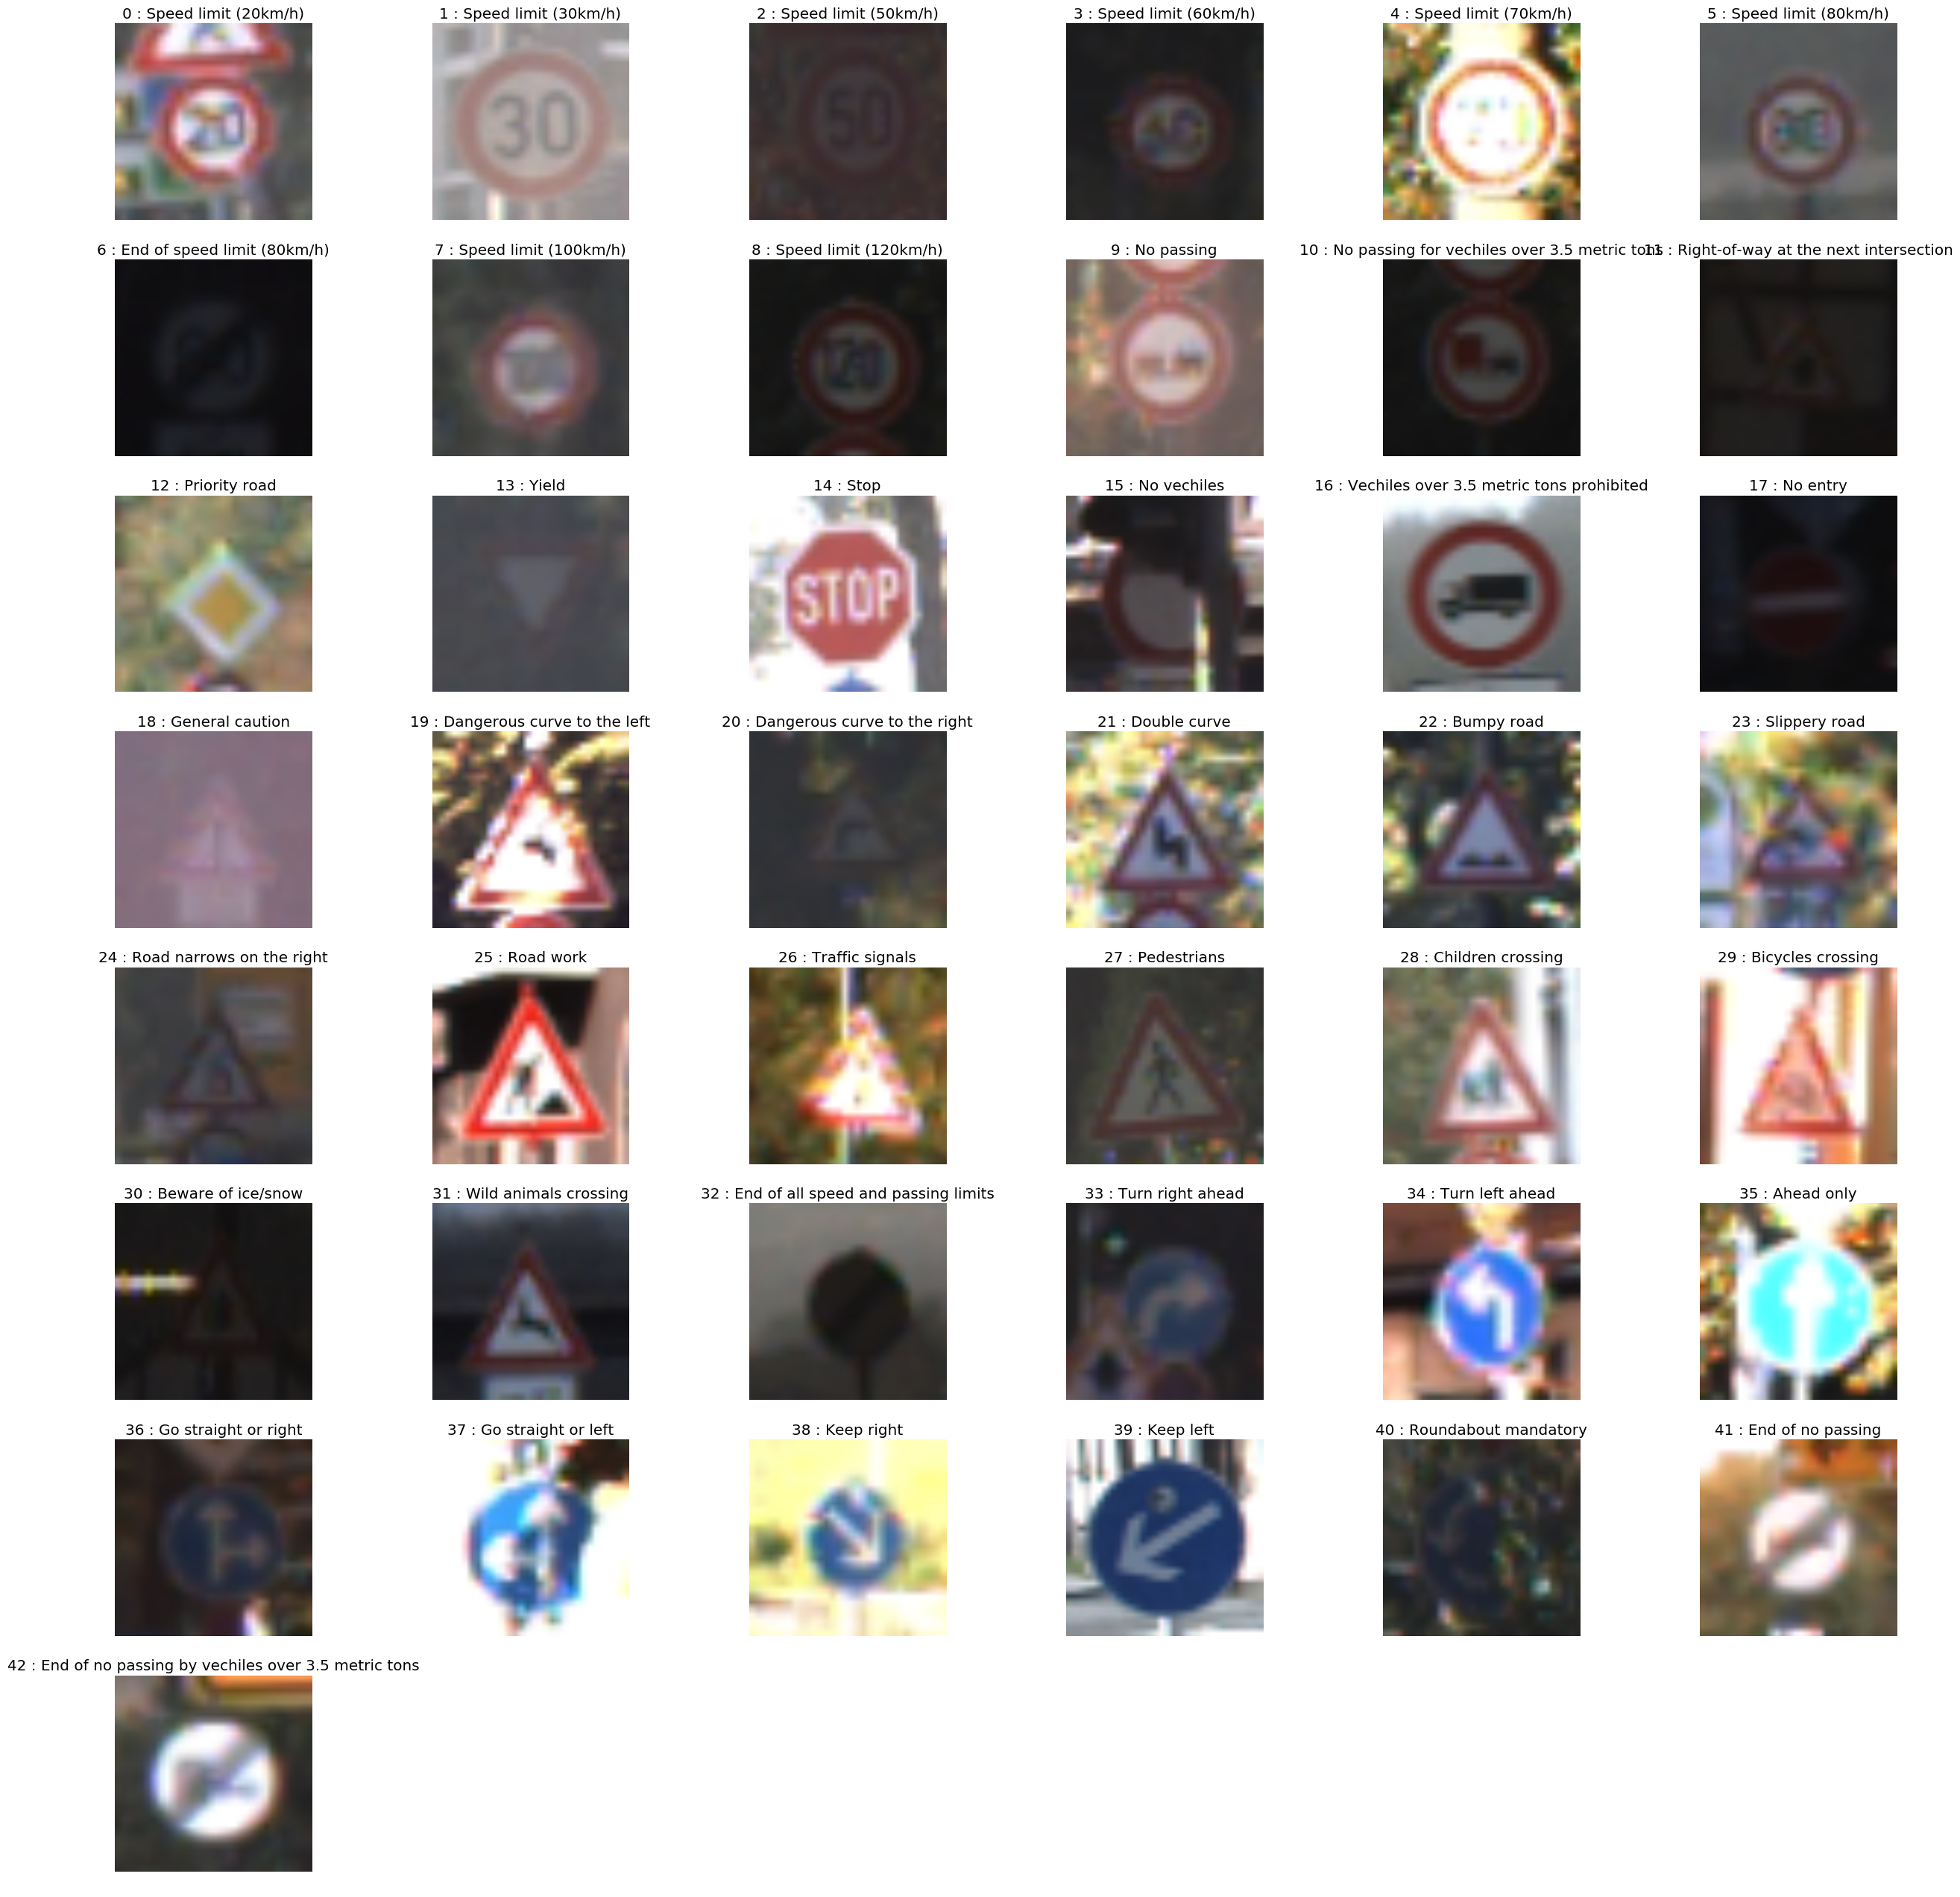

In [6]:
# Display a single image per label.
unique_label_images = {}
for image, label in zip(X_train, y_train):
    if not label in unique_label_images:
        unique_label_images[label] = image
plt.rcParams.update({'font.size': 12})
plt.figure(figsize=(32, 32))
for key in unique_label_images.keys():
    plt.subplot(8, 6, key+1)
    plt.title("{1} : {0}".format(sign_names[key],key))
    plt.axis('off')
    var_holder = plt.imshow(unique_label_images[key])
plt.show()

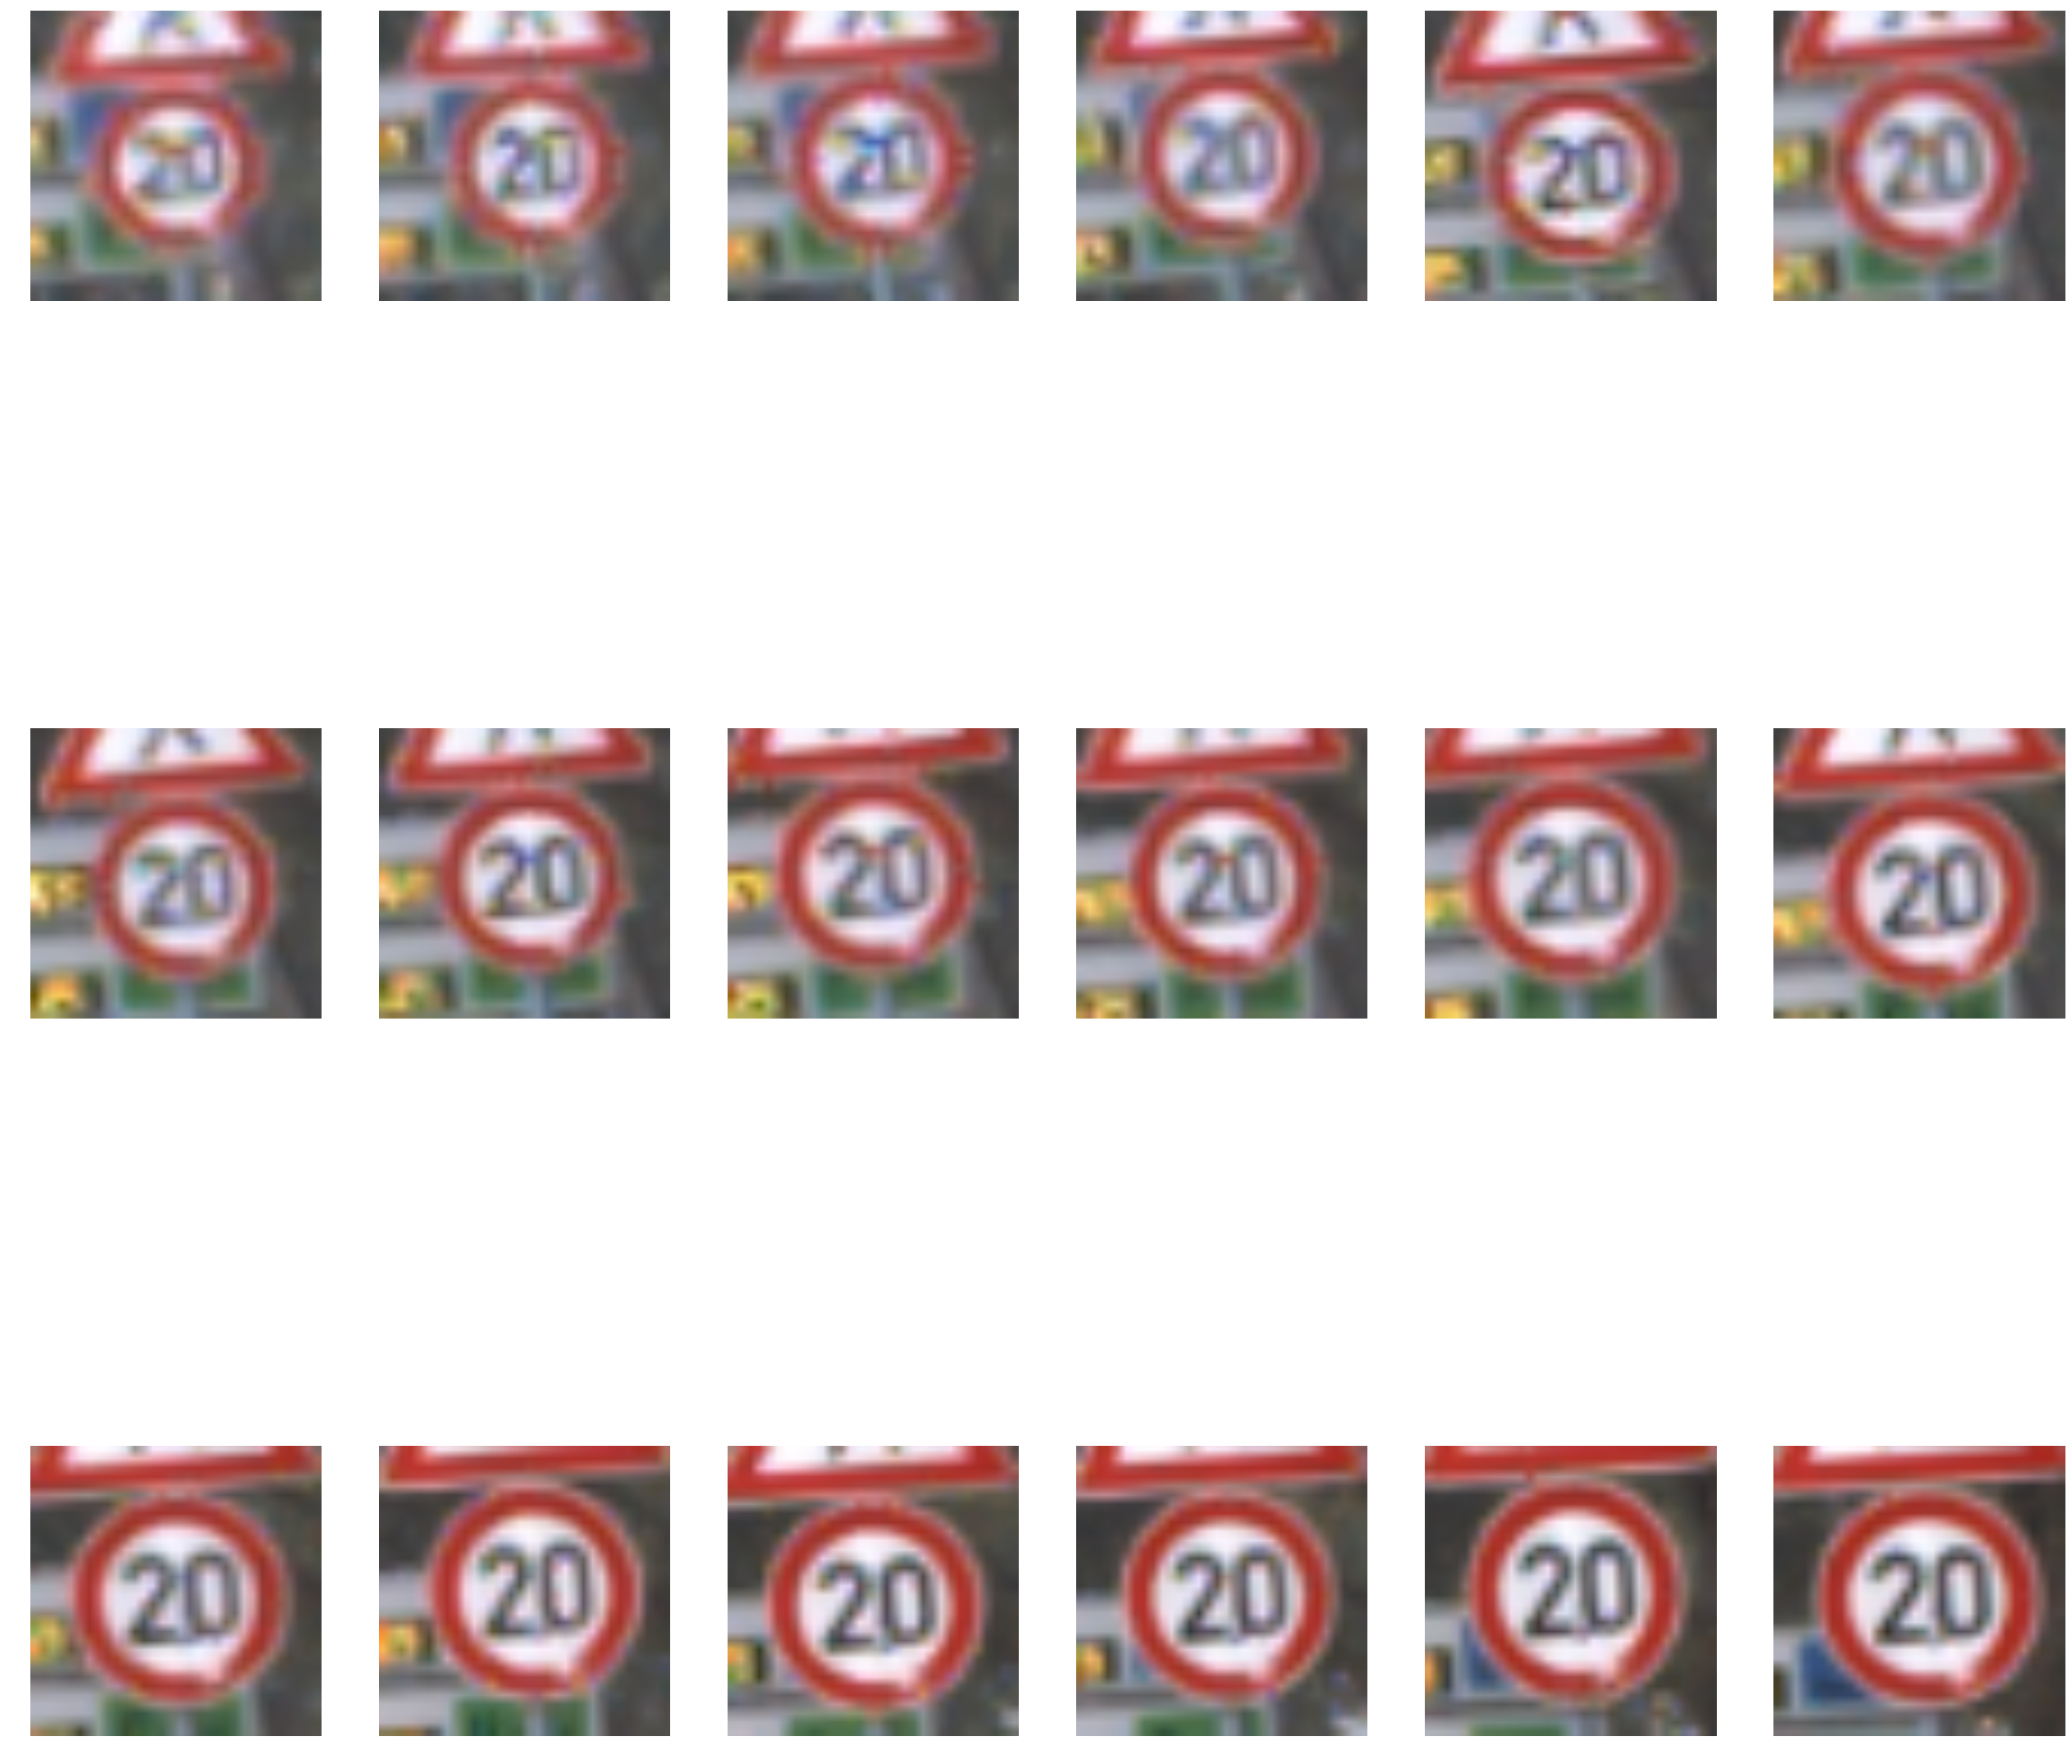

In [118]:
# Display multiple images for a single label
images = []
label_using = 0 ## => jsut a random label
for image, label in zip(X_train, y_train):
    if label == label_using and len(images) < 18:
        images.append(image)
    if len(images) >= 18:
        break
plt.figure(figsize=(32, 32))
for i in range(len(images)):
    plt.subplot( 3,6, i+1)
    plt.axis('off')
    var_holder = plt.imshow(images[i])
plt.show()

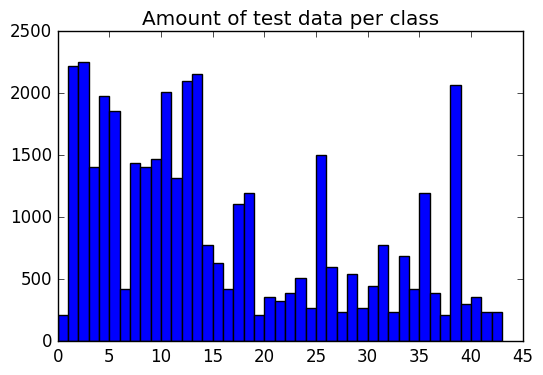

lowest amount of test data in a class: 210
highest amount of test data in a class: 2250


In [8]:
###Get amount of test cases per class
number_of_classes = {class_n:0 for class_n in set(y_train)}
for c in y_train:
    number_of_classes[c] += 1 
a = plt.bar(number_of_classes.keys(), number_of_classes.values(), width=1)
plt.title('Amount of test data per class')
plt.show()
print('lowest amount of test data in a class: {0}'.format(min(number_of_classes.values())))
print('highest amount of test data in a class: {0}'.format(max(number_of_classes.values())))

In [9]:
##Percent of classes where the total test data is greater than 1000
sum(1 for val in number_of_classes.values() if val > 1000)/len(number_of_classes.values())

0.3953488372093023

----

## Step 2: Design and Test a Model Architecture

Design and implement a deep learning model that learns to recognize traffic signs. Train and test your model on the [German Traffic Sign Dataset](http://benchmark.ini.rub.de/?section=gtsrb&subsection=dataset).

There are various aspects to consider when thinking about this problem:

- Your model can be derived from a deep feedforward net or a deep convolutional network.
- Play around preprocessing techniques (normalization, rgb to grayscale, etc)
- Number of examples per label (some have more than others).
- Generate fake data.

Here is an example of a [published baseline model on this problem](http://yann.lecun.com/exdb/publis/pdf/sermanet-ijcnn-11.pdf). It's not required to be familiar with the approach used in the paper but, it's good practice to try to read papers like these.

### Implementation

Use the code cell (or multiple code cells, if necessary) to implement the first step of your project. Once you have completed your implementation and are satisfied with the results, be sure to thoroughly answer the questions that follow.

In [10]:
### set max amount of test data per class = 1000 to avoid Imbalanced Data
training_features = []
training_labels = []
n_features = {class_n:0 for class_n in set(y_train)}
for image, label in zip(X_train,y_train):
    if n_features[label] < 1000:
        training_features.append(image)
        training_labels.append(label)
        n_features[label] += 1

In [11]:
##Convert images from RGB to GRAYSCALE
import cv2
import numpy as np
gray_train_features = [cv2.cvtColor(image, cv2.COLOR_BGR2GRAY) for image in  training_features]
gray_test_features = [cv2.cvtColor(image, cv2.COLOR_BGR2GRAY) for image in  X_test]


In [12]:
## normalize the images using minmax normalization
def normalize_greyscale(image, a=0.1, b=0.9,grey_min=0,grey_max=255):
    return a + ( ( (image - grey_min)*(b - a) )/( grey_max - grey_min ) )
train_features = [normalize_greyscale(image) for image in gray_train_features]
test_features = [normalize_greyscale(image) for image in gray_test_features]

In [13]:
##Shuffle the data 
from sklearn.utils import shuffle
train_features, train_labels = shuffle(train_features,training_labels, random_state=0)

In [14]:
##One hot encode the labels
from sklearn.preprocessing import LabelBinarizer
encoder = LabelBinarizer()
encoder.fit(train_labels)
train_labels = encoder.transform(train_labels)
test_labels = encoder.transform(y_test)

In [15]:
# Change to float32, so it can be multiplied against the features in TensorFlow, which are float32
train_labels = train_labels.astype(np.float32)
test_labels = test_labels.astype(np.float32)

In [220]:
import tensorflow as tf

# Parameters
learning_rate = 0.01
training_epochs = 10
batch_size = 100
display_step = 1

n_input = 1024
n_classes = 43

n_hidden_layer = 1024



weights = {
    'hidden_layer': tf.Variable(tf.random_normal([n_input, n_hidden_layer])),
    'out': tf.Variable(tf.random_normal([n_hidden_layer, n_classes]))
}
biases = {
    'hidden_layer': tf.Variable(tf.random_normal([n_hidden_layer])),
    'out': tf.Variable(tf.random_normal([n_classes]))
}

#Graph input
x = tf.placeholder("float", [None, 32, 32])
y = tf.placeholder("float", [None, n_classes])
x_flat = tf.reshape(x, [-1, n_input])


# Hidden layer with RELU activation
layer_1 = tf.add(tf.matmul(x_flat, weights['hidden_layer']), biases['hidden_layer'])
relu_layer = tf.nn.relu(layer_1)

# Output layer with linear activation
logits = tf.add(tf.matmul(relu_layer, weights['out']),biases['out'])

# Define loss and optimizer
cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits, y))
optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate).minimize(cost)

top_5_val,top_5_ind = tf.nn.top_k(logits,k=5)


# save the model for later
saver = tf.train.Saver()

# Test model
correct_prediction = tf.equal(tf.argmax(logits, 1), tf.argmax(y, 1))
accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
    
    
# Initializing the variables
init = tf.initialize_all_variables()

### Question 1 

_Describe the techniques used to preprocess the data._

**Answer:**

* Imbalanced data: 
    After seeing that the amount of test data isn't the same amount per class, I decided to combat this issue by having a max of 1000 test cases per class (since 60% of the classes had less than 1000 test cases). I didn't mix the test and training data because I was worried of over-fitting (as seen above there are many images from the same physical sign).
* Convert from RGB to grayscale - using opencv
* Normalize the data - using minmax normalization with a range of 0.1-0.9
* Shuffle the data - for better training performance
* One hot encode the labels -scikit learn



### Question 2

_Describe how you set up the training, validation and testing data for your model. If you generated additional data, why?_

**Answer:**

The training and testing data were preprocessed and in separate files, Thanks to the amazing folks at Udacity.

### Question 3

_What does your final architecture look like? (Type of model, layers, sizes, connectivity, etc.)  For reference on how to build a deep neural network using TensorFlow, see [Deep Neural Network in TensorFlow
](https://classroom.udacity.com/nanodegrees/nd013/parts/fbf77062-5703-404e-b60c-95b78b2f3f9e/modules/6df7ae49-c61c-4bb2-a23e-6527e69209ec/lessons/b516a270-8600-4f93-a0a3-20dfeabe5da6/concepts/83a3a2a2-a9bd-4b7b-95b0-eb924ab14432) from the classroom._


**Answer:**

My model is a simple neural network with 3 steps: 

**input => sofmax => relu => softmax => output **  
The input size is 1024 since the image is of dimension 32*32.  
The number of hidden layers is 1024 nodes (this was my second choice after trying 512 ) 

In [221]:
with tf.Session() as sess:
    sess.run(init)
    # Training cycle
    for epoch in range(training_epochs):
        avg_cost = 0.
        total_batch = int(len(train_features)/batch_size)
        # Loop over all batches
        for i in range(total_batch):
            batch_start = i*batch_size
            batch_features = train_features[batch_start:batch_start + batch_size]
            batch_labels = train_labels[batch_start:batch_start + batch_size]
            _, c = sess.run([optimizer, cost], feed_dict={x: batch_features, y: batch_labels})
            # Compute average loss
            avg_cost += c / total_batch
            
        # Display logs per epoch step
        if (epoch+1) % display_step == 0:
            print ("Iter:", '%04d' % (epoch+1), "cost=", "{:.9f}".format(avg_cost))

    print("Optimization Finished!")
    print("Accuracy on testing data:", accuracy.eval({x: test_features, y: test_labels}))
    print("Accuracy on training data:", accuracy.eval({x: train_features, y: train_labels}))
    save_path = saver.save(sess, "saved_models/model.ckpt")

Iter: 0001 cost= 82.788698026
Iter: 0002 cost= 17.134515106
Iter: 0003 cost= 10.568002710
Iter: 0004 cost= 7.155878488
Iter: 0005 cost= 5.238684923
Iter: 0006 cost= 4.441403067
Iter: 0007 cost= 3.555229584
Iter: 0008 cost= 2.990376888
Iter: 0009 cost= 2.422931370
Iter: 0010 cost= 2.028984747
Optimization Finished!
Accuracy on testing data: 0.627949
Accuracy on training data: 0.774719


### Question 4

_How did you train your model? (Type of optimizer, batch size, epochs, hyperparameters, etc.)_


**Answer:**

* Adam Optimizer (as opposed to a simple gradient decent optimizer) since it gave me a better accuracy
* learning rate of 0.01 ( I tried 0.5,0.1,0.01,0.001 and this gave me the best accuracy)
* batch size of 100 (I tried 25,50,100,200 and this had the best accuracy)
* 1000 iterations ( I tried to use the amount of iterations it takes to get an accuracy of 100 on all training data, but don't have enough power on my docker image, so I ended up running 1000 iterations over night) 


### Question 5


_What approach did you take in coming up with a solution to this problem?_

**Answer:**

I started off by creating a simple logistic regression which gave me an accuracy of 71% after 100 iterations.I then created a simple neural network which gave me an accuracy of 75% after 1000 iterations. I then created a simple multi level deep neural network which gave me an accuracy of 8% after 1000 iterations.
I decided to stick with the simple neural network and optimize it to get better performance.

---

## Step 3: Test a Model on New Images

Take several pictures of traffic signs that you find on the web or around you (at least five), and run them through your classifier on your computer to produce example results. The classifier might not recognize some local signs but it could prove interesting nonetheless.

You may find `signnames.csv` useful as it contains mappings from the class id (integer) to the actual sign name.

### Implementation

Use the code cell (or multiple code cells, if necessary) to implement the first step of your project. Once you have completed your implementation and are satisfied with the results, be sure to thoroughly answer the questions that follow.

In [121]:
### Load the images and plot them here.
### Feel free to use as many code cells as needed.


In [122]:
##Download some images
import urllib.request as request
has_testing_images = os.path.isfile("testing_images/stop_sign.png") 
if not has_testing_images:
    
    img = request.urlretrieve("data:image/jpeg;base64,/9j/4AAQSkZJRgABAQAAAQABAAD/2wCEAAkGBxAPEBUQEBAVFhMWFhUXEhUXGBgXGhUXFxsaGBUXFhUYHiggGRolGxYVITEhJSkrLi4uFx8zODMsNyguLisBCgoKDg0OGhAQGy8lICUtLS0tLy8vLy0tKy0tLS0tLS0tLS0vLS0tLS0tLS0tLSstLS0tLS8tLS0tLS0tLS0tLf/AABEIAOEA4QMBEQACEQEDEQH/xAAcAAEAAgMBAQEAAAAAAAAAAAAABgcEBQgBAwL/xABQEAABAwECBgwKCQIDBwUAAAABAAIDBAURBgcSITFRExUWQVRhcYGSk7LRIjI1U3N0kaGxsxQjMzRCUlVicoLBJEOiF0Rjg4TS8AglNpTC/8QAGwEBAAMBAQEBAAAAAAAAAAAAAAQFBgMCAQf/xAA9EQACAQMABQcLBAEDBQAAAAAAAQIDBBEFEiExURMUQWFxkbEGFSIyMzRSU4HB0UJyoeFiJILwFiM1kvH/2gAMAwEAAhEDEQA/ALAsayY7UjFdXDZWS3upqdxJhjhJ+rJj8V8jmgOLnA3ZVwuAzgbHcPZP6bSdTH3IBuHsn9NpOpj7kA3D2T+m0nUx9yAbh7J/TaTqY+5ANw9k/ptJ1MfcgG4eyf02k6mPuQDcPZP6bSdTH3IBuHsn9NpOpj7kA3D2T+m0nUx9yA8OBFk/ptJ1MfcgNXW2Xg5AbpKez2nVscRPRAJXh1IreyVSsbirthBv6GomrcGGm4UNO7+NIPi5gXN3NNE2Og72X6Uu1oxH2rg4NFkxn/p4R8SvLuoHdeT1097j3/0G2tg5v2RGP+ngPwKc6gH5PXXGPf8A0ZUNdgw43Gggb/KkHxa0r0rmm+k4z0FeR/Sn2NG1orPwbmzR09ATqMcTT7HAFe1Vg9zIdXR91S9em+427cCbIIvFnUhHoY+5dCG1jee7h7J/TaTqY+5ANw9k/ptJ1MfcgG4eyf02k6mPuQDcPZP6bSdTH3IBuHsn9NpOpj7kA3D2T+m0nUx9yAbh7J/TaTqY+5ANw9k/ptJ1MfcgG4eyf02k6mPuQGFa2DbKON1VZjBBLEC/YmeDDUNaL3RSRDwb3AEB4ALTcb7rwQNb/tesnzx9iA3+L7yTQ+qwfLagJAgCAIAgCAIAgNFbmFdHR5pZQX+bZ4T+cDxee5cp1YR3snWujbi59SOzi9iILa2MyofeKaJsTd5zvDf7PFHvUWd1J+qaK28naUdtaWepbF+SI2ha9TUm+eeR/EXHJ6A8H3KPKcpb2XVGzt6K/wC3BL6be/eYIAGgLySWz1D4EAQBACEBlUNpT05vgmkj4muIHO3QecL1Gco7mcK1rRre0in9P+Mllk4yauK4TsZM3X4j/aPBPsCkRupLeU1x5PUJ7aT1X3r8k6sPDOiqyGtkyJD/AJcngknU06HcxUqFaMtxnrrRVzb7ZRyuK2okS6lcEAQBAEAQBAY1p/YS+jf2SgOJUB2Hi+8k0PqsHy2oCQIAgCAIAgNZbluU9EzLnfdf4rRnc86mt314nNQWWSbW0q3M9Sms+C7SrcI8PamqvZCTDFqafDcP3PGjkb7SoNS4lLYtiNdZaDoUPSq+lL+F9PyRJR3tLtbAgCAIAgCAIAgCAIAgFyDJJsHcN6ujuaXbNF+R5zgfsfpHIbxyLvTryj1oqL3Q1vcelH0ZcVu+qLTwewkpq5t8L/CA8ON2Z7eUb44xmU6FSM9qMhd2Fa1liotnHoZuV0IYQBAEAQGNaf2Evo39koDiVAdh4vvJND6rB8tqAkCAIAgCAh+GWG0dHfDDdJUavwx8b7tJ/b7blHq11BYW8udG6IndenPZD+X2fkqSurZaiQyzPL3nS4/ADQBxBQJScnlm0o0KdGGpTWEfBeTqEAQBAEAQBAEAQBAEAQBAEB9KaofE8SRvLXtN7XNNxHIV9TaeUeakIVIuM1lcC1MDMPG1BEFVcybMGP0NkOr9r+LQd7Up9K4Utkt5jtJaFlQzUo7Y8Olf0Tm9SSgPUAQBAY1p/YS+jf2SgOJUB2Hi+8k0PqsHy2oCQIAgCAgeHuGv0e+lpXfXaJJBn2K/eH7/AIKLXr6vox3mg0Rojl8Vqy9HoXxf14lVEk5ySSc5Jzkk6SSdJUA2OMLCPEPoQBAEAQBAECCH3AQ+BAEAQBAEAQBAEBZOAOGxJbSVb7ybhDKTp1MkOvU7f0HPpnUK+fRkZTS+h8J16C2dK+6+6LIClmYPUAQGNaf2Evo39koDiVAdh4vvJND6rB8tqAkCAICH4f4V/Qo9hhP+IeM3/Dboyzx6QPbvKPXq6iwt5c6I0bzqevP1F/L4fkp4m8kk3km8k5ySc5JO+VXG4WFsR4h9CAIAgM2xaVs9TDC+/JfIxrrsxucbjcvUFmSRHu6jpUJzjvSbLHtPFpT7C/6O+TZbiY8twLSRoB8HQdF/GpsraONm8ytDygr8ouVxq9OEVa9haS1wIcCQ4HSCMxB51Bew2KaklJbmfezIBLPFG6/JfJGx12m5zgDdx3FfYrMkjlcTdOlKa3pNk6wxwJpaOjfPE6TLaWAZTgR4Tg05rtRUqtQjCOUZ7Rml7i4uY054w89HUV4oZqCV4KYDzVzRNI7YoD4puvdJxsBzAcZ9hUinbuW17ik0hpmnbN04LWl/C7Sbx4uLOAuLZXH8xkcD7G3D3KRzamUL0/eN5TS+iNDhBi1LGmSikLrs+xPIvP8AB4uz8R9q5zttmYlhZ+UOXq3C+q+6/BXjmkEggggkEHMQRpBG8VEfA1Cakspni+AIAgCAIMlrYucLDO0UlQ761o+ref8AMaN4/vHvGfWrChW1vRe8xumtGci+WpL0XvXB/hk8Ukz4QGNaf2Evo39koDiVAdh4vvJND6rB8tqAkCA1uEFsR0VO+eTPdma3fc4+K0cp/uvE5qCyyTaWs7mqqcOn+FxKHr6ySolfNK697ze4/ADUAMw5FVyk5PLP0ShRhQpqnDcjHXk6hAEAQBAbTBb79Temj7QXSl667SJpH3Wr+1l9veBdeQLzcL986laZPzlJsrPGjg5ku+nRNzEgTgbx0Nk58wPNxqHcUv1I1WgNIZXNpv8Ab+PwQqwvvdP6eHttUaHrIv71f6ep+1+BbeMzybL/ACi+Y1Trn2bMZoP32H18GVVgvZn0urigPiude/8Ag0ZTvbddzqHTjrTSNfpG5dvbTqLfuXay3cLrdbZtLlMaC8kMhZoF92/d+EAfAKfVqKnHJidHWUr2vqt7N7f/ADiVNUYU18jst1XKDffc12S0cjW5rlXutNvOTZw0ZaRjqqmvrvJ7i8wvkqnGlqTfIGl0cl12WBdlBwGbKF9940i/Vnl29Zz9F7zOaZ0VC3XLUvVzhrh/Ro8a1kNinZUsFwmBD/5tuz8paf8ASud1DD1iw8nrp1KUqMv07V2EGUQ0QQBAEAQH7gmdG9r2OLXtIc1w0gjQQieHlHycIzg4yWU9jLzwQt5tfTNlzCQeDM0fheNN3EdI5Va0qinHJ+eaQspWlZwe7enxRvF0IJjWn9hL6N/ZKA4lQHYeL7yTQ+qwfLagJAUBTWMi3vpVTsLD9VAS0anSaHu5vFHIdar7iprSwug2+g7LkKHKy9aX8Lo/JElGLsIAgCAIAgNpgt9+pvTR9oL3S9ZdpE0j7rV/ay0sZkrmUBexxa5ssJa4aQQ8EEKfcNqGUY/QkIzulGSymn4GXgzbEdqUfhtBdcY6iPevuz5vykZxy8S9U5qpE431pOxuMRfXF9X9FZ1lhuoLThhN5YZoXROP4mF4uz6xoPt31CdPUqJGqp3sbuxnPp1WmuvH3LExmeTZf5RfMapVz7Nma0H77D6+DIRiojBryfywSEc7ox/cqPbeuy/8opYtUv8AJeDNljilOXTM3smV3PewL3d9BE8morFSXZ9yu1DNQbzAaUttGmI33kHkcxwXah7RFdpiKlZVM8F4on2NuMGjjdvtmbdzteFKuvUM55OyxdNcYv7FSqvNoEAQBAEAQEgwHt36DVtc4/VSXMl1AE+C/wDpJ9hK7UKmrLqKvS9lzqg8etHavuvqXiCrMwJj2n9hL6N/ZKA4lQHYeL7yTQ+qwfLagPphnbH0OjklB8MjIi/m7MDzZ3cy5VZ6kGydo215zcRh0b32IolVe8/RMJbAgCAIAgCAIDaYLffqb00faC90vWXaRNI+61f2ss/Gl5Od6SLthTrn2ZkdAe+R7H4FbYJW+6gqRLnMbvBmaN9usDW3SOcb6h0qmpI1OkrFXdFx/UvV/H1LftiyYq5kMgIvjkjmheM+YEOI42ub/Y7ysJRUsGIt7mpbSnHinFr/AJwNdjM8my/yi+Y1eLn2bJeg/fYfXwZAsWNQGWi0E+PHIwcuZ47BUW2eKho9P03K0bXQ0/t9yRY36MmOCcDMxzmOOrLuLb+dt3Out3HYmVfk3VSqTpvpSa+n/wBKyUI1pJsXNGZbRiIGaIPkdxZi1vvcPYu9vHNQqdOVlCzkviwvu/AluN+pup4Yt90pdzMaR8Xhd7p4ikUvk5TzWnPgvFlWKCbAIAgCAIAgBQF0YubZNVRta43yQnY38YHiO523c4Ks6E9aBgtM2nN7l43S2r7/AMkhtP7CX0b+yV2Ko4lQHYeL7yTQ+qwfLagIRjZtPLqI6YHwYm5Th+9+jnDR/rUG6nl6pr/J221aUqz6di7F/ZBFENGEAQBAEAQBAbTBb79Temj7QXun667SJpH3Wr2Ms/Gn5Od6SLtBT7n2ZkdA++LsfgU4q03JZGK7CP8A3GV2s05PtdHzZyOfUpttV/SzK6f0fh85pr935JBjM8my/wAovmNXW59myt0H77D6+DKdo6l8MjJYzc9jg5p4x/ZV6bTyjc1acatOUJbmsF3WRalLatMQQHBwyZonaWnUR7wVZQnGpE/Prm3r2Ffg1ufEjs+K6AuvZUyNZ+UhriOIOze8FcXaxzvLSHlHWUcSgm+O0klk2TSWVA4tOS0Z5ZXkXuu33H4Aa13jGNNFVcXVe+qrO19CX2Klwxt/6fUmQXiNoyYgdOTfeXEbxcc/IAq+rU15ZNroux5pQ1X6z2v8fQ0a5FgEAQBAEAQBAS3FlaewVwjJ8GdpYf5t8Jh7Q/qUi2lieOJS6ftuUttdb47fp0/Yty0/sJfRv7JViYc4lQHYWL8/+00PqsHy2oCm7brjU1M05/HI4t/jfcz/AEhqqJy1pNn6VZ0VRt4U+CXf0/yYS8kgIAgCAIAgCA+lPO6N7ZGOyXtIc05sxGcHOvqeHlHmpCNSLhLczY2jhHWVMZinqHPYSCWkMGcG8HwWg6V7lVnJYbItDR1tQlr04Yfa/wAmqXMmH7hlcxzXsJDmkFpGkEZwQvq2HmUIzi4yWUzZ1+EtbURmKaoc9huJaQwX3G8aGg6QF7lVlJYbIlHR1rRmp04Ya6cv7s1K5k0+1JVSQvEkUjmPGhzSQeTNpHEV6Ta2o51aUKsdSok11khjxgWk0ZOzMPG6NpPuuHuXXnNQrJaCsm84feae1bZqas31Ezn3ZwDmaORguF/HpXOU5T3snW9lQt/ZRx495gLwSQgCAIAgCAIAgPpT1DontlZ4zHNe3labx8F9i8PJ5qU1Vg4Pc1jvOgKmcSUrpG6HROcOQtvHxVunlZPzGcXCTi+hnFS+nk6user2DByGQaW0EV3KYwG+8heKjxFslWNLlbiEOLRULRcLlUn6S2eofAgwEGAgwEGAgwEGAgwEGAgwEGAgwEGAgwEGAgwEGAgwEGAgwEGAgwEGAgCAubBCq2Wx2nfbFJGf6Mpo9wCs6EswR+f6XpcneTXF579pyQuxWnS9dNk4MUoH4oKNvuY4+5q4XPsy30FHWvYvgm/4K5VabskuL2ghqa4RTxtezYpDkuF4vBbcfeV2t4qU8MqdNVqlG11qbw8ravqWhuNs3gUXRU7kYcDI+c7z5ku8bjbN4FF0U5GHAec7z5ku8bjbN4FF0U5GHAec7z5ku8bjbN4FF0U5GHAec7z5ku8bjbN4FF0U5GHAec7z5ku8bjbN4FF0U5GHAec7z5ku8bjbN4FF0U5GHAec7z5ku8bjbN4FF0U5GHAec7z5ku8bjbN4FF0U5GHAec7z5ku8bjbN4FF0U5GHAec7z5ku8bjbN4FF0U5GHAec7z5ku8bjbN4FF0U5GHAec7z5ku8bjbN4FF0U5GHAec7z5ku8bjbN4FF0U5GHAec7z5ku8bjbN4FF0U5GHAec7z5ku8bjbN4FF0U5GHAec7z5ku8bjbN4FF0U5GHAec7z5ku8bjbN4FF0U5GHAec7z5ku8bjbN4FF0U5GHAec7z5ku8bjbN4FF0U5GHAec7z5ku8bjbN4FF0U5GHAec7z5ku8bjbN4FF0U5GHAec7z5ku8rrGZZcFLURMp4mxtMZJDRdecq69RLiKjJYNRoG4q1qU3Uk289PYQ9Ri8LPxazl1m1LPyPlu5HRtPxvU+0foGM8ooYuVLjFeLOYFKKE6Mtl12DlnDXHS+6ElRrr1C98nlm6f7X9iBqvNoS3Fb5RHoZfixSLb2n0KXyg9z/3L7lyqxMOEAQBAEAQBAEAQBAEAQBAEAQBAEAQBAEAQBAVTjf8AvUPoj2lBuvWXYbDyb9jU7V4EDUQ0RYuLB3+ErRz+1jh/ZTrTczJeUvtKb6n4nNKlmaOjLabfg5Zx1R0vySFGuvUL7yef+qf7X9iCKvNoS3Fb5RHoZfixSLb2n0KXyg9z/wBy+5cqsTDhAEAQBAEAQBAEAQBAEAQBAEAQBAEAQBAEAQFU43/vUPoj2lBuvWXYbDyb9jU7V4EDUQ0RYmK8f4WtPEB7GO71OtNzMn5S+0p9j8TmtSzNHStoRF2DFIR+GCjd7mtPaXC5WabLfQU9W8iuKa/grpVpukSrFrOyO0A6R7Wt2KQXuIaLyW5ryu9s0p7Sn07GU7TEVn0l9y29uKXhMPWM71Ya8eJiub1fhfcxtxS8Jh6xnemvHiOb1fhfcxtxS8Jh6xnemvHiOb1fhfcxtxS8Jh6xnemvHiOb1fhfcxtxS8Jh6xnemvHiOb1fhfcxtxS8Jh6xnemvHiOb1fhfcxtxS8Jh6xnemvHiOb1fhfcxtxS8Jh6xnemvHiOb1fhfcxtxS8Jh6xnemvHiOb1fhfcxtxS8Jh6xnemvHiOb1fhfcxtxS8Jh6xnemvHiOb1fhfcxtxS8Jh6xnemvHiOb1fhfcxtxS8Jh6xnemvHiOb1fhfcxtxS8Jh6xnemvHiOb1fhfcxtxS8Jh6xnemvHiOb1fhfcxtxS8Jh6xnemvHiOb1fhfcxtxS8Jh6xnemvHiOb1fhfcxtxS8Jh6xnemvHiOb1fhfcxtxS8Jh6xnemvHiOb1fhfcxtxS8Jh6xnemvHiOb1fhfcxtxS8Jh6xnemvHiOb1fhfcxtxS8Jh6xnemvHiOb1fhfcysMa1VHLUwmORrwIiCWuDrjlcShXTTksGt8naco0Z6ya28OohKimgLOxaQ3WdVP/M+S7kbE0fG9T7Vei31mN8o55uYx4R8WzmBSjPnVdmUhmwbhjGk0ERHK2Nrh7wFzqrMGiZo+ryV1Tk+KKlBVUfowKA8yRqQZYyRqQZYyRqQZYyRqQZYyRqQZYyRqQZYyRqQZYyRqQZYyRqQZYyRqQZYyRqQZYyRqQZYyRqQZYyRqQZYyRqQZYyRqQZYyRqQZYyRqQZYyRqQZYyRqQZYyRqQZYyRqQZZ6AgyEBceBlNsdjj98csnTyiPdcrOgsQRgdM1Ne8n1bO45LXYqzsLABoNkUQOg0kF/VtQZxtKYtWjNPPLAf8uRzRyA+Cedtx51UTjqyaP0u2rctRhU4pd/T/JirydwgCAIAgCAIAgCAIAgCAIAgCAIAgCAIAgCAIAgCA/UUTnuDG+M4hreVxuHvK+rbsPk5qEXJ7lt7joCWmEVI6JuhkJaORrLv7K3SwsH5jUm6k3N9LycWL6eDsPF95JofVYPltQEDxrWZsVW2cDwZm5/5suB9rcn2FQLqOJZNl5PXGvQlSe+L/hkJUU0AQBAbnA6mjmr4I5WB7HOcHNcLwRkPOccoC60VmayV+lKkqdpOcHhrHiizLTs+xKVwZUQ00biLwHNAvGi/RrCmyVKLw8GToVtJV03TlJrtMPZMHNVJ0R3Lzmj1HfU0v8A5kNw8NAZIvoGxZOS/ZNjFwvvbk38d16jV3DK1C90NzpRnznOcrGSdWRgnQz0ERdTxh8kDL5A0B4c5o8IHXfnUqNKLgtnQZ240lc0rqWJvCk9nRv3FU2tZ0lLM+CUeEw3X7zh+Fw4iM6gTg4Npm0tbmFxSVSG5/w+BNcWFjU1VHOaiBkha9oaXtBuBbeQFKtoRabaM/p+6rUakOSk1lPd2mhsUUjLSkFW1n0dr5xc4EtFziGC4DeuXKCgqnpbixuXcTsYug3rtR7d20nVBDYFRI2KGKBz3X5LRG4X3C86RdoBUqKoyeFgz1aWlaMNeo5Jdp9bUo7CpHiOeGBjiA4AsJzEkX5hrBSUaMXhpHihV0ncR1qUpNdpX+HclCZGGzwwM2M5eQ0tGVfmvvAz3KLW1MrUNLohXShLnOc52Z4Fjz2HZNPC2WopqdjbmgucwaSFMcKaWWjKxu76rVcKc5N7dmTAy8HdVJ0R3Lxmj1EnGl/8zVYZ4FQNgNZQ+K0ZT2A5TXM33sO9cM9191wXOtQjjWgTNGaXquqqFx07E+lPgzCxdihqCaWqponSZ3RPc3O8aXMJ1jSOLkXm31JejJbSRprnVLFalNqO5rh1/U1OG2DpoKghoOwyXuiOrWwnWPhdxrnWpaktm4m6Kv1dUcS9db/ya+wLIkrahsEe/ne78jB4zj8BxkLxTg5vCJV7dxtaLqS+i4sm2HVHZ1BTthipYzUPFzXEAua0ZnSOP5tXHyFSqypwjhLaZ7RNS8u6znOo9Rb+vqK4UI1YQBASjFvZuz17HEeBCDI7l0MHtN/9K728dafYU+nLjkrVxW+Wz6dJcNp/YS+jf2SrIwpxKgOw8X3kmh9Vg+W1AfnDyx/pdE9rRfIz6yPjc3S0covHOuNaGtDBY6Kuub3MZPc9j7GUeFWH6Ewh8CA32AflKm/m/wCW9d7f2iK3THuNT6eKLBw2wOltCZkrJmMDWZBDmk3m8m/NyqVWoubzkzWi9LQs6coSi3l5346CAYU4KSWcIzJK1+yFwGSCLskA57zxqJUounjLNLo/Skb2UlGOMdeSPriWXSXSy0zSWPFUBuVkQ05I1glgcBx3E3castbVpJ9SMC7fnGkJUuMpfc12HFjstKkZW03hPazKbdpkj0ub/IZyBrvG+vNamqkVKJK0Vdzsrh0KuxN4fU+PYYuJ0/VVHpGdlebXczv5S+1p9j8SvLY+8z+mm7blDn6zNNae70/2rwRucXflKD/mdhy62/tEQNN+5T+nibHGz99Z6BvbevV165F8nfdpfu+yIRL4p5Co5oUXPhzZ81TZzY4Iy9+VCckXX3DSc5VhWi5U8Iwmi69Oje69R4XpFajBC0eBye1n/cofIVOBq/O9l8xfz+Cx6KmdZtjPZUuGU2OW8X3gGS/JjB387gFMS1KWGZSrUV5pFSorY2v46fuVBTyujc17HFr2kFrhpBGgqvTaeUbmcI1IuEllPYW9RzQ27Z5a+5sozOu0xyjxXj9p+BIVgnGtAw9SFTRV3mO7o61wPzYFmxWJRPnqCNlIvlI3zoZEw7+c85JKU4KjDLPt3cVNJ3UadPduS8WyrLXtKSrnfPKfCedG80DxWjiA799QZycnlmxtreFvSVKG5fy+lmGvB3CAIMFxYsrH+j0eyuFz5zlnWGaIx7PC/qVjb09WG3pMNpy75e51Vujs+vSSe0/sJfRv7JUgpjiVAdh4vvJND6rB8tqAkBQFJ4wLC+h1Zc0fVTXvj1A/jZzE3jidxKtr09WXUzd6GvecW6jL1o7H2dD+xGVwLcIDfYB+Uqb+b/lvXe39oit0x7lU+niiWYzbbqqapiZBO+NpivIbdnOURfnB3gu1zUlGSwym0FY29elKVWOWn18CB2lbFTVZIqJnSBt+TlXZr9N1wGoKLKpKW9mjoWdC3bdKKWTBXgkltWz/APHx6vT/ABjVhP2H0MTa/wDlv90vuR/FjhHsMn0OV31chviJ/DIdLeR3x5VytquHqss9P2HKR5eG9b+tcfp4FgWJYbKSWodHcGTPbIG/lddc4DiJz85UqMFFtrpM1c3criEFPfFYzxXQUhbH3mf003bcqyfrM/QLT3en+1eCNzi78pQf8zsOXW39oiBpv3Kf08TY42vvrPQN7b16uvXIvk77tL932RCJfFPIVHNCi8sJLbdQUTZ2MDz9W3JJIHhDWFZTm4QTR+e2Vmrq6dJvG8jtg4xnz1McMsDGNe7Jyg4m5x8XMRoJuHOuVO51pYaLS80BGjRlUhNtrowYuN1s4fCS87A4EBm8JBebzrJac1+jJK83ednA6+TbpNTWPTXT1FdqGagk+LirfHaEbWOubJlNkG84BrnDnBA9+tSLdtTwU+nKUJ2kpNbVtXgbfG7Vv2eKHK+rEeXk63EubeeYXc5Xu6e1RIXk3SioTqY25xnqICohpQgCA3WCNiGuqmxEfVt8OY/sG9yuObnOpdaMNeWCBpO8VrbuS3vYu3+i9mNAAAFwGhWh+ePbtPhaf2Evo39koDiVAdh4vvJND6rB8tqAkCA0+FVhtr6Z0JuDvGid+V40Hk0g8RK8VIKccMmWF3K1rKovr1oompp3xPdHI0tewlr2neI0qqaaeGfokKkakFOD2PcfNfD0bvAqZsdoU73uDWhzr3OIAHgPGcnjK7UGlUWSu0tGUrOpGKy9niiz7Yp7IrHiSolhe5rckHZsm4X33eC4b5UyapT34MlbVL+2i40lJZ/x/owNz9g/mh/+wf8AvXnk6PUSOf6U/wAv/X+iIYfUFBAYfoRYb9k2TIkMmjJyb73G7SVwrxgsapeaGr3VVz5xnZjGVgklrWlA6whEJozJsEAyA9pdeCy8ZN994uK6zlHkcZ6CptqFVaU13F41pbcbOkq//wAHFxgqCbDY9hceB2GENRTj6TKxkzPBfluDcvU8X6bxp471ZUqqlHaYXSWi6lCs+Ti3F7Vjo6iprWcDUTEEEGWUgjOCC9xBBVfP1mbO1TVCmn8K8DbYBTMjtCFz3BrRl3ucQAPAdpJXSg8VFkhaYjKVnJRWXs8TYY0aqOWsY6N7XjYWi9pDhflPzXjlC9XLTnsI2gKcoW8lJNel09iIbJoPIVwL0tPGBacEtmtZHNG5+VD4LXtJzacwN6m1pJ09jMfoehVhfa0otL0ugq686QbjvHUd4qCjYbHsZato2lT2nZVz5omz5AcGue1pEsfETodcRyOU+U41Ke17TGUaFaxv/Ri3HON3QyqgoBsze4DTNZaED3uDWgvvc4gAeA4ZyV2oNKayVul4uVnNRWXs8UbbGnVRy1cbo5GvAhAJaQ4X5Ts14Xu5aclgheT9OcKElJNbensIYoxfhAetaSQACSSAANJJzADjX0+NpLLewu7AjB0UFMA4DZpLnTHj3mA6m6OW876sqNPUj1mA0pfO7rZXqrYvz9SRrsVpjWn9hL6N/ZKA4lQHYeL7yTQ+qwfLagJAgCAguMbBM1DfpUDfrmD6xo/zGDV+8e8ZtSjXFLWWst5faF0lyEuRqP0Xu6n+Cp1Xm0CAXIfcsXINZhD5kIMhAEPuQh8CDIQZCAXIfchD4LkGQgCAAIG8hAECRZeLXBQturahuf8A3dhGgecI1ne4s++LptvRx6TMnpzSalm3pPZ+p8eosdTDMhAY1p/YS+jf2SgOJUB2Hi+8k0PqsHy2oCQIAgPCgK3w/wACiS6rpGXnO6aIb+t7Br1t39Iz6Ylehn0omn0PpdRxQrvZ0P7P7MrZQTVtBAEAQBAEAQBAEAQBAEAQBAEAQBAECJ5gFgWZy2qqm3RC4xxn/M1OcPycW/yaZdChn0pGc0vphU06FB7el8OpdZaoCnGQPUAQGNaf2Evo39koDiVAdh4vvJND6rB8tqAkCAIAgPLkBBMNMA2zl1RSANlzl8ehsh1j8r/cfeo1ahrbY7zQaM006OKVbbHofSvyirJ4XxuLJGlr2m5zXC4g8YVe01sZsYThOOtF5T6UfhD6EAQBAEAQBAEAQBAEAQBAEB6xpJAAJJNwAF5J1ADSV9PjaSbe4snA3ADJLaitbnzFkG8NRk1n9ujXfoE2jb42yMppPTmtmlb7umXHs/JY4ClmZPUAQBAY1p/YS+jf2SgOJUB2Hi+8k0PqsHy2oCQIAgCAIAgNHhHgvTV7frG3SAXNlbcHN4r/AMQ4iudSkp7ydZaRr2ks03s6U9zKpwiwPqqK9zm7JF51gJAH726We8cagVKEo9hsLLS9C62Z1ZcH9n0kfBXEtAgCAIAgCAIAgCAIAgCBG6sDBeqriDEy6PflfmZzb7ub3LrCjKe4gXmkre1WJPL4Lf8A0WrgxghTUAygNkmuzyuGcawwfhHJn1kqdToxh2mOvtKVrt4eyPBffiSNditCAIAgCAxrT+wl9G/slAcSoDsPF95JofVYPltQEgQBAEAQBAEB4QgItbuAdHVEua0wyH8ceYE/uZ4p9x41wnQhItbTTNzb7M6y4P8AO8glrYva6C8xhs7dbMzudjv7EqLK2mt200Vtp62qYU/RfXu71+CLVMD4nZErHMdqeC0+wrg4tby5p1IVVmDTXVtPmvh6CAIAgCAID9Qxue7JY0ud+VoLj7BnX3Gdx8nOMFmTwuvYSaysAq+e4uYIW65Dn5mDP7bl2jbzl1FRcactaWyL1n1fknVh4vaOnudLfO8b7/EB4oxm9t6lQt4x3meu9N3NfZH0V1b+8lzGgC4C4DQFIKbOdrP0gCAIAgCAIDGtP7CX0b+yUBxKgOtcFbTjo2NsypcIpYBkQ5ZDW1ELc0UkTjmccnJDmjO0g3i64kCS7YQeej6be9ANsIPPR9NvegG2EHno+m3vQDbCDz0fTb3oBthB56Ppt70A2wg89H0296AbYQeej6be9ANsIPPR9NvegG2EHno+m3vQHyqJ6WQZMj4XDU4sI9hXxpPeeoTlB5i2jQ1mC1jy6WRNOuOTI9zXXe5cpUIPoLClpe8p7pt9u3xNRUYv7Nd4lY9nFskTh723+9c3axJsPKK6XrKL+n9mK7F3Sb1o+3Yz8HBfOaLid/8AqWp0013s8bi7pd+0RzCMf/pOaLiP+panRTXezKgxf2cPHrXu4suJvwbf719VrHpZxn5R3L9WMV3/AJNrSYJ2PH+GN5/4kuX7i673LoqEF0EOppm9n+vHZsN/SyUkIyYnQsGppY0e5dUktxXTqTqPM232n32wg89H0296+ngbYQeej6be9ANsIPPR9NvegG2EHno+m3vQDbCDz0fTb3oBthB56Ppt70A2wg89H0296AbYQeej6be9ANsIPPR9NvegNHhLhAzIdSUj2y1krSyKNhDsjKF2yy3eJG2+8k3X3XC8kBARH/YhZ/53oDaY7fJMnKECOW0AQBAEAQBAEAQBAEAQBAEAQBAEAQBAEAQBAEAQBAEAQHSH/p+8nu/mh9LTQ+H/2Q==","testing_images/no_entry.jpg")
    
    img = request.urlretrieve("data:image/png;base64,iVBORw0KGgoAAAANSUhEUgAAAOEAAADhCAMAAAAJbSJIAAAAtFBMVEXaJR3////s7Ovu7u39/f36+vr19fXZ2NfS0dDh4N/n5ubw8O/YEAD4+PjEw8LZGA7la2bpiYXKycjaIBffSUPZFwzdQTvldHDmeXX31dPsmZb30dD65eTcMiv87OvjZGDpg37upKHeOjPyvbvwsa799fXhWFPy+fjqj4zxtrTfSEO7urn75+bbLCX0x8X53NvrxcPgUUziXVnpt7XrnpvnqKXqwL3kZ2Pt2Nfprq3mko7v5OIktH7AAAAUr0lEQVR4nN3dCVuqShgAYFDAiuGgZ0SzcklD0puatnny//+vOwvLbMBgltr3PPc+HTXi9ZuNAQbDFMKyLPt8A+29CDJYnGnZnuM47tmG43ieh50qIdI7l42Lb4rGT8VlHaUIIyUh8qG3a3t/d+rw5MgpW3yIJU07vFqjUcOpzIhGArxs1Or1WlnUhago94r9uXWrlM+86zUaLmukQstrXJXz9gNGJBw3rO9wDOpu6NHXbC1hNSD+QA0ly02JRhWgKCzRYddu+/z2eN0crjud8bjf74/H4858OuyOPme324FjW5FtVwKWCy2zjjgp0SDvI/QewHwhxu16b62P+SIAAASBD9nwffwqgON192ayDZHCPlAZjT9z1biqYWIsRHXw8oBAXCy3s9HaRwYEMwoCQiw1hjfLEO3GwYCWbV5SohULvQstoE4Zxbp/TYwrpPFO/PFxCysPUUYtMmT5e4WJdiy83KsSysIoqj9/rg2UOW1dxgxA/+PtzhJSuS8QdQ1XV3WSRAOn0D0A0Inc3icqmnvoMuTi4+3JMqsBJSH5RfvvZZxEJHQbX+8onGj3uq5SNHOQ6BvqTuwkkXuXUds2/zZQ0YyFV1rtTBEwit6bX+fF4QPjc0Ubnv2Bttm4wElExdTQrIYFKYx292PgH4ZHAgKwWdryvlcAooqIk4iLqWHaqGHdH+hE28/xodKXhQ/Ws1DsyCsJr5Jialj7CJn8tRaH91Hj/IEzVgLGwpqLhZ6GMCeF0e7xYNVPDgjGD4yhEhAJ/1zgYyUPCZ1yoRqI8ocGJN8ZEPRnCaMaMBZeYaFdXUh97lv/e33UOL0lkmplNBM6WkJVCp3nzfeVTzZ8MBqYlVOYCOtaQgUw2o0O2j8UBlg8VM0gI7TKhSrgi//9BTQLVFTvflCIfNuPnymgWfjgVSqnhcAqQimF0cs4+FmfgdM4XFUBVhCKwKje+ukE0ggWs0KhLcS+wmg7/8kayAYEI0s7hfpCEfj2c02oHKCz0gbqCsVGZnScEpqEn5bUUuBeQnc3PFYJTQKCG80UagqFKtg5NhAFqYwaQD0hD3w3jlgFswAb8bhRfTpQRyi2MUetglkE45VI3FN4okDc3ghEFbCqMHo9gSqYhr/omWVADSEH/DwlIGpSjVuzGOiVCzng6LSAuNdYmgcUnloGcUCYZFENLBeebB1MAhq0uckBVhGiVvTYGmX4/VXelTGehpABvpxON8GHPx7knHPUEDLA51MFoq5/7eWmUFvobhcnC0QDuA9VEj0NYQbctX9+wqJCgE/5rLGOkCmj3dNsZdIAE4nolQsZ4OOJA1HPf2sqgXrC6OWkiygJvzOwVMAiIVMJuSsOYHZJjPR3YAB8/J/+ngnbEbZKLkIBAeQ+zUb2UdTaqIWXecKsjLobNoVwvo6jY4iUAHYnvdXtwxDoJh0uxuNxP91R/K8xs9fG9Wy5fGguAPs+G8ymwL2pAObnkKmEN1wlBNmE7GC54d9qDuJ37pqaFZdMt1jT+Jvym/h3EzAEjyHdXHhPv0uEEGLKZnFlykDPKxVGz3w+UJVmYsKMA8CIeeNej0gnlG4BI3yKhdCfZJt7mmMieJWETCny16ElA/OEWQprbb4o8kJzaSTE4IM7o6A3TI+nzK5BJkxyCN7Yzd2NoTKH7M6BR3MPYdQS9pQIrRAFBc2S9yEpvoP71if5DsK2ziAoFt4FktDfkO0/PdxM7OTvBK1VDwU5/4R/6K3W3B/xl5YEzBFmrUxPTAUR3oPFor+mZ/PiwQC4pinFjd8j/vFBJ4mx0KQdLitEh7YoPvHm2k/4G8MY0rQC/CmL/CSMlf22QqhsS5l2dCxmIhbiphrP56E9igtVD3+x9E8CMiNdRWiRHoERwgUFkg/NQ7ZmB138C8qLHUk59cqFTDsq16ZYSH8mbcsIFzE4xnvRpaUNjvHrTY1uMRGa5OCTEZJyEMY9IcCl5UlDiNpTyysXMhncGtJ2WKHh48QtQfJnw+TjJKE6zWkqtNY+L8SFdJL8mTX+xByWC4OhpZFDJoXX8k5yQpLEEA95yK6mlZY0ere6QtLrYQ1bSldp7cRDmUFWQAqF6JsRkygLGeC7Yh85IfRJkw3jqpe2qwGWr8qBVDghjUozYISk0IebREH+aDLyKBTCuXjlvySsM4V0rahJnNAAg/irJi+ntdYfohZ+0C/vL4hwOcUdw4oTtnFuO6lwwjTOhUI0KrC0hdE/VTEThMu4lSCDuVEy/IFtnAKpHc4T0rb3ETDCKe5b01aANDUzLSHsP9mFQiaFkXIPBeEk/tMAd8PXqbCDr0jvaAvxx80BDFKhPyQvpB+7Z9qdYiFqhdkkOqKQBb4oWwpBmFQ/Uly7SammfYe+kA44X0EqJNantJKQ95d6QugPsiQ6orDOhrqQ6eewQik1AGlP+x9pDj/kHOqVUvThlqUlzJsALqqH6WRH1XoYjx1mw1S44evhWwUhKk92CiwQ1tY5HU5BW3rPtaV3GhOQiZB+Q+Fj2tKs+bZ0lgx7tIQ3loYwpxaK/SHEX/3Gj4vrhOsPbzUO9FMhqXik76fCjsX1h7iotHSFsB+mwHyhM80ZVcpjGvLHSE3hxzSTnO9IKaRfkZkKF/h4opV8RwH+11Bj1Jb8eSsB5grd57wEsELor5LRGclaNi7laqWWEM5DRmgEt0wfD+cmU63LhagZSIC5wij3wIA7tmjhXRrRHcTjkmF8JItrkTkvr4aMMD2Aj0feuG1ZJUXlnvmHhtAAL1GJ0N3ld6jp8aEPrtnjQ5JOcrgDSbUZaB8fUiE0QkZIGlPzg7wTkPS+VhD6Qyu5SzVHGOUf+SRCo7+hNSc+/kgO7HGQg3+tuShGGG8hPcYfkNYUb26Bj8XCdFpNQ2jAu/Q+3BxhflcmzESlbTg0yPRJOLufkVyE8qFliZCOGlIhqQHm5PFxRiZssnZLRwg+rUKh+5z//QvCh3Q+nLb3aehd1MAJya5nc209dnODbAiolUMj8gqF4gRbnjC8YeaCAuayT0vzXA4npN1eIoQd5mLgATPvriM0wHNUJKwVjLeYr/bunr+KltwSQeJ2owekwnQygMwgJjPChr+4t+PtLTtM5xWQWb2SSgBaaqFLa6Hq2D4JuN7QWC+kG4F80LmZLCc3be1zM3DaGo2aWQFsjkbXi/RNYDxOeqvla4f7Q7CDfmdUtuF+cs+/KofRddF4C/o0lMUEKmYxi/ckCAJ2Zp77V7w5cXv4d0pHhGAZ5Qt3Ggd2Jx9glC8sLKRnE3Du5vb4p39OWyvANsrJoRtpnVM5+QA3OULX3R573w4T/kYtdN1TvX6tasD+zssRdk//ygutAO+RQojvuNOYqj6LAJ8KIb4pdPc7Cik+DlcLnV/RG+KAhisJ8fpXp3ip854BepFS+HESd8QcIsCDUihM5vvgrILb9+BRKeQbGthsnVVw83twqhI6/AQGP5Vw+sE1InChammEWTZ/UL7VU4oZnx88qpGE3BQNvWzkjIK/wAncRopSyk12k1Ox5xQWL/wnCnGPz17PmEzSnlFwE1TgVSHccZ0FUC9EccLBnfUMRgohf3BIL587p+Am0fwPuS11+KoKV+XbPK3gLmiGa1cWct0h7D8de4+rxozvCmQhf3Ibds6sO2TOEJD9N+qykJvCIJdUnFfwlwvCnSzkhj3+dP+FfI8UPX7svY0kITekCT6OvcOVg7/EBZ+BKhZ2j73DleOpXyYcnblwUCrkekx6pu6sIuSFE1nYPXchP+p8LxGCsxe+/HqhopT+snqoKKW/vy39df2h++vGNEaZ8OaXjUsdScgfW8zP/9hCEvLHh+MzPz5c1FxRKB7jq5YLPel44I/g67Jwy53ihmc2qS9O669dhZAFnuFcGzcm85uS0HH4K77Ofb60FUlC15nyHzn2HlcNcc5bIeTTvDn2HleMkD9v8aIQ8he1nf25J0dqacQros79/KEkRDk873PAfAlcRHJb6jrCefx186yCO/6FG6XQ5S8QTq55PpPg9h08KoSOk3/H09kF+KcW/qZrohyl8Pdc17Ygz9+QhE79twj9aaQWFtzVdV4BbvKEhfeTnFEE706OcPY7iins73LqobPTunPw5MMfRnnCKOdO/DMLcuiUI/wdPSLtDdVCncWBTj5gO37elkLo1HXuM49DfZEu5K/XxRcakwY6ED9OR4jiy/G4EWavBJUfhwlaUb5QWoUuP+CjEKQOwzb+MR3C+xv0r2u8nse1+HFyc6X0Mr3lkm6FxvVHv+I6xnhCXxbWY2HBjc4C0FceoNGzcund13TBAGiwq0rGQT4jvUyndflze08PlZ6qAcfJU+9UQkdeh05b2MqE5jRghPiEgnw8TYXiy/S7Ec98WR8ViGkhVQu170AsFvZ8USjlcFlBmC5uoCWMW9I8obRaYqEwHKQRksWwkvIVn25NhcHnAw48zWxN8E+zkZ8ImY0MHhjh4IkEOQk20L59F/aTFKqF2p0+FT6OO2mQG7ET4RO9QCkVMis72hvaRhqJcNLPNkIrCREO1nSx2Q25EV5zVdR01I2joRZq3oNIhSMgLOybthGv2aol2Yk9umLAMJtKIMIZEJcHpsIOXbY4WOCTRHfaBwVbt1jo1UuWLOCF4t9NhTZJopZQXq8nFiZL3uDp91CzmAbNJIX1HKGjeZtlmTBuKw8hJLcNhFM9IXgvF/a+nEOLnD/GCxMeJodkESO99gGuk86wnit0og+dJBYKycKdywMJIVlWKdS7vxW8RQmwQKg1IUWF18nokROagFwk3gW6LY2wkVi4iF8mSyvqHRPAfs0tF3q5i33JwsHqjkS2Di4Vkv/foQG0jjCk27hb8kITvfT0NIhPnzS1WofkyJCsY5IrdOy8BdtkYRIzQUgKlnkDtIRJ3AlCNvS6Q+jvMqAgdBmh52ksrVAiHFqk7lQSZuu6SsKHQK8WfkZaQsfWWFGuWBivMvdwmBxamsd0ELIpLBJ6GhOnVNibkFi2RCHsk+Gk8aohfKIbmdzzQns5mcxmZFFFzd4+SWG9TOh5Gs0p35am+5wI44XwJzcawklOW9rHr00r1MIxl8JCoWdvypquwjENSBZxtnpaQnHjTH9I1k3UWuIOdU1cCuv1PCFeWdG6LSsXZULmBsYvCemKg6qFm6U9Wtd4YJ6Qro5plS26VirMDnq/JCRLQ2qt1B+PSOuaQntQsshquTC9RPVrozbykbK9MdKDinqu0OOAKIklX1u5MF2X9ItCUtrLD3jAztUSZotF28Vjt+QIOMgCCkLYtjSFzEZ8UUiWXuYvrVQCb6QUlgq3hRulwofrURZ4JMQKk3VJy4Q9diMfUBDSawjLukR/7UopVArZFc2LF0CU59rIZBsnhMDWEXKRPW4hEdIBTskcoN+TUlhTCYWV99cFhV8hxJWSE8Z16ItCSOZpiucAVWVUQ2j1Ck4nagmN4O7rQrrsbuEshr+py0CVUEihZxWMliCUHquMhf41ejkTgmvbsjKh30TvhqzwVthKKrSsbJ5mirdZtC/BVi6jKqEI9Gyr6DnjbTHIPEMf/cCcwILz9ryT/c4Cv7vI/g077Tm7iXmbjPlhH/005zbSLjgrFk9dCEBZKANtOyxaHVz9JDTx+WmF/5Q3otyK+lFvKbCrqISyUE4hfrqQdVv57N2PRyCNRylQyqEqhbatP5t+rICLraMElgrjJ7VVOetzlCDXOyvKqLbQ8qYnfRmRsifUEqbPE7QG4xO+KBNcR+pKWCpknglprk73OqJgqBiOagm5J5eaS73TUT8fQXsnC2vVhbZ5ote7+f1tfhktFooP2D1NIlzsZKCeUAQiotYjDX82/MU2KiijRUIZaFvmzak9ftzvPxcDqwlRFvWeLvpjUQ7MFyqBKIsnVVDVRVRPmANER2iT0ymowXhXCqwmjI9OjRMZ3YDpLr0eIReYJ8xNISbejk9ijAqaNRVQT1gERMS7+QlURjBKLlwrBIpCWwOIiFb32ESYXm5RXEb3FFqm+ap3wvm7AoyfNYFKYSmQNKnHrIxgs1UD9YQ6QERcrY9VUiFouWkdLEuhqqXRFJrHGsIB4z1LYClQkUNtoGneHqFNhaC7qwKUhRWApjlo/XQag/4/l4sDCXOAOI2VLqD/akDQ5BKoAZSElVKIw26BH2tUgfESObnArwgLgChWzZ8pqgH4dPkE6gC1hMVAfC6s/f1GH3S3gk+njIpCZz+hGd53vtcIwfRdKKCaKdQRlgNxq/oKv88IQefFkRKoB9QQ6gDxq+HNNxl95Itkn14ZPZyQGB/m2k8F1A0IwPBZkT9tYHlLowukxtnQP2QiIVhc99Q+XWAidB0TCS9rXwGSt+1ea3GoRAZB53WnLJ9VhO7fv0TomYblXF3uIxQ/MHhYV3rGozJgAEAXFU+p/awKrLl/GGH9wvxaClPk2waA/Y+RUeUzuqj1zEtfFWC99t8FEtaI0HPFirgXEP+eaT29dfsAVD//D30QtEcvtSg/fdWEF6Qa1hzbNEzPrTWsLwOt+FdNa/DcmlZSIp0/Hr723BJetRT+pU0pFtpOvVG3DpDC5NfRuPxp+TnFd72on8ua2XC9C8Yfb7eoaSnj6fb1pBZexNXQsYjQrV141qGAKdNbvd93OzC97TwL36e3XAaLdevtGePoQxkPB7ykKaw5HhZanlO/unCsrwAlYbopb9Cb3N88Xn9M1+3OeDzuzNvrTXf0+Pr2vCW29FHhlVJYBkxSaJtYiJN4eeGaSmB5R5EHTKeZLSuKbAIJw9Cl93TwtoMC6/VGDEQtKRGaNk7i5cWljbCHKaMMUA5HHQeqhPX61d8UiAspFpIkXl1d/G24h18/WCffVb6Ista28Qf5KLDu4BRiIa6JiHh5efEHvfnd8ec747///kN/4iIGOrjBI0JcTnEWLxuNi4uL70d+ZyAA8jFAKrQIEaexQZDnHEgQAz36EHrDTIl1nEaCPOdAgivcyDg2TWEsxK2oQ40Yec5xhX2oFbWTVtNIGz3cZbkUecaB+gtyQXAKzIQkj54jXZB6VoH2HQ8obJvp9hghRdr5XdHpRzyG4ky8MLebPo9Qjjn+B1XHdulLxwNQAAAAAElFTkSuQmCC", "testing_images/stop_sign.png")
    img = request.urlretrieve("data:image/png;base64,iVBORw0KGgoAAAANSUhEUgAAAOEAAADhCAMAAAAJbSJIAAAAxlBMVEX/////AAAfGhf/09MAAAD/3d0JAAAdGBUYEg6UkpEbFRKRj476+vr/9fX/8PAcFhP/wsITDAf/+fn/ODj/5+f/Kyv/ysr/7e0MAAD/f3//4eH/Wlr/FRX/kpL/ZGT/dXW1tLP/mpr/ubn/R0fv7+/n5ube3d3/oKD/bW2joqH/QED/jIz/rKz/pqb/2Nj/Xl7/Li5DPz3/UFBycG/FxMRjYWD/tLTS0dH/ISH/hIR/fXxQTUswLCpXVVMpJSI5NTO8u7p4dnQn48+uAAAM20lEQVR4nO1d63raRhBFykaIi02E7ZimbiJqQUrSJKZA5Zqr3/+lqssKdqU5uoBAkj+dH22MQOywu3NmzoykRqNGjRo1atSoUaNGjRo1atSoUaNGjRo1yofb4ePTzdf3RQ/jfPjxrHgYFj2Qc+GDEuDvoodyHtwqB3wqejBnwWfBwt+LHsw58EER8WfRw8kf/UfJwm/9ogeUO34oMr4WPaC8caWEcV30kHLGbxELvxQ9pHzxPmKgovwselC54jNh4ZtijA+EgW+KMa5uSAufrooeWG4YkgYqyh9FDywv3D4ACx9uix5aTvgCDFSUv4oeWj6gmCLA22CMf2IsfCx6cHngzxgDFeXfood3Oq5ppgjwVP3wdBhr4BtgjE8JBipK1ZU3KiCV8avoIZ6Gd4kGKsrHogd5Eh6TDVRuih7kKfg3hYGVVk+vn1NZ+HBf9ECPxh+pDFSU/4oe6LH4hHKKCKrKGMlMEaCijEFLFzSqKWjcZbDwuejBHoO/MxioKD+KHm52XKV2Mz6ql2N8B5ZExW/+etEDzoqfwJBf0MO+K3rIGfGLNuPhPWTJikngiCm+N3CkUy3GAExx5/oToIBXizG+xk4TmuAKCRrXwIRgq4FNqlQnx/gPWBAE2Ei8qQxjIJH7UPVFpFgVxvidHv7DIWxBAc8/BY46A5DILYaeSN6ohATefwLzI3XQgGLGXRWKpkMwPbJoiGTGCjBGtHHGR7hUiIqK5c8x0o487S9ROqDVF22aDbeBBSi7BA6Y4o54ayqPVDogpqDyBhSelpoxrkBOQed+IBd+LrOzQdIF3fSMwtMSS+C3YMiI5IaZfpAy4K+Myw4t6s8XHXUGIKbArgM5prIyBiiHfjviI+VkDCRyxyV9SHQspQR+Dxg8vtsZ5MJ3ZRQ0AFM8x/cf3gNnU0LGQOSWtN7Q2i5f0RQEpI9JPqMPcuHS9fR9BFOR7PcRx3y4wKgzoP+NHmYa7gZxwk25GAPtpjRtzvfgs6VijHvQOJPuYlFQAyhVFzhgtZt0yhla4iW6bghFJmnrZSgXLo8EDpgifZcMyIVLI4GjKUif5qHEsixFU+Bmvmc4xZA+xUM5GAOVQzONDpyjFFfu34M6UrauUVSqKQNjAKaIy3spgFy4BIyBwsokT2915b8R4xQvaIDUIL5gbXWWq9WyY4mvgdJ44TkG0JLiI675luntts6mO+FFFPkVLYEDNxN7tb3NdNWDzsbCy6hUc2YLEjCkB0UVYvboLg2VQ5+KuxF0EhVaNEWxSKx72DF1DzYXDiCnVSRjgHJofN7b0Q4Wah3xCMiFCyyagh/9IV5FWhgHC42ZeAS1LRbHGIApEgLSV8HCwYt0aEifsDDGANJFUt5rivtwIh1CuXBBgkYfrKmklGek9gIDm/pIPoYSsWLabEAnbFDvtSazCDq2yw4TBqawAXPhLJlYbkASGc97R1tmRKCxqe0cm7G2a1+bLSJnRfxTBGMA184DUmsl+BMBujdtpsocbEzitCA8LaBoCkTuoN7bYaSBztbT3FlsjExzRJ73CoSnF5fAUbmB573jTQ9YqBrRpSkB5MKJBZC8AZgiaPd5HbjG9DTmQbK2t6Inbw+g3F2YMdBa4tHHmDVdW9TWxHSw20omSrEoARQpXbbNBkgXQd7rB2aMB51z2ekkWYiczUUFDeTT+c9se26mveU5/FSXLbQTzo7aFi9ZNAW8zPPeLp9CTue7kFvVkixEufAFrzRFTMEPzz2Tguy2G5rCpj7GZ+YATQ8XYwwUH/MBdJe6uN0moSlsbpItBD9hylrW6QAidxB2+LmDsfT/srZt2cJEtnABAqYLSeBIFAscgTeFzR7fba1wcNOeWvDUe4BcOKF1JS8AptgLRt6k6Wv/j9EqNIWqvkxhYWNIf8lFGAM0zuzLRJZvk+6ToSjKcAvXXXzyPfpgoVzi1lkgID34Odd3trU2WztzNfKCGwlJcSkHcDYXEDRAFi588wtz9tpkow+cXHAWzaFk8QkD/JJnL5peAaYQCjGjlc7Mhr012GIsuRk/OjVe030TKNXcnDs8BUwhFWJ2bOv815qyuSirqc3Vxv1fSF7DAOHpmRkD3ALxWW6WtD2y75pzaQqZ6UUCWivld13TbYtnbrMBTAzqvWtxCvVpwzM4qj4hgFz4rIIGSN3AZS47iSk0k1topv22PsiFzymBg1I0qPdKIbex7lq+hUnp4QHI2eRkDQHAFKByIofcjmEj38LE5OkAUPk5G2OgOAP0ZE82gkDj8ryfGLMUgXcAkAs/nCvHACI3dN9Wa6MFIY1b7Z1nthDlwmeSwEG8D66NsBbOahy9qEZzH8h4Fjb1NIF3gD7Y+ee5bghsCpB4txibOfM2nmmGKwOPXie+nNHbZLEw49Y/DSAUBuw0UpuqwV6dFTleMEN7sRnrTFz2SJUeCgAMfA7GAH0EIMLwJeGB1nFstNfqyGS6sXEXrL5MkzwdAGS9pxwsCgEEGKBRwlZ9F9PUVi2r0XWW627Dd+Qim4WNIf3FuUvgqBwK3n6o1bfZ1vRssqdGluTpAPqLs7U+pgBgChCQ2iLZO7mwZ6LlCThG2tRiD7B6cmYMIF2gNmXeE9TjM8nl/Rf3z0EHfAYDhKf5SuDAo4GAlGdNve2rH3tz4c1L+PVlslwaAghPc80xAFOABkQuCaus1dj6/zKm7uu+KmVsMwSmPkAunKcETksX6M6qvJ2kvbKcDen7VC8p5AUb3TAzfj1QaHPMMUB0CNyMxbMmz6qg2u11IequCjfVegzuRXsyW88mkXUMnE1uzxvq0+dHPyHPmvSt60GDRkTDJXp7oDtZ1ERrswUZ2MyXmtvAwdgibCMIT/PKMcDVoSBw4opwkMvbei/YlA7tT5kzmTvVUxrD6HYGAYsaakjqAOJCTrfOAkyBXBlXufVt8Dd3rKo7L9bcCXEa441hqOFUvzsT1ON2WOsAzjwfxgDlUJDAWHzjabtg5HxbBsUo701L1g4rUnJ/Si+URgKRL5eiKchfUN77MvDtWe9fCWRhJsqIHdZkMzFCDdeo/G18APB2OQgaoBz6DWxyvwtDbRrCPuPrtq2KbzQ1fbA8zJNphAscmqyNX9HOJoeiKRC5EdvyQoUUX/MIoGlI75w7m3EV/A7jQbTDKLSMQdRxsgQOboGI1r/tCzNNTXL3c28Sm0x+73g6CMjf2uoRA9VeT/a3wB+cem8CUA5FyjpXuTU5gRj7SzBkYaO7YD75C9370lbcSFsRNEOeWDQFt0BEmQtXuZtMJvRxk7TQDQ681GoWKaP6CJUaQQZ32pWm9H04n9H25sQQLr6MN8DChtl0JrEFDAxvRXA3v5Nuzwuu+UEX3pkBuYdistGqByxszE3Hq0bqxAEklwzD0xOuGwL3w4WX527alBN0+4W9A4xSaKyXaCFc2Ipb6cei68InMAZY+KhbIAi5p2FLAgsj4bb9OmB0L3GAwVp8f0a3kAgQKaEbq4RCbvGIvz8jev6EETQYgnxVDUgCjpXAQbSLCuk87iK6SSzeBxbKiVp4Ax7QlKpxoFRzpKAB5BGUdo544zNRH+ySFk60xAl00ZbKACA8PY4x6G0NL7zjqhPZLrP2LZQc45ylMtCrrQofo53fUW02wDWjgsFY54oMJaXxhlPRwnFaAw+9xh5ALnzE84bAE+Fg0Yer3HTHE7dQWL8jKhIFaBo74Vx0Cewpe3hKM8UD8lo88e21STXUzzjYYaDWepDaQDfvErwwKGNmZgzAFPCKVR7OaHTDU8TCGbrghIaoDzSG9DrNyhh0QIprWr4NvQ1dwvZ7ow5E+ZLNQOejYrKSMdKiAdJNqDIHfAD6nfwsf29huDE6jYnm4WxZB0eCli5ifibPl7gqNwlb6oaaD1IwfQhtsTucLtVkksABU8S0r3rTAhu6fL2NHx5v0rvRAwyhdgzC0wyMAa75ib3TX093fmd4dH74AUarYwx0nJgg/dDhaYbrhuhaTzzlzJke17E2YUbPt/CITehDiCUAWaeWwH/STJGwCHbqNO6wveB+yGTacRADBpCapw1PaVEr0RvbCS15Y9uL2rqTFoVOIkzxZLSzSSloAGdcnluLuQDOJh1j0Gu0BDf7kQDqwmk+CjKwst0UFuTCKYqm1/QU5lZuzQ3gOt3kmaCp5und+7Lh55GMgW5IVR0keUTQnVMhJLBa/MPsq4F4CTzLs0PLitgn1KHbbVULMUVT9ES4qgEzBnocWtUA46/qM0UAxBjVZ4oAgDHeAlMEoBkDXB1aSZCqFHouYzVBiWbo3v/VBJUKo/syVhNUiQxde1dJPJNXY4CidiVBFwFv30LY7QPdIeRjxkfalxYPUHK7Qg+grBa+xHYQXb+rOsr8bMEaNWrUqFGjRo0aNWrUqFGjRo0abxn/A6z0BKRf314pAAAAAElFTkSuQmCC","testing_images/road_work.png")
    img = request.urlretrieve("data:image/jpeg;base64,/9j/4AAQSkZJRgABAQAAAQABAAD/2wCEAAkGBxAQEBUQEBMVFhUWFRcYFhAWFhUVGBUYGBUXFxcVFRUYHSggGBslGxYWITEiJSkrLi4uFx8zODMtNygtLisBCgoKDg0OGxAQGi4lICYtLS0uLS0tLS0tLS0tKy8tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLf/AABEIANwA3AMBEQACEQEDEQH/xAAcAAEAAwADAQEAAAAAAAAAAAAABQYHAgQIAwH/xABJEAABAwEDBQoJBw0BAQAAAAABAAIDBAUGERIhMUFRBxMiMmFxgZGhsQhCUmJydLPB0RQXIzVUY5IkMzRDU3OCk6KywtPhFeP/xAAaAQEAAgMBAAAAAAAAAAAAAAAABAUBAwYC/8QANhEBAAIBAgQDBgUDBAMBAAAAAAECAwQRBRIhMUFRcRMyYZGx0SJCgaHhI8HwFTNDUlNyohT/2gAMAwEAAhEDEQA/ANxQEBAQEBAQEBBxe8NGJIA2nMEmdmYiZ6QiKu9FFFxpmk7G4u7lotqcVe8pVNBqL9q/PoiZ90CmHEZI7oa0dpxWi2upHaJS68IzT3mIdN+6MPFpieeTDuYV4niHlX9/4bY4NPjf9v5cPnHP2Ufzv/mvP+oT/wBf3/h6/wBFj/yf/P8AL9bujbabqlx/wWY4hPjX9/4Yng3lf9v5dqHdDgPHhkHMWu94XuNfXxiWu3B8nhaElS3yopP1hafPaR26Furq8U+KNfhuor+Xf0TdNVxyjGN7XDa0g9y31tFu0od8dqTtaNn2Xp4EBAQEBAQEBAQEBAQEBAQEEfattU9KMZngHUwZ3HmC1ZM1MfvS34NNkzT+CFJtS/0r8W07AweW7hOPRoHaoGTXWn3Y2XWHhFK9ck7/AEVWtr5ZzjK9zz5xxA5hoCh3va/vTus8eKmONqRs668tggICAgICDlFI5pymktI8YEg9YSJ2neGJiLRtPVYrMvrVw5nkSt2PzH8Q/wCqVTWZK9+qvzcMw5O3T0+y6WNe6mqMGk72/wAh+GfmdoKn4tVS/TtKn1HDs2Lr3jzhYFJQBAQEBAQEBAQEBAQEHCaVrGlzyGtAxLicAFiZiI3lmtZtO0d1CvDflxxjpMw1zHSfRGrnKrs2t36U+a90vCoj8Wb5fdSZZHOcXOJJOlxOJPOVXzO87yuaxFY2hxRkQfrGknAAk7AMT1BPgxM7RvKYpLrVsuiFwG1+Dew51vrpstvBEya/T072+XVKwbn9SeNJG38Tu4LdGhvPeYRbcXwx2iZdobnT9dS3+UT25a9f/gt/2/b+Wv8A1mv/AE/f+Hxl3PZxxZozzhzfisToL+Ew9V4xj8ayjaq5lazQwP8ARcD2HBaraTLHgk04lp7eO3qhaqlkiOErHMOxwI6sdKj2rNe8bJlMlbxvWd/R8Vh7EBBYbBvbPTYNd9JH5DjnHou9yk4dVfH0nrCv1XD8ebrHSf8AO7SbJtaGqZlwux2t0ObyEK1x5a5I3q53Pp8mG3LeHeWxpEBAQEBAQEBAQdS0rQjp4zLK7Bo6ydgGsrxfJWkb2bcOG+W3LSOrK7xXilrHZ+DGDwYge120qnz6i2Wfh5On0mjpp46dZ80MtCYIJCybFnqjhCwka3nM0c5WzHhvk92EfPqceGPxz+niutlXBiZwqh5kPkN4LR06T2Kfj0NY63ndT5+L3t0xxt9VqoqCGEYRRtYPNAHWdamVpWvuwq8mW+Sd7zu7K9tYgICAg4SxNcMlwBGwgEdRWJiJ7sxaazvCu2pcukmzsBidtZo6WnN3KLk0mO3bosMPE82Pv1j4/dS7YujVU+LsN8YPHYDm526R2qDl0t6fFcafiOHL07T8fugFGTxB2bPrpIJBJE4tcO3kI1heqXtSd6teXFTLXlvG8NRuxeSOsbgeDKBwo9vnN2hW+DURlj4uY1mitp53718/unlJQhAQEBAQEBB1LTtCOnjMspwaOsnUByrxkvWleaW3DhtlvFK92TW/bclZJlvzNHEjxzNHvPKqXNmnLO8uq0ulrp6cte/jKLWpJc4YnPcGsBc45g0DEnmSImZ2hi1orG8z0X271xg3CSrznVCNA9I6+ZWWHRbdb/JRarisz+HD8/susUbWgNaAANAAwA5gp8REdIU0zNp3lzWWBAQEBAQEBAQEFdt+6UFTi5v0cnltGY+k3WoubS1ydY6SsNLxDJh6T1jy+zN7WsmalfkTNw2OGdruYqryYrY52s6HBqKZq81JdFa299Kad8bw9ji1zTiHDUs1tNZ3h5vSt68to6NVureNlYzJdg2Vo4TdvnN5O5XGn1EZY2nu5fW6KdPbeOtZT6koIgICAgIPnUTNjaXvODWjEk6gFiZiI3l6rWbTFY7sjvNbrqyXKziNuIYzYNp5SqTPmnLbfw8HV6PSRp6beM90OtKW7Vm0ElRIIohi49QGsk6gveOk3narVmy1xU57z0apdy7sVG3NwpCOFIR2N2BXGDT1xR8XMavWX1E9ekeSaW9DEBAQEBAQEBAQEBAQda0KGOdhjlaHNOo6uUHUV4vSLxtZsxZb4rc1J2llt57tyUbseNE48F+zzXcveqjPp5xT8HTaPW11EbdreX2QSjpz60lS+J7ZIzg5pxBWa2ms7w8XpW9ZraOktdu5bTKyEPGZwzPZ5J+BV3gzRlru5TV6a2nvyz28JSy3IogICAgzvdBtzLf8ljPBb+cI1u1N5gqvW5t55I/V0HC9Ly19rbvPZS1BXD6U8LpHBjBi5xwDRrJWYiZnaHm1orE2ntDW7s2EyjiycxkdgXv2nYOQK6wYYxV28XKazV21F9/CO0Jlb0QQEBAQEBAQEBAQEBAQEHxq6ZkrHRyAFrhgQV5tWLRtL3S9qWi1e8MivHYr6ObIOdpzsftHLyhUufDOK2zq9Jqo1FOaO/iilpSknd613Uk4lGdpzPb5TfiNIW3DlnHbdG1WnjPj5Z7+Hq2GCVr2h7Ti1wBBGsFXkTExvDkbVms7T3fRZYEBBFXltUUtO6XxuKwbXHR1aehac+X2dJlJ0en9vlivh4+jHXOJOJOJOcnaTpKo3X7bPxBom59YWQz5VIOE8YRjyW63c57lZ6LDtHPLn+Karmt7KvaO/quinqcQEBAQEBAQEBAQUzdIvubHbTymLfWSSFj245LgA3HKYdGI2HTtGlBMXXvXR2lHvlJKHYcaM5ns9Jmkc+hBNoCAgIIu8NkNq4DGcztLHeS74LTmxRkrsk6XUTgyRaO3j6MemicxxY8YOaSCNhCpJiYnaXXVtFoiY7OCwy0Dc4tfKa6lec7eFHzeM3o09KstFl3jkn9FDxbT7TGWPHpK8KwUogIMy3RLS3yoEIPBiGf0nYE9QwHWqnW5Oa/L5Ok4Vh5MXPPefoqihrRKXasr5VUNj8XjPPmjSOnR0rdgxe0vyour1HsMU28fD1bExoAAAwAzAbFeORmd+suSAgICAgICAgICAgx3wlP0Sl/fu9mgwezq+ankbNBI6ORpxa9hII6tXIg224u7e12TBajQ06BVsGY/vGavSHUEGz0dVHMxssT2vY4Yte0hwI5CEH2QEBBn26PZGS5tUwZncGTn8V3To6AqzXYtp54/VfcJ1G8Tin1j+6kKAunasuudTzMmbpY7HDaNY6QvWO80tFoas2KMtJpPi2uGUPaHtOIcAQeQjEK/id43hxtqzWZiXNZYfKrnEcbpHaGtLj0DFebW5YmXqlJvaKx4sQqJ3SPdI7jOJcecnFUEzNp3l2laxSsVjtD5rD00zc7szeqczEcKU9TRo7cSrXRY+WnNPi5viufny8kdq/VbFNVYgICAg+NXVRwsMkr2sYNL3ENA5yUFFtbdiseAkNldMRqiYXA8zjg3tQQ/z92Z9nq/ww/7UD5+7M+z1f4Yf9qB8/dmfZ6v8MP+1A+fuzPs9X+GH/agfP3Zn2er/DD/ALUFD3Wt0akteCGKnjmYY5C4mUMAILcM2S850GYICCw3QvnW2W/KpZOCTi+F3Cjfzt1HDWMCg9BXF3VqK0sIpCKeoObenuGS8/dvzY8xwPOg0BAQdS1KJs8L4XaHNIx2HUeteMlIvWay24cs4skXjwYrNE5jixwwc0kEbCDgVQTExO0uyraLRvHZwRlqdwK7faQNOmMlnRpb2HsVvo782PbycxxTFyZ9/Pqsqlq5Xb+1W90TwNLy1nWcT2AqLq7cuKfisOGY+bURPl1ZSqd1D60tO6V7Y26XuDR0nBZrWbTtDze8UrNp8G3U0LY2NY3Q0ADmAwXQViIjaHF3tNrTafF9Vl5EBAQVLdDv3T2RAHPGXM8HeoAcC7DxnHxWjbr0BB5lvVeustOXfauQuw4sYzRs9Bmgc+koINAQEBAQEBAQEBAQaRcbderaDJiqMamAYDBzsJGDzHnThsPNiEHoC6966K0o98pJQ7DjRnM9npM0jn0IJtBll/6HeqsvGiRod06He7rVPrKcuTfzdPwvLz4Np8OitKKsVx3M6rJnki1PYD0tPwcVO0NtrzCo4xTfHW3lP1aOrRzyi7qE3Bgj2l7vwhoH9xVdr7e7Hqu+DV63t6R/nyUFVy9WK4VLvla0nQxrndmA71K0dd8sfBX8Tvy6efj0asrhy4gICDoW7asdHTS1Ux4ETC47TgMwHKTm6UHkC81vTWhVSVU54TzmbqY0cVjeQBBFICAgICAgICAgICAg7llWXPVSiGmjdJI7QxoxPOdg5TmQbzub7j5o5GVlbM7fm4FkMLnNaw+fIDi/ZkjAaccccwa8gpm6ZS5UEcutjyOh4+LQoGvrvWLeS34Pk2yWp5x9GdKsdCm7lzZFdF5xLetpUjSztlhC4hXm09vm11XTlGdbpzvp4hsjJ63f8VXr/fj0dBweP6dp+P8AZTFBXC8bl8PDnfsaxo6S4n+0KfoI62n0UvGbfhpX1/s0BWahEBAQY74R9sujpaejafzz3Pf6MWTg0jYXPB/gQefkBB96KjknkbFCxz3uODWNBc4nkAQXBm5PbZGPyQjkL48f7kH780ttfZf64/igfNLbX2X+uP4oHzS219l/rj+KB80ttfZf64/igh7yXMr7OY2Srh3tr3FrTlNdiQMcMx2IK+gICDULjbjdXW5M1YTTQnA5JH0rxyNPE53dSDfLuXapLPi3qkibGM2U7S5+Gt7zncgl0BBB30hy6GXkAd1EFR9VG+KU3h9uXUVZGqV1bv2A/CrgP3rB1uA962YZ2yV9YaNVG+G/pLaVfOOZvum/pMf7r/Nyq9f78ejoeD/7VvX+ynqCt2ibmDfoZj94B1MB96s9B7tvVz/GZ/qVj4f3XRT1OICAg88+EjJjXU7dlP3yO+AQZEgIN68G6x495qa0gGQyCFpI4jWsa92B84vGPoBBtKAgICAgx3wlP0Sl/fu9mg8/ILPc24tdarvydmEYODqh+LY28gPjHkGKD0HcbcwobLAkw36oGH5Q8Dgn7tmcM7TyoLygICAg6FvtxpZh90/+0la80b459G/Sztmp6wxZUDsXcsb9Jg/fRe0aveP36+sfVq1H+1f/ANZ+jbF0DjGb7po/KIj91/m5Vev9+PR0PB/9q3r/AGU9QVuv+5fLwZ2bHMd1hw/xVjoJ6Wj0UPGa9aT6/wCfuvKsVKICAg87eEd9YQerj2j0GSoCD0X4OH1ZP6272MKDWEBAQEBBlO79Zc9XDRwU0bpJHTuwY0YniaTsHKcyDoXF3EY4iJrTcJXZiKVuOQ3036X8wwHPqDYaeBkbQyNoa1owaxoAAGwAaEH0QEBAQEEXeiTJo5z92R15vetOedsdvRJ0debPSPixtUbr3csUY1MH76P+9q94vfr6x9WnUf7N/Sfo2xX7jWfbqEfDgdta8dRaf8lWa+PxVn1X3Bp/DePT+6kKAulu3NajJqXs8uPtace4lTdDba8x8FTxem+KLeU/VpStXOiAgIPO3hH/AFhB6uPaPQZKgIPRfg4fVk/rbvYwoNYQEBAQEBAQEBAQEBAQVndBqMiiLdb3Nb24nsCiay22L1WPC6c2oifKJllqqHTpS68eVWwD7wHqz+5bdPG+Wvqja23LgvPwbIr1yCobpdPlUzJPIk7HAjvwUHXV3pE+UrbhF9ss184+jNlVuiSd2qzeauKQ6MoA8zsx71twX5MkSjavF7TDavwbKr1yAgICDzt4R/1hB6uPaPQZKgIPRfg4fVk/rbvYwoNYQEBAQEBAQEBAQEBAQZ7um1eL4oR4oLzzuwA7AetVmvt1iq/4Pj2ra/n0UlQFysu59T5daHeQxzvcO9StFXfJureKX5cG3nLU1cOZRl5KPfqSWMacgkc4zjuWrPTmxzCTpMns81bfFjQKoXXiyNku1aHyiljk14YO9JuYq8wZOfHEuQ1eH2Wa1UotyMICDzt4R/1hB6uPaPQZKgIPRfg4fVk/rbvYwoNYQEBAQEBAQEBAQEBB+EoMYvBaHyipklGguwb6IzD49Koc2TnvNnYaXD7LFWn+bo9a0hoG5jR4MlmPjEMHM3EntI6lZaCnSbKHjGXe1aeXX5rwrBSiDG7y2f8AJ6qSPxccpvouzj4dCos+PkvMOv0eb2uGtvHxRa1JK47nNqZErqdxzSZ28jhpHSO5TtFk2tNJ8VRxbBzUjJHh39Gjq0c8ICDzt4R/1hB6uPaPQZKgIPRfg4fVk/rbvYwoNYQEBAQEBAQEBAQEBBXL82rvFMWtPDlxa3kHjHq71F1eXkpt4ysOG6f2uXee0dfsypU7qBBs936D5PTRxaw3hekc57Sr3DTkpFXH6rL7XLa6RW1HEFN3RrKy4m1DRnjzO5WnX0HvKg63FvXnjwW/CdRy3nHPj29WcqrdC5wyuY4PacHNIIOwjQUiZid4YtWLRtPZsdgWq2qgbKNOhzfJcNIV7hyxkpFnIarTzgyTSf09EktqOIPO3hH/AFhB6uPaPQZKgIPRfg4fVk/rbvYwoNYQEBAQEBAQEBAQEHF7wASTgAMSdgTdmImZ2hkF6LXNXUGQcQcFg83b06VR58vtL7+Hg6zR6b2GLl8fFELSlrFcayt/qQ5w4EWDjz+KOsY9Ck6TFz33ntCv4ln9lh2jvPT7tWVy5cQEHCaJr2ljhiHAgjaCsTETG0s1tNZ3hjdv2U6kndEc40sd5TToPuVFmxTjtyuv0uojPji8fr6o5a0hOXTt00c2Lvzb8A8bNjhyjFSNPm9lbr2Qtdpfb06d47fZrUbw4BzSCCMQRoI2q5id3KzExO0uSyw8/eELQTS2hCY4pHgU4xLWOcB9I/WAgyv/AMaq+zzfyn/BA/8AGqvs838p/wAEHoLweKWSKzpmyMcw/KnHBzS04bzFnwKDU0BAQEBAQEBAQEBBRb/3gwHySI5z+dcNQ8j4qu1mf8lf1XfC9Hv/AFr/AKfdQVXL1+taSQAMScwA1nYjEzEdZbBdexxSU4YeOeE8+cdXRoV3p8Xs6beLk9Zqfb5Zt4eCXW9EEBAQQV7LCFZDgPzjMSw97TyFR9Rh9rX4puh1c4L9e092TPYWktcCCDgQdII1FUsxt3dVExMbw4oyt9y70bx+Tzn6M8V58Q7D5vcpul1PJ+G3ZU8Q0PtP6mPv4x5/y0hpxzjrVq51+oCAgICAgICAgICAgICCsXvvO2laYoiDMR/LG08uwKJqdTGONo7/AEWWg0M5p5re79WXvcSSScSc5J1naqh0sRtG0PxGV6uBd/E/K5Rm/VNPa/4Kw0eD89v0UnFNZ/w0/X7L8rJRCAgICAgp99bsb8DUQD6QDhsHjjaPOHaoOq03N+Ovf6rbh2u9n/TydvD4fwzdVbohBZbsXsfS4RyYvi2eMz0do5FKwaqcfSesK3WcPrm/FXpb6tLoa2OZgkicHNOsdx2FW1L1tG9XO5MV8duW8bS7C9NYgICAgICAgICAg/HHDOetBSbzX1DcYqQgu0GbUPQ2nlVfn1kR+GnzXWj4ZM/jy/L7qA95cS5xJJOJJzknaVWz16r2IiI2hxRlZbn3aNU7fZARC0/jPkjk2lStNp/aTvPb6q7X66MMctfen9mosaAAAMAMwA1K3iNnMzO87y5LLAgICAgICCmXxunvuNRTjh6Xxjx+Ued3qBqdLzfip3W+g4hyf08nbwnyZ0RhmPUqx0Ig7lmWnNTPy4XFp1jU7kI1r3jyWpO9Zas2CmavLeN19sS/MMuDagb27ytLD0+KrLFra26W6KLUcKvTrj6x+62RSNcA5pBB0EHEHpUyJiesKqYmJ2lzWWBAQEBAQEBBBWzeqmpsQXZb/wBmzAnpOgKPl1NMfxlN0+gzZuu20ecs/t289RV8FxyI/wBk05j6R8ZVmXU3ydJ6R5L7TaHFg6x1nzQi0Jogst07ruqjvkmLYQdOt/I3k5VK0+mnJ1nt9VdrtdGCOWvvfRqEMTWNDWgBoGAA0AK3iIiNocza02nee7mssCAgICAgICAgrN57psqsZI8GS7fFf6XLyqJqNLGTrHSVlo+IWw/ht1r9GaV1FJA8xytLXDUdfKDrCqr0mk7WdFjy0yV5qTvD4Ly2CDuWdac9OcYZHN2gHMeduhe6ZLU92WrLgx5Y2vG60UG6DK3NPE1/nNOSeo4g9imU19o96FXl4PSetLbeqw0l9aKTS9zDse094xCk11mKfHZAycM1Fe0b+iVgtimfxJoz/G3uW6MtJ7TCLbT5a96z8nbbK05wQeXEL3vDVNZjwfGa0IWceWMc72j3rzN6x3l7rhyW7Vn5IyqvZRR6ZQ7kaC7uWq2qxV8UmnD9Rb8u3qgq/dCaM0EJPnPOA/CMcesKPfXx+WPmnYuDz/yW+SsWneWrqMz5CG+QzgjpwzlQ8moyX7yssOhw4usR185Q4WlLEADHMOpBd7s3Kc7CWrGDdIh1n09g5FPwaOZ63+Sl1nFIj8GHv5/Zf2MDQAAABmAGgBWURsopmZneXJZYEBAQEBAQEBAQEHTtOzIalmRMwOGo6xyg6l4yY63ja0NuHPfDbmpOyg21caaLF1Od8b5Oh49zlW5dFavWvVe6fiuO/TJ0n9lTkjLSWuBBGlpGBHOCoUxtO0rWJiY3hxRkQEDBYH5kjYE2hneTBGH6sggIBKwJyx7q1NTgQ3IZ+0eCOoaSpOLTXyfCELUa/Dh6b7z5Q0CwrsU9JwgMuT9q7T/CPFVlh01MfqodTrsmfpPSPJOKQhCAgICAgICAgICAgICAg6doWXBUDCaNruUjOOY6QvF8db+9Dbiz5MU70nZVrQ3Po3Z4JSzzXDLHXiCO1Q76CJ92dlpi4xaOmSu/p0V+ruTWs0Na8ea4dxwUa2jyx26p1OJ6e3edvVEz2PUx8eCQcuQ4jrAwWicV471lLrqcNu14+bpvaW8YEc4w714np3bYnfs4ZY2jrXnmjzetpfrTjoz82dZiYnsxPTu7UNnzv4kUjuZjj7l7ilp7RLXbNjr3tHzhJ0t0q2T9UWja8hv/AFbq6XLPgjX4hp6/m39E5Q7nrznnmAHksGJ/EdHUt9NBP5pQsnGK/kr81osy7VJT52Rgu8t/CPboUzHp8dO0KzNrs2X3rdPKOiYW9EEBAQEBAQEBAQEBAQEBAQEBAQEBAQEBAQEBAQEBAQEBAQEBAQf/2Q==","testing_images/turn_right.jpg")
    img = request.urlretrieve("data:image/png;base64,iVBORw0KGgoAAAANSUhEUgAAAMgAAAD2CAMAAACk9jhxAAAAkFBMVEUAAAD+/v79/f309PTx8fH19fX39/f////4+Pjz8/P5+fn29vby8vL8/Pz6+vr7+/ve3t4vLy8oKCjn5+dBQUG+vr7MzMzR0dGNjY1YWFhSUlJERETa2to4ODjOzs6tra0eHh62traVlZVra2t+fn6rq6sXFxdzc3OIiIienp5VVVWCgoJfX18LCwsrKyusrKwgxmH2AAASj0lEQVR4nO2dB5uqOBSGKaFXjYAiFmzIqLP//9/tCQlWUOJgu4/f3ZkdEUJeTgsIUdBKiUe/P1DC6UtRlN5fTvFPEiVRPBx54YTB8VzVkt9dhgK/VNXUTU8SLywiapIezubDwYeoN+8HGFmuw6xSgkhKtBgNNsvwY7Rcb0dZgA2TWkVgboX629x/QAw+VH6+XURIdcjfBEQUxWS+xuTlpyUtPItDbElaASJqDprnn4ZQagkkpkhAIMqVfp8t1tHHSGddzrMIuWLhWtJ4W/iV5qfrbfwh2m5SGtMYglt2CtfyNstiURALH6VhqpHe59sIuwREsoaFQYLpq3vGq1UKgaEno8BXRABxgjnhSEav7he/OpGmmWg7S5ADwe6sZ0X40/d+ux+hX9pbSLYulMAx9gRNcgcBWMjOyBs/QfQhCrakv3OkeWjZgwwMIOpPRIKfRPoqfE7yb0PjKXR4hAEkhSDRAcSKE1iOh2R58uruNZFYDEB8EtNdDNU87QS+BSBKXFiEgHQ+AUSkpyEJA/EwAVEARAYQcQ8ifoj2IO4X5D30BXk3fUHeTV+Qd9MX5N30BXk3fUHeTV+Qd9MX5N30r4NIe5CHfYQpivTKQUvNvQ5EE1EY+B6BIZ/Jkk9l6f/vbK4EMZ8MouE5uTQ4XY+xu7fLH8zzKhBR3ZZXnuNZgIlZ/uZkrwLRgtXhIvp00A9cwvKXBl8FMjv9QGA1Wvvkc+X7G3wVyPry043RLMLSvSzvYhGmbR6g+3zsdTEyrSQRutvZ+KS+NKR6XfqdV4OQeOnNMHe8vA5E7taSgHp5Aj6mNa+RLwMB59pdIxF28zyUm49hXgciuv2rIKDf+SzRGsb+60BgF9tbJCRecpKSb7O8EETUot/bJKB46bOcfIXnhSBAsmwEAv3LlmPvul1eCSKJ3qAhCXRlTm6Eq0epAXH2IM7j5Dma32lMAmPL+D/s1TW2B9FPQcTHg0hk98HVanKhHyzeABGfDuKRZOSnQx6OblDH8UQQSWL994oXUB+iPIu716vimXLWyEtBjiRqnjXedFa3+n2uuVbL8UwQ1glJc/B4wxcaVLFc61hPtwi4lBfOfu6ggPOu6ArHcy0CGHo6b1bOL7RbQrWozb5PtYjmyDOeunGq9ZUAeRIIPYyam8y4w/ugWJOcayTPsoioJf37rVHcAlfvVo8H8cgxJEdSQ7PeHzCEVXot0B8P4hR+JYnOcvoXDKiEWn0pfBKI42l62HyQW63MpRxXvOvRIOBVuP9HcwgddLsb1aNf0ZMoCPx1l5zyD6mFO+x3oXZ7jyIF8UW1VRAiF3401OcaFVZqItLGGoFI7YOAXbSohQce1opzZOJXgDhmeudw5FgDLBKMWyZ5IIio/qWS74WLAHmha2l2/dVdDgVQ0d2bjvVAEPqUwJ8105sEyONAHDFphSNDUhOKx4FoCddFhTp1/AYV5IEgUGb/Xj2IIu1mkD8UREzuOSW/VN7YHo8BucOvelXki6ISNrTJA0BExHlx4SePoopPGGJcBHpDknZByD5FiyNf7TrbVHEkDV+y/0YcjlUHInkOA5FcDpme6zrKojHGKJtgDbrrShVFJ9V4du1KDMSxTkDcu0CAxPPyphhxPrY0p9jO8S9A1pr3IhCz+K2FDRNWL8We6FF4ADlPD1vMdwjbtIhnuqboN3swNg5MySPsHtnMuwAZJqJpcpmkXdfy1EYDxZ+lRhyH2hB+m45/eo1lFfAFSNsgXqMPBX9zfO7/zpkhc26OdkHEpME1uK3vOucbnoFsFb5AbxnEdNBtx+qknnTZS+nks8SYN9BbBnHd2441TzTPvNzQOQbphPyO1SqIhG9eFV0jkSQq99wmJxZZevyO1SqIduvekt1SJdFRYRHpKEYyvrTbPojk3+AAl6nroneIruFlKngeCDnGnnMj0kdRrevDEHfC1uoldwT6FRDTYyCO2UTAIobTqxzDUIPKX7e9h6hfxmNaIfnlVIGMHT4Q2LF7Y9A7Cr1iVb26Ad2xw6w3zPE9DCcgnvIHEOidc30WFYiPegzggJ9izjJCq7v6HTitgEA37M1VgwRaHcRxI8VvQnF73YeAEIP4Vw2SX4mPapxXgYjV9yMzLZB3xzF+Pghx8GscAyw9nKMlEDG4wrEigf4hFrlyW7Ug9MW7cyqHWgE5Py86URc9g6MdEPHalZNAIoXi4TBtgLh05qdqZYVBHm+UNkCcqP5EpEsM8gw5USWI7jIQT78t50rOmltmgxZakFeCyHhyAPF4QEyj4jEjplXoPJ6hUAni3g/iXvm0MJaeZJBWQPz6j6dS6fEIVC2AXAmRFXIfj0DVAohWf0rVf5ZjtQNSn3xDR308AtUfQaCfplgf6v7TPKsFi7i43rMUGPWqz3Gvv4Go8M8L6zh2kLNUIPkAEIIi1l7xHTUaF7Skv8dI1ePDVAP8vKR1DJLeFSOqVjv0zcRnEDBVj7Vc1Sw+DOtErnpLWu3ThDPp5sbtyWUgpnEniF775NoudZ5BwPR3ELVuyLga3zZne/oziCrXgvjmEwBK/RHEUvVakCn+IBD1C9K2viClviAt6wtS6gvSsqpB4GTIHzYDUY16EP0JAKXMahCrBDGtG7oKcmvjFlWC6Lb/BXkrEPNfAflnLPIF+YK0rC9IqXcHMf8VkH/DIqGuqGz0qys3ZNn1IOqtjVuU/q+BqOgL8gVpVV+QUl+QlvUPgZBHUKafD6L663k23+D7QdB7gCgqmVDXsZQ7QeS3ASl1JwgcgXoQ6yk9h4MJ/SimFBUl9U4QS74WI08CUQoHH4J68Vmwq7JFQcbqje94l69ZRHnK98zLsBuL3Nmz63Zi37oPBFpBdfMi7J4FUvRiM/idjn4yfD+IvZ5XK0PPs4hiLOLurjv8A4gs134/9+MRChnwoxDXWnVGP/e7FjRSp4cjHPUBDX7Id4IP/gLycinwTx331+t1PzSUDwYhsug0Hnen37cQBImaCPP+up8J4892LYiRKa1dH20RQuKmGcn4KfrsGFFkM9wOkmwbQDX4ZBDofldY4Z7wm3yya5GxViJkeZhfBruhMBCLrElqp2GQ/xv07/3Cip8r7xza4duE/hiH1S/fAYuQhz+6ySmIdQAxPkN6kG232yywjXtBZKW4GK7Iz+julW6oNozuJt1EuQ9EUXESjcNx5COVoBzjlA5snCyXDaVwsJOVjpu04b/Se07ag2NGtq3uCJpEnumO+1jmA6HNyaa/zIZkesxpvE6xfvK+FfZnoBSdwI3Jslmgspc4Jy/zk3UMKy1WmkVnO1dpi7NEuewPFrbpZDJJeUHoDtHy6OxwNQi84/6Y9MnwTnJowpYV+kTAwmX7p7PuTfEJiMpmstigEyPLMr1VelgNQjvB7VqyLav47FHj3Qwd7YKBCBuF9cUmbnUCYit0sqHuMQi07MWsV9axT+ppMTXqbqmedwZcEQu9bJ7NF5g/RqyKiWkW+x7JexDhyCRnIJD+L0GARGWPpGQ69NEul7Pj9gNn0LZxImBH81xXkggr3FnLOrdHoXXpMweLCHPz4B1nrlVlEbIaYk9A4CMLq2x6jIkJdKd9AS53PQxmK2HObREZHU2OcPQcYuqWO9mDTMNDFmgGYlis02tnf1xkRB+uG1XmLcUXButVByo7L4hVfp/hNAsRwvuJr4e+xY7XHkSYI6X0hYYgMqKTenR8EmCFJ1kRbSzQjTORFZREGE2Ffk+IOCu7jNhTIz9jB4qholoTNh/TrBjHnICsUqvsaEMQyLT0Uf++RfyIkHjUk7fo0iAkizhZp5cuuxve9FuGY8cvD5BCcwokR+schHguJ4ihUJPEJNWSNxU6xdIqUIqeX5Cgfp4u8ZIbRGKRHpgs0UOJYFO8TJgfHYEIadlMYxCLzQ21ZAnYWbNDUlnZyeWgbCPkC4GzjpT1Z7EvHGTkQU0yYMuOQUb7A90UxGbfBDf0i7dYnp4WQwL7LGuB58mYJpwdD4i9r73Qrl0ugoWs57Br+wxEWJpsnw1BoK+YBt1/auE6zCCV9rBJzA63m81msT5zLcWWGYhiXwjZtk7z/NaX4bXBlivRivkRIi91CgLJBNTDcrFOCWLSTeQSxLjcjU1nxBhZRdP0AnNVd4oeGLjT9xMQMpqDwIZsIty1ZaNDFwz2bXoZ7SUD6dMBUu4Wx4ADRGGzaoM3lVBbvZKj2Lcw7Y1Go2HS2CKFIYtPUIXVxLKPemCwGtnzjkGW9Gn3YVQYz2gKgmyk54Xfx+BYbN4VSGHVGAhAVp1Op9trDkJkpcWgtROdvmvRyFlRKzGQXKMmmRVLeVxLppMAr1LVpAbZoEqMAgXvZlJxCmPzgKjL4liNTvdvKGxgUUROCTJjJaegbm4R0p5OD0yGLXrcwhqDFNC7Nfb9xOeIERLr9AjF1uk7CivHoXIMIrMZ/zbg4IgHBFyqaG8apnuD1NkE6kGXfPgW+1yuxRLtwDsDYbklOAExFDYFcKLwuRbsh8ZXVjQ7iqpTVgmy63a70xFfjMi0WG3ds8Usz0zUExAD7YsAJ4hxPDnq2qt1LBIjnRnCIJsrRmzas+wcxGep9hTEVsbURaB8coLIR1P0kUpUsxpBjudrqIhcBRGgK0FQHYgh02FYhgw+EDjQ+2fM125tgBQrstX4XEuZVbuW/1PlWkCIi5pPhvN8ILYVsK9i6UAUXyExUEo0STFXZbcqgx3qJAt26xTEtlkh2GKL0yK2ziZdyeHvehI4oZ/uVrudMOWwiHFIv2cjBnlML0ecpt+iDrILFanKaRHIhMUGw2spqxhrkSDsDRYcMWLsC2IPycfHCKnMD5KTgmiQLZhLjbT/OEHYCcOAFtkaDtKJdDHaTTtDvjpipUUygWJtHGcSKy34TocoJEbIaIkOKP9LeUH82yBEqLfarUaDNU+MGGUJh1FQYVbWlGFQj+tJxaJj14JX9Ey4N3sMCDXcatU5ixEZGQyk6r4G8Eha+fpqEYD7pTRXZmaxSD1YBF6zMf5qtKMg7N6IPUjd3RNGCWLYtXdYFH2Y9fuz/rp/ZpHrINBJWnHn+OSODTax9dKi6zAQ1gHrePKqhc66WYLU9vIAco0Dmk8H2XI7mPt8IBZ1om6gHC1U2LVnaOvYImUf3e2jQAiLDSEiTFe/CR8Ia15YI/uoLZpiB6xX5yDyuBkICTdeENvGQvwjZPOM0yLIpEEyDUuT2MhkBlna1SA22jQCQSfWaWqR/RCFE4SdDApDle3AtujprzAqNzkHQUb4ewWkBqUpCMqXMEDJeYMdjgC7b26LDZkUPDtkC/qlZ1yA2Ea/DgQd3/1I7vbhAiFpEU51Jzt/yW0R20jZJfjef5GP/XHOvj+lF5VbXIBAsu1Vg0yDM4X73TZ3rVVX6Ex3vCCw5X6APZrPt/tvFFiq5RqXIOWiC5ALDV1ukB6InCHygiB2SehM80PdqgAxUEOQHgWxG4MgOd0O1n6SIJsXBFnR5bcdztFhf/vKfrQNG/zeBjH37A1BlC64Fhn7IW4QpIbnN8qSQfQFyCH9Eg+IG4EMzXKb5jEyyHaLPMf8FiHBuz6e/LMzOeaoci3Y4eQMpPq7OC8s8pM0rCMRd4wUJDjKSpRRDqchx29ak1Ecx8PJwSLE5fFiGMe93GLL/PkwvtQw26cMyPNkwaJ+WMkaX+bLyTKf3WMRclJlKCiZ5HmeYks2Tt9D9D5a42yTYqm8f11xs61lndxLTJYocu1grOSdztIRntyRfvd/GJaqWsq1Ufb1LlxbYiNkV6xR0QoWRkPhp8cP8mYy9rdwfDYIGC2JiO6pI+8l25DBxVXrnjryXrJxkKZpcFcdeSsZxeN73YsYsRnIjZHB+8igD1QmYJHlKQgZf6wC6+x2vHeULNuGTe/DGSU2TgiIBSDKTwoORe9iGgThhygorm1sfYSj2SjwVQBRsxkZQdALJbvOh4gOlWZggSiLGchkbpIz7GbfNflW+g1k5IdxFmJT0EQTg6eRc4c2vl39qdrB+SmO/vtdjrEHIC6a5yQP6Mub36b3XhqRa5x+uOilCZIEDdJW+hMREmucZ3HvQxRneQgceLzsbUJsiYIIvuVnGx9jco6N/Y8RRiTXRuk8XkbI1cAimoSieBMVKOjaB3dvItpF0lechJNslIdYFQsQTUfBMEujBDA/R76fhEE+H82CxPa0AkSUFBzMe9ny1UWuocb0f0EKGHEeJMgVCxD47Sh4nMfd4Xax7n+I1ottb9pbL8ME6ZJGLUKMokPcBOttb/jqbNRII/JrsPgvCBNsEHvsQTTJhfFwEoHBPkXgXFGCkeoUHHsQTXRcCxUx9CmCLGurnsT6vwcpzOK5pvrMmVX/It30HEnc9/1/u8NCppQmnJwAAAAASUVORK5CYII=","testing_images/turn_right_only.png")

    img = request.urlretrieve("data:image/png;base64,iVBORw0KGgoAAAANSUhEUgAAAO8AAADTCAMAAABeFrRdAAAAw1BMVEX////hACbhACDlNEzHx8bExMTfAADgABrqaXjhACTgAAzgABLgAB7gABjgABDrcoL40tf519r0sLjwmaNLTUrpZHXvlJ7z8/P2vsb97vHp6unkLkeCg4H+9PZTVVLg4eBISkeoqaj74eXiACy4ubf4zdNdX1zT1NNhYmCUlZN3eHaxsrHnTWCdnpzP0M9ucG7tg5DoWWzzp7E7PjrmQFaJi4njGzjmR1ztgY/iDjLwlqGWl5b0tb7reIZ5e3nyoq00NzPbaOdkAAAOIUlEQVR4nO2de1+bShCGE1QSyKXGe9QYjHetVj1eamtrv/+nOmFnMAQW3l1YIOHn8wc95mjCZGFn950LjcYXX3zxxbJysVofLoCt+7fe5e3N6lo9WL25vT6/2k+0dvf6B/pClo/x3+sEi0+PxuWeSkmMz29kLx9fl30ipXF4FX/t5rD88yiNq9voK+NL/o+9P68rdeHpzztbdX0XsdfbJWtP7F7Xqg09u/NI9v03b+7asfjnp20164VjbwvLbo7n7N0Sxx276tMrALcdH+Dxs38c1NHcZtM+8417Di8tDoXnfWhVfWqF0H2aDWkjdDcP+07Vp1YITn/om3c0M3df+N4Nt+ozKwh3L2LvhXDH952qT6wgXOGTzqP27tTW3g3fvMuZvXQ979X1eqYJeis0X3n+YdSq6Xx10oiMb4O2iD/reUH3d3zj7sJbhgtyTrV0SE43NKQBR2K78FjHBZYtZufd87C5jTFt9g/qtl2Yrq5WhGXPEaXqh1hR7tVugB1XTM7jH/PmNvZpvGu3hO7RdvAyJs1drfnHSadeU5bTm/hmrUkELFpf3verPkWj9O+FVazezHH62z+O3uo0ZVlvI9+o29O4ucGXsFGnKYtWzruezNzGBc1hT92qz9IYtNNv/E2ImpBPWq/PANsD36CYLwrgcW/3qj5PQ/TaiZMVcSzu66FbD5/k9ISOcxqLLcwg0XKnHhthd1NYs5VsbmNN+KTGSx18kvUibPkt9UUB52LX9F6DKcshlW7/PM3cxgXtk16Xfxnd+i4sQRH851X/OFj6nb/TF77oDkV5d2kZ/W3ZpZ3ON2HHVqIvCjgWwf9hc7kH2GmKhXOaLwogn/Sh55Mcq1Uslt73736EbEnnjrQ7HZ/kdDoHD+0ieVixdKYU9kXP0ai+lEvhk87UfVKrdT9ReeNcDDdP1Ne5pLDvX6I3FezTlKUs7XSehsWZGWK0rXqPtR7EHxwlp5rNcSgug4niMrr3vTALo7TVvIbjissN+qJPdKQdlhDKQU0vZhHnCLzZjGOR3KEm7biPxZgmRUkv5hE4PkbvNuOcwg0K94tT5vA2Ripew5UFFNLhS19B2ul9K8KuRNp4EmUR51DJFwWQtHOGp6xSL2eVmHxSQCEdXkZjaYd2XaXxAedQDiio+qIA2icNbTTA/Q/jNqVxjwbAccViYPUZvVOUf+K4iaYsdu1lAWcUVwS3lRbO86zR1gL5JKdV/FJyBgxvWW/i927X9N+bto7Q43X+GLUonW/ocrZFAvBumkaXBM9w34EHcGzpAA82Nngme994nP7G8HFDzJuPGwGj2YvERLz8nnK9DNB00noVv/cjU2HCtZB+BsgntaTr54nt0hdxZtu9kR+1sIX6bbuMPRQvbs/+ZIP+n508I6C713HX/V+7yFaZwNLeH+Ty7DPZX7d7HbGMfWj1fzV802hlYk83y30fsrfVDtnrNrv9fs/pPyWcELy3ePFzrumLAm7VpB3eXEcYdBx3JC6Pzihsr/PyIdgcxe3tPnx8fOs5doKPQ4tJxxG+6EZBxJFDWTtQ2mEhPwINbDDMn/ZaB7Nfidrb8d/o3ZV/gTjsweehvi+Kwl4b7cKcrmzDv963ThqTrmMP9eyd3qWu7A4Z9tB1Ru98lcEXBeTySdPz3tjpcJBOw97Hvrjjo8C1rS0cQiZfFKCYteN01iV/vDe9V18Cd6Vh78BuhWbtgDPoi8hPZJ2siEPhk+AyWu6TDizHCdabIXuHU0Yp9g7truTtoC+i++YiZ9kYLUShtGO/S/7WD7vZ6xF7m5Y9ZS/F3ul3shJ7L5h83/8ZOt/sUN3O6CSTT3qzPkcq5H+tbhfZe9CIALUl54REHGlppA5balk7vC+ZZ6dDCTJhe52T19fXpzNNe++hLyIRJ89kRayRT8JLOYlPmtobXOez+zd0rSbZ242usOAE0qVv6DmHLwq4VJN2epI5VWovnJ8l8xV0EJlEHDlcOboN3V/cJ2Wz98yOioAwttMjLxDPCs0CSztddEnFl/nZ7N3sREUiuMDjrFBtEUcOF1NCn7QR/cNs9h5Y7vylAnVwDijkn6yIGzVpx3qJSu8K81Xoyp3a64/rr35keh6eoA9mESe3LwogJw6X0fw1p9vrvG0LHib+i85Lm34a+fZaT+3t730ncqHAshle7ORdaswY/xX/QJ/Ui2gxMnubDgXsfZVgffaTsLdptVpdx56f6QdQo6Mr5q/B7hIkCEH5qBeRYnZse7beYD3nE2HvJyO/OkbQ+Tn/JlhAE3f72GR7CQ436Eo7w8EgWIWM1gdi8NcHzPpIvBj8RL/Nr4dRFXGOYCaODrSJHjpqW26TQBGHxAZZhUIeaK6H0o5tOnyGxSTSBjzDn8uZTFjaMRsOhrnJ7ATlFQp5IN1gD01ZhsMNigEFxUwcHbi6Aa7cKYfeEOuKwkoRfZ2uhU+CWTtyaScjr3AXShUKfw1+ZgD7JFjlb5uLgEMRh+8es74ogKobGqgK3DowNWXB7BQRwYj1ijEGLVCxtCMNN2RANaDwz9DnReEq8BV0U0nDDfoM4ZVEIuFhYU3ozjmTFC2jzeQo4YACZYXqJFrpsa8q7ZjwSbDOjaX8y1wBhXQ4kxRdaBJpRx9423Q0s0IzsKuYSSoNN+gBp8UOZ4UW4osCOJMUOQrrJO8HjaCIc6KdFZoFTxxhQVZfFm7QAV5CHFDwcn4Ogm8XuNCLSjuaTFC1AreZSCrtNQdNh7D1W6+N3igVWExAIk4B+6IoigVZjjQnQZU9GL2hr7PYyYq4EuEG2Ewpl086UIvOUYuFoqFl9K8CpZ0PxeirOcU5jRtFaaeZ9QNGKFTFIk6eTBwd6K6B91gs3KAKln0pKzR7opUe7JOwtJNtnzSBwW3KCi3eFwVQJilMRs6YCw4DCrmyQrPAWzAcyMoi7ShnhZbgiwJ+i5lihIpUu/G8IgwUcXCbCfOQJ4D931z9ag7o5woWceSsKUo7J7pTFkybCEp7Vw1bBKC7B2oQ2uEG2DigcBFHDqf+IGmH2yQoo5oVaiYTRwdSBScoKVkz3ICzQosXceTwThtqxFo+CeoIHPxPbnlUHBSCxNLOm8Z7olIJp0kVCgWLOHI4kzRbdYMULOII/2YgKzQLnEKApR1Vn4RFHM4KLdkXBZyztGMq3FBmVmgWOJMUxeAdeUFWDJiCy/uPfBUKeaAmtCN0nrx/Q8DFGvmiC0NZoVmgZTQsEo5nkkqAmTisH5Qj4shRlHbimaRxcIUC6UPmM3F08MQRblml1Q3z4JgU9QqtcninUxYt7KAk0UE+CebBsL6brbTXHLRwh9KOrLphDiziVOuLApQzSWUVdzNwhQK3mahg4TwPlcDAgiwg7WARR/gi/TYT5qGdd75MUujRSg0opMM+Ca4Wmsk+CecZk4iTpc2EeTxxhHdgNG89BBZx8pf2moMz6aG0kxgCh909eUFavogjh3wiLhJOCjeg7q28cC4kKzQLvOaBNZwJ0g4WcbhXaGkGITiTFBZkyasboC+yxOKs6EwcHTxxfIcDLAs34KzQj9BnLAaq0k4n7pNGiqW9ev3ZioY0h3W06Jf4JMU2E6UHFNJhnwSzdmLNlFSzQqveF0Why20II6RRaQfXyVcVUEiHww1Y2plfRsPoJ98BZaVqqMM+CZe/hTeGe2hl5TiG2kyYxxNHKO1YzmzVsQGftsRK3yLsi6LcqUk7/hOIKUY6eIDtPHmFcl1aJo4ONIXCbKLplGu/PbQf3mzcG9VeDBFHzr6itOOPcbeF8hZ8MvYKLYtA2jH1NBLubVlOVmgWPHHUbO2fDIs4XnUGAXgLg6QdRYLS3gX0RQEklyq0UVaBHz62ONveOOyTYEGWCuDhY4sBSUwmnpDFbSYuFtMXBfAy2sBTG3uLJuLIoUxSmGiDh9dVfuBLtXjimPsJWQW1mTAPPwINSTsADiiUVaGQhyPOJM11RbOIU3w5VX44ayfXUxsrywrNAocbNJ/QFMbp0cPHFiWgkA6HwKFUkwxnTeOHjy0GnEKT+eHn3Ld68X1RgCeOmR9+rvHwscVglXwSlHbkWIsYUEiH7rxJtgGuqEIhD6qt/WWwL6o+E0cHehIeLMiSwAEF0/3ZCob3SbAgK06/jDYT5uESgxVdn5T6BPlFxhNH2P8tCsWXSivtNUdQJKy3jF6QrNAscCYpKsiag1P/x8uwL4qyT8oT7P8WpsQ2E+ahshmdcAOnSZvqW102iv3fZixQVmgWTjXDDVyh8HsJRBw5njjCXjsBnBXqVXjG+WCxHDZFJdgXLYeII4dD4KjXDl3N1GZi4TJxdOB1Esza8ekU0be6bJ6pSFhB2uHS3kXKCs2CJ44K0g6XCXvVnaoRThWlneDhYxWV9pqDGlfA8jEOKCzfvigKJxMBaWepAgrpkE8apabSBaW9y+yLAnYVeu0EbSYqPE1zcLJnik9yepQVunQijhzKSUgpyLLL6RVaFihrhx/4skwBhXSouiFpGe3QM94XPBNHBw43JDwhi7NCq2szYR5KGpO3JOCs0CULKKTDSYFSaWcB2kyYh32SRNrh1th18UUBNHySXjvc+tyr8NyKgJeKsawdruu/rsHCeR7qkz2MFuDQowsWtEIhD+yTIlk7QUChyjMrCG42MNfK2mktWSaODp44hjsu8pMVlzD6qQJnkr67wQhbNiXBVtWfrWi4jujswG5ZltV1HSqWGy9TJo4On+rU+/bBy8v3TeqZtOvVaOE8z5okjr3r1c71zriJXbrj/2o7uj4X/+ZH82oZMxe0+BvKRTn1arZLkLF/uHV1szq+O77+scCVckYZn97eHq8tdSDwiy8Wgf8BXotOXZu1QZwAAAAASUVORK5CYII=","testing_images/yield.png")
    
    img = request.urlretrieve("data:image/jpeg;base64,/9j/4AAQSkZJRgABAQAAAQABAAD/2wCEAAkGBxAPEBUQEBAVFhMWFhUXEhUXGBgXGhUXFxsaGBUXFhUYHiggGRolGxYVITEhJSkrLi4uFx8zODMsNyguLisBCgoKDg0OGhAQGy8lICUtLS0tLy8vLy0tKy0tLS0tLS0tLS0vLS0tLS0tLS0tLSstLS0tLS8tLS0tLS0tLS0tLf/AABEIAOEA4QMBEQACEQEDEQH/xAAcAAEAAgMBAQEAAAAAAAAAAAAABgcEBQgBAwL/xABQEAABAwECBgwKCQIDBwUAAAABAAIDBAURBgcSITFRExUWQVRhcYGSk7LRIjI1U3N0kaGxsxQjMzRCUlVicoLBJEOiF0Rjg4TS8AglNpTC/8QAGwEBAAMBAQEBAAAAAAAAAAAAAAQFBgMCAQf/xAA9EQACAQMABQcLBAEDBQAAAAAAAQIDBBEFEiExURMUQWFxkbEGFSIyMzRSU4HB0UJyoeFiJILwFiM1kvH/2gAMAwEAAhEDEQA/ALAsayY7UjFdXDZWS3upqdxJhjhJ+rJj8V8jmgOLnA3ZVwuAzgbHcPZP6bSdTH3IBuHsn9NpOpj7kA3D2T+m0nUx9yAbh7J/TaTqY+5ANw9k/ptJ1MfcgG4eyf02k6mPuQDcPZP6bSdTH3IBuHsn9NpOpj7kA3D2T+m0nUx9yA8OBFk/ptJ1MfcgNXW2Xg5AbpKez2nVscRPRAJXh1IreyVSsbirthBv6GomrcGGm4UNO7+NIPi5gXN3NNE2Og72X6Uu1oxH2rg4NFkxn/p4R8SvLuoHdeT1097j3/0G2tg5v2RGP+ngPwKc6gH5PXXGPf8A0ZUNdgw43Gggb/KkHxa0r0rmm+k4z0FeR/Sn2NG1orPwbmzR09ATqMcTT7HAFe1Vg9zIdXR91S9em+427cCbIIvFnUhHoY+5dCG1jee7h7J/TaTqY+5ANw9k/ptJ1MfcgG4eyf02k6mPuQDcPZP6bSdTH3IBuHsn9NpOpj7kA3D2T+m0nUx9yAbh7J/TaTqY+5ANw9k/ptJ1MfcgG4eyf02k6mPuQGFa2DbKON1VZjBBLEC/YmeDDUNaL3RSRDwb3AEB4ALTcb7rwQNb/tesnzx9iA3+L7yTQ+qwfLagJAgCAIAgCAIAgNFbmFdHR5pZQX+bZ4T+cDxee5cp1YR3snWujbi59SOzi9iILa2MyofeKaJsTd5zvDf7PFHvUWd1J+qaK28naUdtaWepbF+SI2ha9TUm+eeR/EXHJ6A8H3KPKcpb2XVGzt6K/wC3BL6be/eYIAGgLySWz1D4EAQBACEBlUNpT05vgmkj4muIHO3QecL1Gco7mcK1rRre0in9P+Mllk4yauK4TsZM3X4j/aPBPsCkRupLeU1x5PUJ7aT1X3r8k6sPDOiqyGtkyJD/AJcngknU06HcxUqFaMtxnrrRVzb7ZRyuK2okS6lcEAQBAEAQBAY1p/YS+jf2SgOJUB2Hi+8k0PqsHy2oCQIAgCAIAgNZbluU9EzLnfdf4rRnc86mt314nNQWWSbW0q3M9Sms+C7SrcI8PamqvZCTDFqafDcP3PGjkb7SoNS4lLYtiNdZaDoUPSq+lL+F9PyRJR3tLtbAgCAIAgCAIAgCAIAgFyDJJsHcN6ujuaXbNF+R5zgfsfpHIbxyLvTryj1oqL3Q1vcelH0ZcVu+qLTwewkpq5t8L/CA8ON2Z7eUb44xmU6FSM9qMhd2Fa1liotnHoZuV0IYQBAEAQGNaf2Evo39koDiVAdh4vvJND6rB8tqAkCAIAgCAh+GWG0dHfDDdJUavwx8b7tJ/b7blHq11BYW8udG6IndenPZD+X2fkqSurZaiQyzPL3nS4/ADQBxBQJScnlm0o0KdGGpTWEfBeTqEAQBAEAQBAEAQBAEAQBAEB9KaofE8SRvLXtN7XNNxHIV9TaeUeakIVIuM1lcC1MDMPG1BEFVcybMGP0NkOr9r+LQd7Up9K4Utkt5jtJaFlQzUo7Y8Olf0Tm9SSgPUAQBAY1p/YS+jf2SgOJUB2Hi+8k0PqsHy2oCQIAgCAgeHuGv0e+lpXfXaJJBn2K/eH7/AIKLXr6vox3mg0Rojl8Vqy9HoXxf14lVEk5ySSc5Jzkk6SSdJUA2OMLCPEPoQBAEAQBAECCH3AQ+BAEAQBAEAQBAEBZOAOGxJbSVb7ybhDKTp1MkOvU7f0HPpnUK+fRkZTS+h8J16C2dK+6+6LIClmYPUAQGNaf2Evo39koDiVAdh4vvJND6rB8tqAkCAICH4f4V/Qo9hhP+IeM3/Dboyzx6QPbvKPXq6iwt5c6I0bzqevP1F/L4fkp4m8kk3km8k5ySc5JO+VXG4WFsR4h9CAIAgM2xaVs9TDC+/JfIxrrsxucbjcvUFmSRHu6jpUJzjvSbLHtPFpT7C/6O+TZbiY8twLSRoB8HQdF/GpsraONm8ytDygr8ouVxq9OEVa9haS1wIcCQ4HSCMxB51Bew2KaklJbmfezIBLPFG6/JfJGx12m5zgDdx3FfYrMkjlcTdOlKa3pNk6wxwJpaOjfPE6TLaWAZTgR4Tg05rtRUqtQjCOUZ7Rml7i4uY054w89HUV4oZqCV4KYDzVzRNI7YoD4puvdJxsBzAcZ9hUinbuW17ik0hpmnbN04LWl/C7Sbx4uLOAuLZXH8xkcD7G3D3KRzamUL0/eN5TS+iNDhBi1LGmSikLrs+xPIvP8AB4uz8R9q5zttmYlhZ+UOXq3C+q+6/BXjmkEggggkEHMQRpBG8VEfA1Cakspni+AIAgCAIMlrYucLDO0UlQ761o+ref8AMaN4/vHvGfWrChW1vRe8xumtGci+WpL0XvXB/hk8Ukz4QGNaf2Evo39koDiVAdh4vvJND6rB8tqAkCA1uEFsR0VO+eTPdma3fc4+K0cp/uvE5qCyyTaWs7mqqcOn+FxKHr6ySolfNK697ze4/ADUAMw5FVyk5PLP0ShRhQpqnDcjHXk6hAEAQBAbTBb79Temj7QXSl667SJpH3Wr+1l9veBdeQLzcL986laZPzlJsrPGjg5ku+nRNzEgTgbx0Nk58wPNxqHcUv1I1WgNIZXNpv8Ab+PwQqwvvdP6eHttUaHrIv71f6ep+1+BbeMzybL/ACi+Y1Trn2bMZoP32H18GVVgvZn0urigPiude/8Ag0ZTvbddzqHTjrTSNfpG5dvbTqLfuXay3cLrdbZtLlMaC8kMhZoF92/d+EAfAKfVqKnHJidHWUr2vqt7N7f/ADiVNUYU18jst1XKDffc12S0cjW5rlXutNvOTZw0ZaRjqqmvrvJ7i8wvkqnGlqTfIGl0cl12WBdlBwGbKF9940i/Vnl29Zz9F7zOaZ0VC3XLUvVzhrh/Ro8a1kNinZUsFwmBD/5tuz8paf8ASud1DD1iw8nrp1KUqMv07V2EGUQ0QQBAEAQH7gmdG9r2OLXtIc1w0gjQQieHlHycIzg4yWU9jLzwQt5tfTNlzCQeDM0fheNN3EdI5Va0qinHJ+eaQspWlZwe7enxRvF0IJjWn9hL6N/ZKA4lQHYeL7yTQ+qwfLagJAUBTWMi3vpVTsLD9VAS0anSaHu5vFHIdar7iprSwug2+g7LkKHKy9aX8Lo/JElGLsIAgCAIAgNpgt9+pvTR9oL3S9ZdpE0j7rV/ay0sZkrmUBexxa5ssJa4aQQ8EEKfcNqGUY/QkIzulGSymn4GXgzbEdqUfhtBdcY6iPevuz5vykZxy8S9U5qpE431pOxuMRfXF9X9FZ1lhuoLThhN5YZoXROP4mF4uz6xoPt31CdPUqJGqp3sbuxnPp1WmuvH3LExmeTZf5RfMapVz7Nma0H77D6+DIRiojBryfywSEc7ox/cqPbeuy/8opYtUv8AJeDNljilOXTM3smV3PewL3d9BE8morFSXZ9yu1DNQbzAaUttGmI33kHkcxwXah7RFdpiKlZVM8F4on2NuMGjjdvtmbdzteFKuvUM55OyxdNcYv7FSqvNoEAQBAEAQEgwHt36DVtc4/VSXMl1AE+C/wDpJ9hK7UKmrLqKvS9lzqg8etHavuvqXiCrMwJj2n9hL6N/ZKA4lQHYeL7yTQ+qwfLagPphnbH0OjklB8MjIi/m7MDzZ3cy5VZ6kGydo215zcRh0b32IolVe8/RMJbAgCAIAgCAIDaYLffqb00faC90vWXaRNI+61f2ss/Gl5Od6SLthTrn2ZkdAe+R7H4FbYJW+6gqRLnMbvBmaN9usDW3SOcb6h0qmpI1OkrFXdFx/UvV/H1LftiyYq5kMgIvjkjmheM+YEOI42ub/Y7ysJRUsGIt7mpbSnHinFr/AJwNdjM8my/yi+Y1eLn2bJeg/fYfXwZAsWNQGWi0E+PHIwcuZ47BUW2eKho9P03K0bXQ0/t9yRY36MmOCcDMxzmOOrLuLb+dt3Out3HYmVfk3VSqTpvpSa+n/wBKyUI1pJsXNGZbRiIGaIPkdxZi1vvcPYu9vHNQqdOVlCzkviwvu/AluN+pup4Yt90pdzMaR8Xhd7p4ikUvk5TzWnPgvFlWKCbAIAgCAIAgBQF0YubZNVRta43yQnY38YHiO523c4Ks6E9aBgtM2nN7l43S2r7/AMkhtP7CX0b+yV2Ko4lQHYeL7yTQ+qwfLagIRjZtPLqI6YHwYm5Th+9+jnDR/rUG6nl6pr/J221aUqz6di7F/ZBFENGEAQBAEAQBAbTBb79Temj7QXun667SJpH3Wr2Ms/Gn5Od6SLtBT7n2ZkdA++LsfgU4q03JZGK7CP8A3GV2s05PtdHzZyOfUpttV/SzK6f0fh85pr935JBjM8my/wAovmNXW59myt0H77D6+DKdo6l8MjJYzc9jg5p4x/ZV6bTyjc1acatOUJbmsF3WRalLatMQQHBwyZonaWnUR7wVZQnGpE/Prm3r2Ffg1ufEjs+K6AuvZUyNZ+UhriOIOze8FcXaxzvLSHlHWUcSgm+O0klk2TSWVA4tOS0Z5ZXkXuu33H4Aa13jGNNFVcXVe+qrO19CX2Klwxt/6fUmQXiNoyYgdOTfeXEbxcc/IAq+rU15ZNroux5pQ1X6z2v8fQ0a5FgEAQBAEAQBAS3FlaewVwjJ8GdpYf5t8Jh7Q/qUi2lieOJS6ftuUttdb47fp0/Yty0/sJfRv7JViYc4lQHYWL8/+00PqsHy2oCm7brjU1M05/HI4t/jfcz/AEhqqJy1pNn6VZ0VRt4U+CXf0/yYS8kgIAgCAIAgCA+lPO6N7ZGOyXtIc05sxGcHOvqeHlHmpCNSLhLczY2jhHWVMZinqHPYSCWkMGcG8HwWg6V7lVnJYbItDR1tQlr04Yfa/wAmqXMmH7hlcxzXsJDmkFpGkEZwQvq2HmUIzi4yWUzZ1+EtbURmKaoc9huJaQwX3G8aGg6QF7lVlJYbIlHR1rRmp04Ya6cv7s1K5k0+1JVSQvEkUjmPGhzSQeTNpHEV6Ta2o51aUKsdSok11khjxgWk0ZOzMPG6NpPuuHuXXnNQrJaCsm84feae1bZqas31Ezn3ZwDmaORguF/HpXOU5T3snW9lQt/ZRx495gLwSQgCAIAgCAIAgPpT1DontlZ4zHNe3labx8F9i8PJ5qU1Vg4Pc1jvOgKmcSUrpG6HROcOQtvHxVunlZPzGcXCTi+hnFS+nk6user2DByGQaW0EV3KYwG+8heKjxFslWNLlbiEOLRULRcLlUn6S2eofAgwEGAgwEGAgwEGAgwEGAgwEGAgwEGAgwEGAgwEGAgwEGAgwEGAgwEGAgCAubBCq2Wx2nfbFJGf6Mpo9wCs6EswR+f6XpcneTXF579pyQuxWnS9dNk4MUoH4oKNvuY4+5q4XPsy30FHWvYvgm/4K5VabskuL2ghqa4RTxtezYpDkuF4vBbcfeV2t4qU8MqdNVqlG11qbw8ravqWhuNs3gUXRU7kYcDI+c7z5ku8bjbN4FF0U5GHAec7z5ku8bjbN4FF0U5GHAec7z5ku8bjbN4FF0U5GHAec7z5ku8bjbN4FF0U5GHAec7z5ku8bjbN4FF0U5GHAec7z5ku8bjbN4FF0U5GHAec7z5ku8bjbN4FF0U5GHAec7z5ku8bjbN4FF0U5GHAec7z5ku8bjbN4FF0U5GHAec7z5ku8bjbN4FF0U5GHAec7z5ku8bjbN4FF0U5GHAec7z5ku8bjbN4FF0U5GHAec7z5ku8bjbN4FF0U5GHAec7z5ku8bjbN4FF0U5GHAec7z5ku8bjbN4FF0U5GHAec7z5ku8bjbN4FF0U5GHAec7z5ku8bjbN4FF0U5GHAec7z5ku8bjbN4FF0U5GHAec7z5ku8bjbN4FF0U5GHAec7z5ku8bjbN4FF0U5GHAec7z5ku8bjbN4FF0U5GHAec7z5ku8rrGZZcFLURMp4mxtMZJDRdecq69RLiKjJYNRoG4q1qU3Uk289PYQ9Ri8LPxazl1m1LPyPlu5HRtPxvU+0foGM8ooYuVLjFeLOYFKKE6Mtl12DlnDXHS+6ElRrr1C98nlm6f7X9iBqvNoS3Fb5RHoZfixSLb2n0KXyg9z/3L7lyqxMOEAQBAEAQBAEAQBAEAQBAEAQBAEAQBAEAQBAVTjf8AvUPoj2lBuvWXYbDyb9jU7V4EDUQ0RYuLB3+ErRz+1jh/ZTrTczJeUvtKb6n4nNKlmaOjLabfg5Zx1R0vySFGuvUL7yef+qf7X9iCKvNoS3Fb5RHoZfixSLb2n0KXyg9z/wBy+5cqsTDhAEAQBAEAQBAEAQBAEAQBAEAQBAEAQBAEAQFU43/vUPoj2lBuvWXYbDyb9jU7V4EDUQ0RYmK8f4WtPEB7GO71OtNzMn5S+0p9j8TmtSzNHStoRF2DFIR+GCjd7mtPaXC5WabLfQU9W8iuKa/grpVpukSrFrOyO0A6R7Wt2KQXuIaLyW5ryu9s0p7Sn07GU7TEVn0l9y29uKXhMPWM71Ya8eJiub1fhfcxtxS8Jh6xnemvHiOb1fhfcxtxS8Jh6xnemvHiOb1fhfcxtxS8Jh6xnemvHiOb1fhfcxtxS8Jh6xnemvHiOb1fhfcxtxS8Jh6xnemvHiOb1fhfcxtxS8Jh6xnemvHiOb1fhfcxtxS8Jh6xnemvHiOb1fhfcxtxS8Jh6xnemvHiOb1fhfcxtxS8Jh6xnemvHiOb1fhfcxtxS8Jh6xnemvHiOb1fhfcxtxS8Jh6xnemvHiOb1fhfcxtxS8Jh6xnemvHiOb1fhfcxtxS8Jh6xnemvHiOb1fhfcxtxS8Jh6xnemvHiOb1fhfcxtxS8Jh6xnemvHiOb1fhfcxtxS8Jh6xnemvHiOb1fhfcxtxS8Jh6xnemvHiOb1fhfcxtxS8Jh6xnemvHiOb1fhfcxtxS8Jh6xnemvHiOb1fhfcxtxS8Jh6xnemvHiOb1fhfcxtxS8Jh6xnemvHiOb1fhfcysMa1VHLUwmORrwIiCWuDrjlcShXTTksGt8naco0Z6ya28OohKimgLOxaQ3WdVP/M+S7kbE0fG9T7Vei31mN8o55uYx4R8WzmBSjPnVdmUhmwbhjGk0ERHK2Nrh7wFzqrMGiZo+ryV1Tk+KKlBVUfowKA8yRqQZYyRqQZYyRqQZYyRqQZYyRqQZYyRqQZYyRqQZYyRqQZYyRqQZYyRqQZYyRqQZYyRqQZYyRqQZYyRqQZYyRqQZYyRqQZYyRqQZYyRqQZYyRqQZYyRqQZYyRqQZYyRqQZZ6AgyEBceBlNsdjj98csnTyiPdcrOgsQRgdM1Ne8n1bO45LXYqzsLABoNkUQOg0kF/VtQZxtKYtWjNPPLAf8uRzRyA+Cedtx51UTjqyaP0u2rctRhU4pd/T/JirydwgCAIAgCAIAgCAIAgCAIAgCAIAgCAIAgCAIAgCA/UUTnuDG+M4hreVxuHvK+rbsPk5qEXJ7lt7joCWmEVI6JuhkJaORrLv7K3SwsH5jUm6k3N9LycWL6eDsPF95JofVYPltQEDxrWZsVW2cDwZm5/5suB9rcn2FQLqOJZNl5PXGvQlSe+L/hkJUU0AQBAbnA6mjmr4I5WB7HOcHNcLwRkPOccoC60VmayV+lKkqdpOcHhrHiizLTs+xKVwZUQ00biLwHNAvGi/RrCmyVKLw8GToVtJV03TlJrtMPZMHNVJ0R3Lzmj1HfU0v8A5kNw8NAZIvoGxZOS/ZNjFwvvbk38d16jV3DK1C90NzpRnznOcrGSdWRgnQz0ERdTxh8kDL5A0B4c5o8IHXfnUqNKLgtnQZ240lc0rqWJvCk9nRv3FU2tZ0lLM+CUeEw3X7zh+Fw4iM6gTg4Npm0tbmFxSVSG5/w+BNcWFjU1VHOaiBkha9oaXtBuBbeQFKtoRabaM/p+6rUakOSk1lPd2mhsUUjLSkFW1n0dr5xc4EtFziGC4DeuXKCgqnpbixuXcTsYug3rtR7d20nVBDYFRI2KGKBz3X5LRG4X3C86RdoBUqKoyeFgz1aWlaMNeo5Jdp9bUo7CpHiOeGBjiA4AsJzEkX5hrBSUaMXhpHihV0ncR1qUpNdpX+HclCZGGzwwM2M5eQ0tGVfmvvAz3KLW1MrUNLohXShLnOc52Z4Fjz2HZNPC2WopqdjbmgucwaSFMcKaWWjKxu76rVcKc5N7dmTAy8HdVJ0R3Lxmj1EnGl/8zVYZ4FQNgNZQ+K0ZT2A5TXM33sO9cM9191wXOtQjjWgTNGaXquqqFx07E+lPgzCxdihqCaWqponSZ3RPc3O8aXMJ1jSOLkXm31JejJbSRprnVLFalNqO5rh1/U1OG2DpoKghoOwyXuiOrWwnWPhdxrnWpaktm4m6Kv1dUcS9db/ya+wLIkrahsEe/ne78jB4zj8BxkLxTg5vCJV7dxtaLqS+i4sm2HVHZ1BTthipYzUPFzXEAua0ZnSOP5tXHyFSqypwjhLaZ7RNS8u6znOo9Rb+vqK4UI1YQBASjFvZuz17HEeBCDI7l0MHtN/9K728dafYU+nLjkrVxW+Wz6dJcNp/YS+jf2SrIwpxKgOw8X3kmh9Vg+W1AfnDyx/pdE9rRfIz6yPjc3S0covHOuNaGtDBY6Kuub3MZPc9j7GUeFWH6Ewh8CA32AflKm/m/wCW9d7f2iK3THuNT6eKLBw2wOltCZkrJmMDWZBDmk3m8m/NyqVWoubzkzWi9LQs6coSi3l5346CAYU4KSWcIzJK1+yFwGSCLskA57zxqJUounjLNLo/Skb2UlGOMdeSPriWXSXSy0zSWPFUBuVkQ05I1glgcBx3E3castbVpJ9SMC7fnGkJUuMpfc12HFjstKkZW03hPazKbdpkj0ub/IZyBrvG+vNamqkVKJK0Vdzsrh0KuxN4fU+PYYuJ0/VVHpGdlebXczv5S+1p9j8SvLY+8z+mm7blDn6zNNae70/2rwRucXflKD/mdhy62/tEQNN+5T+nibHGz99Z6BvbevV165F8nfdpfu+yIRL4p5Co5oUXPhzZ81TZzY4Iy9+VCckXX3DSc5VhWi5U8Iwmi69Oje69R4XpFajBC0eBye1n/cofIVOBq/O9l8xfz+Cx6KmdZtjPZUuGU2OW8X3gGS/JjB387gFMS1KWGZSrUV5pFSorY2v46fuVBTyujc17HFr2kFrhpBGgqvTaeUbmcI1IuEllPYW9RzQ27Z5a+5sozOu0xyjxXj9p+BIVgnGtAw9SFTRV3mO7o61wPzYFmxWJRPnqCNlIvlI3zoZEw7+c85JKU4KjDLPt3cVNJ3UadPduS8WyrLXtKSrnfPKfCedG80DxWjiA799QZycnlmxtreFvSVKG5fy+lmGvB3CAIMFxYsrH+j0eyuFz5zlnWGaIx7PC/qVjb09WG3pMNpy75e51Vujs+vSSe0/sJfRv7JUgpjiVAdh4vvJND6rB8tqAkBQFJ4wLC+h1Zc0fVTXvj1A/jZzE3jidxKtr09WXUzd6GvecW6jL1o7H2dD+xGVwLcIDfYB+Uqb+b/lvXe39oit0x7lU+niiWYzbbqqapiZBO+NpivIbdnOURfnB3gu1zUlGSwym0FY29elKVWOWn18CB2lbFTVZIqJnSBt+TlXZr9N1wGoKLKpKW9mjoWdC3bdKKWTBXgkltWz/APHx6vT/ABjVhP2H0MTa/wDlv90vuR/FjhHsMn0OV31chviJ/DIdLeR3x5VytquHqss9P2HKR5eG9b+tcfp4FgWJYbKSWodHcGTPbIG/lddc4DiJz85UqMFFtrpM1c3criEFPfFYzxXQUhbH3mf003bcqyfrM/QLT3en+1eCNzi78pQf8zsOXW39oiBpv3Kf08TY42vvrPQN7b16uvXIvk77tL932RCJfFPIVHNCi8sJLbdQUTZ2MDz9W3JJIHhDWFZTm4QTR+e2Vmrq6dJvG8jtg4xnz1McMsDGNe7Jyg4m5x8XMRoJuHOuVO51pYaLS80BGjRlUhNtrowYuN1s4fCS87A4EBm8JBebzrJac1+jJK83ednA6+TbpNTWPTXT1FdqGagk+LirfHaEbWOubJlNkG84BrnDnBA9+tSLdtTwU+nKUJ2kpNbVtXgbfG7Vv2eKHK+rEeXk63EubeeYXc5Xu6e1RIXk3SioTqY25xnqICohpQgCA3WCNiGuqmxEfVt8OY/sG9yuObnOpdaMNeWCBpO8VrbuS3vYu3+i9mNAAAFwGhWh+ePbtPhaf2Evo39koDiVAdh4vvJND6rB8tqAkCA0+FVhtr6Z0JuDvGid+V40Hk0g8RK8VIKccMmWF3K1rKovr1oompp3xPdHI0tewlr2neI0qqaaeGfokKkakFOD2PcfNfD0bvAqZsdoU73uDWhzr3OIAHgPGcnjK7UGlUWSu0tGUrOpGKy9niiz7Yp7IrHiSolhe5rckHZsm4X33eC4b5UyapT34MlbVL+2i40lJZ/x/owNz9g/mh/+wf8AvXnk6PUSOf6U/wAv/X+iIYfUFBAYfoRYb9k2TIkMmjJyb73G7SVwrxgsapeaGr3VVz5xnZjGVgklrWlA6whEJozJsEAyA9pdeCy8ZN994uK6zlHkcZ6CptqFVaU13F41pbcbOkq//wAHFxgqCbDY9hceB2GENRTj6TKxkzPBfluDcvU8X6bxp471ZUqqlHaYXSWi6lCs+Ti3F7Vjo6iprWcDUTEEEGWUgjOCC9xBBVfP1mbO1TVCmn8K8DbYBTMjtCFz3BrRl3ucQAPAdpJXSg8VFkhaYjKVnJRWXs8TYY0aqOWsY6N7XjYWi9pDhflPzXjlC9XLTnsI2gKcoW8lJNel09iIbJoPIVwL0tPGBacEtmtZHNG5+VD4LXtJzacwN6m1pJ09jMfoehVhfa0otL0ugq686QbjvHUd4qCjYbHsZato2lT2nZVz5omz5AcGue1pEsfETodcRyOU+U41Ke17TGUaFaxv/Ri3HON3QyqgoBsze4DTNZaED3uDWgvvc4gAeA4ZyV2oNKayVul4uVnNRWXs8UbbGnVRy1cbo5GvAhAJaQ4X5Ts14Xu5aclgheT9OcKElJNbensIYoxfhAetaSQACSSAANJJzADjX0+NpLLewu7AjB0UFMA4DZpLnTHj3mA6m6OW876sqNPUj1mA0pfO7rZXqrYvz9SRrsVpjWn9hL6N/ZKA4lQHYeL7yTQ+qwfLagJAgCAguMbBM1DfpUDfrmD6xo/zGDV+8e8ZtSjXFLWWst5faF0lyEuRqP0Xu6n+Cp1Xm0CAXIfcsXINZhD5kIMhAEPuQh8CDIQZCAXIfchD4LkGQgCAAIG8hAECRZeLXBQturahuf8A3dhGgecI1ne4s++LptvRx6TMnpzSalm3pPZ+p8eosdTDMhAY1p/YS+jf2SgOJUB2Hi+8k0PqsHy2oCQIAgPCgK3w/wACiS6rpGXnO6aIb+t7Br1t39Iz6Ylehn0omn0PpdRxQrvZ0P7P7MrZQTVtBAEAQBAEAQBAEAQBAEAQBAEAQBAECJ5gFgWZy2qqm3RC4xxn/M1OcPycW/yaZdChn0pGc0vphU06FB7el8OpdZaoCnGQPUAQGNaf2Evo39koDiVAdh4vvJND6rB8tqAkCAIAgPLkBBMNMA2zl1RSANlzl8ehsh1j8r/cfeo1ahrbY7zQaM006OKVbbHofSvyirJ4XxuLJGlr2m5zXC4g8YVe01sZsYThOOtF5T6UfhD6EAQBAEAQBAEAQBAEAQBAEB6xpJAAJJNwAF5J1ADSV9PjaSbe4snA3ADJLaitbnzFkG8NRk1n9ujXfoE2jb42yMppPTmtmlb7umXHs/JY4ClmZPUAQBAY1p/YS+jf2SgOJUB2Hi+8k0PqsHy2oCQIAgCAIAgNHhHgvTV7frG3SAXNlbcHN4r/AMQ4iudSkp7ydZaRr2ks03s6U9zKpwiwPqqK9zm7JF51gJAH726We8cagVKEo9hsLLS9C62Z1ZcH9n0kfBXEtAgCAIAgCAIAgCAIAgCBG6sDBeqriDEy6PflfmZzb7ub3LrCjKe4gXmkre1WJPL4Lf8A0WrgxghTUAygNkmuzyuGcawwfhHJn1kqdToxh2mOvtKVrt4eyPBffiSNditCAIAgCAxrT+wl9G/slAcSoDsPF95JofVYPltQEgQBAEAQBAEB4QgItbuAdHVEua0wyH8ceYE/uZ4p9x41wnQhItbTTNzb7M6y4P8AO8glrYva6C8xhs7dbMzudjv7EqLK2mt200Vtp62qYU/RfXu71+CLVMD4nZErHMdqeC0+wrg4tby5p1IVVmDTXVtPmvh6CAIAgCAID9Qxue7JY0ud+VoLj7BnX3Gdx8nOMFmTwuvYSaysAq+e4uYIW65Dn5mDP7bl2jbzl1FRcactaWyL1n1fknVh4vaOnudLfO8b7/EB4oxm9t6lQt4x3meu9N3NfZH0V1b+8lzGgC4C4DQFIKbOdrP0gCAIAgCAIDGtP7CX0b+yUBxKgOtcFbTjo2NsypcIpYBkQ5ZDW1ELc0UkTjmccnJDmjO0g3i64kCS7YQeej6be9ANsIPPR9NvegG2EHno+m3vQDbCDz0fTb3oBthB56Ppt70A2wg89H0296AbYQeej6be9ANsIPPR9NvegG2EHno+m3vQHyqJ6WQZMj4XDU4sI9hXxpPeeoTlB5i2jQ1mC1jy6WRNOuOTI9zXXe5cpUIPoLClpe8p7pt9u3xNRUYv7Nd4lY9nFskTh723+9c3axJsPKK6XrKL+n9mK7F3Sb1o+3Yz8HBfOaLid/8AqWp0013s8bi7pd+0RzCMf/pOaLiP+panRTXezKgxf2cPHrXu4suJvwbf719VrHpZxn5R3L9WMV3/AJNrSYJ2PH+GN5/4kuX7i673LoqEF0EOppm9n+vHZsN/SyUkIyYnQsGppY0e5dUktxXTqTqPM232n32wg89H0296+ngbYQeej6be9ANsIPPR9NvegG2EHno+m3vQDbCDz0fTb3oBthB56Ppt70A2wg89H0296AbYQeej6be9ANsIPPR9NvegNHhLhAzIdSUj2y1krSyKNhDsjKF2yy3eJG2+8k3X3XC8kBARH/YhZ/53oDaY7fJMnKECOW0AQBAEAQBAEAQBAEAQBAEAQBAEAQBAEAQBAEAQBAEAQHSH/p+8nu/mh9LTQ+H/2Q==","testing_images/no_entry.jpg")
    
    img = request.urlretrieve("data:image/png;base64,iVBORw0KGgoAAAANSUhEUgAAAGAAAABgCAMAAADVRocKAAAAolBMVEUVSIn///8ORYfo6/Hs8PUBSIs7Zpzv7+8AQoapqamjo6MAP4T7/P0LRIfT09O/v7/FxcW2trbc5O1LbqD39/dpgqwAOoLLy8vd3d3Hx8csXpnp6eng4OAAN4EAMX709vqamppzjrWOpsVZeqiarciTk5PO1+Wnp6d8l7pujLTAy9ytv9YkV5QgT418lLiJm7tReKeasMxEbaGnts65xtlif6q8frZYAAAGg0lEQVRogbVa65ayOgyljJ/gtNwREEUUlFG84Iz6/q92UkAEKQroyZo1PwS6m+w0TZNyqIWYgjBVRhVRpoJgtvmWe/mGIMuqpqhC9depommqLAvsbzoAyJoiy1P2s6ksK5rzFoC2tm+G0C/BcnwNDSO8bo+/Fz371RTUtdITgAjKOp26P4g2rudZFhZFKf3D2Jp7wyQa+PS5s54IpDvATBlR7Um02+49zHM1kbDnLi86HVoGzjsCEGWSDn85ulhkjJ4Jj8VhEgMEcdQmQ7EBnO8ZndnZODSPnmOIh3BHpwKftAYwVQ3++7u992r4FELy3AuQQUYT1sJgAMxS14uvWHo9+o2OcQyf2BqDiTqATF8bBBxuOzwVfFgNblN7AWCPQNHIkFoYp2IoPoSlYY7kFwBEAfOTMxa7DU9FFCnZmvoUwFQm1Dxe9+GpEtYKuFZUsxmAKKDh17LH9DORjkCErTYDKDZ4Z9jaeeo6SFc/G4UNMIHV6O87ec+j4CEs0ArTJQAZ+B2Eb40PCFvQYeSwAKYaQYNlR++sC7/xkVlacQUA/ZEE/e1fAPBniGUaqQFoQM25n38+iHdBSFUfAWZAgP6m/XPh/8GaHk2rAGQBBJ96L4CqYHBWc1EFUID31fsE5EJpkNUywEwhKD60A+DFuzR8IblR4UkpAFFnyL+2ZMAY3yU8sN0aLwlyJncAARjetWX4FPmDm3wFDS+JMSKaUABQBvZtGZBCvxQJgjn7pSFEPbsAAMZ37ZcA3lcQOObMvDgdNgMAOnyjgwvh01cZgekcYpizwGUKXBrYYot0LSGQFesVfg8qrDMAWUYk6bbGpNNLHsQk4xYAgO1o2DGKYrfKQ/1z6U9PvZODTN9s76N3hLDMw4phYf4CW7wAAGAhf9s9Cr3kAR8JsuUMYLDvsc9U18OqxgM/HNCxOapG1GsfqPKwqvHg6WimEo4Ssem3EbzgAa+oA6UAbs+d+DkPkpECzCBu994pn/MgpgAQJ3R2wGojT3mY+8ixuR+IE1b+C99drCc8eLDtjLhvhH5vHA/7SDJo4sGCdPubAhwzAN697yRdpHyEJb8lc+MgB8jXMe+iD8jvnQe8yQGunwQo8SAuc4A8Yf8QwJ0HcZwDGB/VADLc3GnE8H8CSG4A1//FRH4iPZrooySThKuS/PNhN91IFTf9KS00yfW/+khloR1LgbNYaEWo+NdDpGUpVPhJPVSAiWKL6y1WefyS/anQYKdxyhR99T85WaeygY7VCsecINnmpso7G86yNH7F/hw9ShVb5rDn2SYtHdzt/zCKdCoAkn6b/jP708e/9IzAmeq0Z9ry1P70uQ475i3x6mGjp/anz/PEK00dl91tVLX/pj5DnEDq6ACAAMnvpXNuWrX/hpFec3E6dJa+6139qGr/LaPCJxm39B05kHp1PYBU7L9l+YgYpGez9AgFJ5242xGqEn+OLO35fVQcoZAyQyTsoIK1Ldv/yLJ/utnIdg6QqtB+KVh/r+wPMs8VyADgINIhXGxf2j/b71WnABA0guKWJPBGpN+F4f/pSxyN1GYBgCYO2LLlYnONuwybiiEJyRi4AUwBLXJblnOkuzRoLQ11UEAoASBa8j2/XXEsBPZKNavmFDW7hYn88Wdqdmm1SHgoqaEpbP5f/z6ig7SHZbIQHgDQBALGxfsAAo+jzOQPAERzaGL8fuWXoxXBe0+qXFo26/tqD1kBASOBAYCcEUSu7ZtEWxtaHC91vMrlfQeSMOK+kYXlcarSUas0KGzawFnyvXnguQRVi/uPPRzaMPRr+Uf78YNaA+SxSTQBHfxVP2+VrDNtf9jkCQBYifIQH3pQjekehhaPjbRao06mjbrBkuuYZ0jcEcxj/tRagfVWo0P7hf55yOohNwmPjR2hXaB6R5bRLBU0ug71pL0S4iGgLXhNYdwhYLV7ifJtUib+5q3aveL8FMH0hYXNGKuhYS2sbbrfReO9+EINSdxv6exNdcG+AtHU05+MHNpKjwODayaDx4cwoL5jyj/M6T8BQFNbSUOiHh9dj9W7lrA3TOK0HKUoduMNjif3Kkx7kTodGejBnzX3LEzvPWS3Hrw5NlZ6ViqSF/KTSyjPL26oa+V2ccOPdsFmOQ7D8XIT7KK8VGcK2rrJOG0A6KpQZJl93wDN6NWThmetAdLLMxNN06pmEGRNU2zZeX1B5zUAordQBGEyWiy+s6s/34vFyIafmu+blOQ/qSeEk0pN8NYAAAAASUVORK5CYII=", "testing_images/turn_left_germany.png") 
    img = request.urlretrieve("data:image/png;base64,iVBORw0KGgoAAAANSUhEUgAAAGAAAABgCAMAAADVRocKAAAApVBMVEUVSIn///8AP4UNRYe/yNk/Ypfi6fEAQYXv7++pqamjo6MAOIEJQ4dVdaTT09P39/e4uLjHx8fAwMCFl7iesMra2trp6enFxcUaTYysvNMAOoK8vLzNzc2zs7OTk5PG0+PV3ekwW5UlU5Ds8PUAMn/h4eGamppsiLF5krePj49ffKjZ4OksVpGSpMFMbqBmg601YpuHocJCbKGww9mnuNC2wdQALn4pk6d8AAAG3ElEQVRogbWa63aqOhCACUHBgkQQ0AKKggpHi9pWz/s/2pkAYkAuwb3P/GjXQpgvc8l1IiAOIYrieJOKmI6iEJ5vhd43FF1feN5CqT51THim60rzNwMA+srUdaf5N0fXzZX9R4DV2n84YvybJvFxCnKME0sa50+Jslh77wIUc501nURSct3tXFGWZQ0E/onqTr1+B1EG36+NDk+1Ava59WTzeVmqMhZeRBPVML5v6Ls6xHwoYOZl6u/Jl9ikPRcsi9u5RF+3Z22OagbYa5tab53Ddu0PRjj9pU2xP/bcALJYwd/o88vVetRnCE29StAcMjGaOkYDYJ85XzqKHNoLhhgH8Ik/a4jEK0BfwWtRupR51VORQyt6NK0H4K/A0M0Ucze/MAJPT9RNeh/Ao9lgudow9ZkR4g0+nS06AcQ0wD1zdbh6aoSagptMk3QATLBwHL/R/Fy0BAj+oh3g0fZPB3q/YsQRmm/6bQDDBP0v2YOF5UPCXoJ4BUIl0gxAX9H2v+gfWZ+F3ON+G8QLeGliNwGcGUFRXPePtg3KN04jno4NcSAr5xWQPZzX46upm/LVzYir7+GUjn3kBTCD0Fj1/NS2T/3BlrNvq58ILRZ1wB4CsHHrjRk9/RNceccOLMN0N3FqgAMNcM1BrP83vO0HkY8QhkMVYELc07p+1v8/Q8Y+bEFOLljA3iMoWFZz5C3/FwAwnRRjdw5Y7FF0rOqo+J8vf54iJgTZxhOgQIQ/xVr73/N/ITLM1DOlBNAIhBUHve//4vsrjHp+CYCI3ypdALP+D1X5KRrPNA2iSpnaHADhIGc2hVj/E2vOSHw8hx3rGMaEKcqjIOQG3Jes/q+n/ppE0Sm4J6Hbi8Ah6FjnAB1G14RxM95t2vQXRo1v/Qh5DrHdZ4CVgjbX5/v4q0d/JlbYM+/hn1OWnQKs9Ambo3grceiH3Dr2rfnuiHgKAMBD0eXpIV4AipJuAu1svl0A2FECh5wE9N25+sDbiOoWiKkgqdoJdq1JVJO4swdCX90bSFBm1Ryq20DGrERVLx27COI3HS4ywLbmTTYOUXKePuWSSiwjuHbEAf9kgD2sVXYvv4XMUDdytVJkMTzfGEJ9DqmImwFgnNi8ACpxGJ/ZgRZj9Wv8tO/cYcIuQrYvfCD0W5+LhWocxqPaUM78ZjV8+xAVpp0VBaRiw69sHDa15Zh2Le0jHT5ywZkfFJA05kI1DtU2yOcy1M0fZ0LTKANcmt/B/zJemlYJbvL45dTuIzkpAG3ZXI1D9SXxYUL00+okOS4A9fXQk8DG4VwhuI9kJe0+ki8FoD3V2uNAP87ls9VH2rEX0N4f8OjhI6kpB6uAVhcJtTgwmx88GvcCShd1Dll4m1qF3JgNCBcg7k7Th6qnMCsDLkDS2dG6hQdQdjSr9ZU/A5RDhfTGxpsHkA92noPGr8P1XwHsCNJ9wWmacP4OQC6nzK6J732Adi4B8+FR5gCIVgYgpoOC4VHmAKgntPeLhVc42Ef9AHzNF170D+leQb0HEOfF0lGBxe/9fwAIElJg81os33mOOYYBtPO4WL4jG3rCfKgJvQA5haY7+RYKdjrS0DD3AbJtWLGFQvSYumvSeQdAJ5tsH5ttY4H0O3C46APQfd4/6AEwAHUdZkIPQJ7m2/vyKIEg6W8CsEBPQ0gJQIYN65tBA1I3QIQ9rJ6fbuYAeiAY1Lch7wPwaAMGKAwgO/K1/hpAuOVxZQDoQHp2XAMAYkyQ8oGqAAcejAec6XcAtBAWfQelBkDGAqG7yl/0aAVgEfqwV54uP09+Z/RckNuGVgCmAdBN9ApwoDNE8z8GCCkEYKU0AJA9ge1EzNkb2gBuQo/fmYoXe7xPCWTLR8Db3yCXlM09FzbfqFJRqxQofFhhoIQvDthVc2E3DQL0YFQtRdVKLLRE8S28WQPB1P9ZGaUVkNUAicWfraxo7g30r/yuIhF4aULjtnxjvS1mR4mHeqnupVCnTwhNpqGFOk2gFSgyeSkFvpYabdrjotuIv5RJe+/5k9Aq0GtFtqFYqmTVwM23wD0Fycv0BJ94ZkNlvLGebB5ooIKfHc8ZL5Z3U3oQqhz8Jl3NBWtlneVCcAnlHjM0+SumrSfmobmw31ZyNyZZTVxKz0J7MLC4nKY0d4g+aWx+BwA5Rl5YHUvJVW1iaKJ6nefXH8xZ+72ErmsPxjpLOhJt0h93pxb3HuitB1fdief0lF970P/xOy6hdF/cMNfm4+JGFFjfSXw5Hi9x8n0LipMKoszWRvv3vQDoFfTqSfN9A7TXda8h84cBwFO2bnjeTK+4QdFnnufrdv8FnX5Apk9RjMnh8JFf/fk4HCYGPOL69D/CIYPpSn0L+AAAAABJRU5ErkJggg==", "testing_images/turn_left_germany_2.png")
    img = request.urlretrieve("data:image/jpeg;base64,/9j/4AAQSkZJRgABAQAAAQABAAD/2wCEAAkGBxMTEhUSEhITFRUVFRYXGBcYGRcZGBgXFhYYGBcWGBcYHSggGBolHRUVITEhJSorLi4uFx8zODMvNyotLisBCgoKDg0OGxAQGy0mICUtLS0vLS0tLS0tLS0tLS0tLS8tLS0tLS0tLS0vLS0tLy8tLS0vLy0tLS8tLS0tLS0tLf/AABEIAOUA3AMBEQACEQEDEQH/xAAcAAEAAQUBAQAAAAAAAAAAAAAABwIDBAUGAQj/xABGEAABAwEEBwUDCAgFBQEAAAABAAIDEQQSITEFBgdBUWFxEyIygZFSobEUI0JicpLB0TNTc4KiwuHwJDVDstIXNIOTo2P/xAAbAQEAAgMBAQAAAAAAAAAAAAAABAUBAwYHAv/EADgRAAIBAwEFBQcCBgIDAAAAAAABAgMEETEFEiFBUQYiYXGxEzKBkaHR4RTBIzNCUvDxYoIkQ3L/2gAMAwEAAhEDEQA/AJxQBAEAQBAEAQBAEAQBAEAQBAEAQBAEAQBAEAQBAEAQBAEAQBAEAQBAEAQBAEAQBAEAQBAEAQBAEAQBAEAQBAEAQBAEAQBAEAQBAEAQBAEAQBAWpJ2g0zPAYn0GXUoC1LOQKm7GOLzl5A0/iQLi8I5+3a6WGPB9rvnhELw9WA0+8tMrinHVlnR2NfVuMab+Pd9cGltG0yxjBsM8n2qU/icfgtLvaa0yWNPsvdy95xXxb/YwZNqEI8NhB6uaPgwr4/Xx6EmPZOq/eqL5P8HsW0+D6Vhp0cw/FoRX8ejMS7J1l7tRfJr7mwsu0qxOwcy0R9MW+jX/AILYr2m+pFqdmL2Pu7r8n90je6P1ssc36O2MqcLsgu+VHBpPqVujXpy0ZWV9l3lD+ZTfmuK+aybxszsy2o4tNfOhp7qraQC5FM12R6jeOoOIQFxAEAQBAEAQBAEAQBAEAQBAEAQBAWpZg3DMnIDM/wBOeSA1Wm9Nw2dt+0yiMHJjSS93SneO7KgG8r4nUjBZkyTbWda5lu0o5/zm+RHemdp0hqyyRNhbuc4Bz+ob4WnreUCpfP8AoR1ln2WgsSuJZ8FwXz1+WDidI6TmndemlfIfrOJA6DIeShTqzn7zOmt7KhbrFKCXlr89TEXwSwgCAIAgCGDY6K07abOawzPZ9UGrT1Ye6fRbadecNGQLrZlrcr+JBN9dH81xO60LtNDqNtkQ/ax1BHVtajq0+SnU75PhNHL3vZaUcyt5Z8Hr8Hp88eZIOjdJMlZ2kMjZo+IIvDkRhjyND1U2MlJZRy1ahUoz3KkWn4mwilDhUH++BG48l9GorQBAEAQBAEAQBAEAQBAEAQGPJMTUN3eJxyb+Z+G/gQI71q2htivRWKj35OnOLQfqbnnn4RuB3Qq92o8I6nUbL7OzrYqXHCPTm/svr5EZWu1PleZJHue92bnGpPmVWTm5PLZ29C3p0YKFOKSXQsr5NwQyEMApgw5JalxlnecmOPQFfapTeifyI8r23jrUiv8AsvueSQub4muHUEI6c1qmfULuhPhGcX5NFC+DdkIfQQBDGDM0VpSazvEkMjmO5ZEcHNycORWynVlB5iyJd2VG6huVY5X1Xk+RK+qWvEdqLY5aQ2mlAR4JOQrv+qeOBVpQuo1OD4M4LauwqtnmcO9DrzXn99PI7aKbG67B2dOI4g7/AMKjkpRRF5AEAQBAEAQBAEAQBAEBiWmbB3eusaCXvrSgGJAO7DM7uuQyk28IiHXjXc2itns1WWcYEjAy9eDOW/fwFXc3W93Y6Hd7F2EqOK1dZlyXT8+hxKgnUhDJVHGXENaCSTQAAkk8ABmVlRb4I11KsKcXKbSS5vgjs9B7NbVNR0xEDD7Xek+4Mt+ZB5KbTspPjLgczedp6FPKoLefXRfd/JeZ3OjNm1iioXtfM4b3uNPutoCOtVMha0o8s+Zzlxt++rf17q6R4fXX6nSWPRMEWEcMTPssaPgFvSS0KmdSdR5m234vPqZqyfB4RXNAa626Bs0v6Szwu5lja+tKhfMoqXvLJtpV6tJ5pycfJtehy+ldl9keCYXSQnkS9vmHmvoQo87SlLRYLi27RXtL3mpLxX7rH1ycHp/UO12arrnbRj6cdSQPrM8Q8qgcVDqWc48VxOmsu0drXxGp3H46fP74OWUNrB0KlkIZCGHHJJeouvF67ZbY87hHOTiDkA9x37g49CrO2us92ZxG29hbma9uuHOPTxXh4Emwymt13i9zhxH4jd6KeckX0AQBAEAQBAEAQBAWJ3km43M4k+yOPU4geZ3UQERbRdbe2cbJZzSBho9w/wBRw3V3sB9TjwVZd3Ge5HTmdx2f2OqaVzWXeei6Lr5nDZ9fj/VQDq/d8ilD7M/QWjflE7Ie1ZFfNLz8q8AN7juGFTvW2jT9pLdzggbRu3a0XVUXLHJfv4E5at6rWaxt+aZV/wBKR2Lz5/RHIUCuadKNNYijzW92hXvJb1WXkuS+H76m+C2EIIAgCAIAgCAFAclrXqJZ7UC9gEM2d9owcfrt39Rj8Foq28KmuvUtdn7YuLNpReY/2vT4dP8AOBDum9DTWWTsp2XXZgjFrh7TXbx/ZoqmrRlTeGeg7P2jRvKe9TfmnqvP7mA0LUTnIOO7cmTCj1JQ2c62dqG2O0O77f0EhzNB4DXNwFacRUHnaWtxvd2Wpwm39kKi/wBRRXdeq6Pr5EkwSVGODhgRz5cjmpxy5dQBAEAQBAEAQFuaS6Cf7JOAHUkgIDg9pOsZs0PyeN3z84Je4ZsYcCRwrS6OQJzUS6rbkd1as6DYGzP1VX2k13I/V9PuRAqg9FSQQFWfX4/1Q+fd8ilE8GWsna6v642yW0WCzPkHZNmpI7J8gunsw91cQDTmTdrVWttc7/dlqcJtzYbo5r0F3ea6eXh6E1BTTlggCAIAgCAIAgCA1mn9Bw2uIxTNqMwR4mOp4mncfjvXzOCmsM321zUtqiqUnhr/ADj4EF6z6Blsc3ZSYtOLHjJ7ePIjIjd0oTT16EqcvA9I2VtOne095cJLVfbwNOo5blUby0hzSQQQQRgQQagg7iCsptPJrqU4zi4yXBk5am6w/K7OJjTtoqMmaN4zDgOBHeHO8Fd0KvtI5PL9q7PdlXcP6XxT8PwdUCtxWnqAIAgCAIAgNfpC1tYHyyGkcLS5x53a+5p873JYbwss+6dOVSahHV8D5+01pN9pnknfm91aey3JrRyAoFRVajnJyZ6rYWcbWhGlHlr4vmzBWsmm31W0E+2WhsLageJ7vYYMz1yAHErdQoupLBWbU2jGyoOb1ei6v7DWbV+WxzGOQVaaljxk9vEcCN43dKE5r0XTeOQ2ZtKnfUt6PBrVdH9jVZ9fj/VaCx08ilM4MuOTeWraPpSGNvZSxvawUN+MOfQby6ve+Ktba53u7LU4Pbmw/Yt16C7vNdPLw9DV/wDWfSvtwf8AqH5qacuP+s+lfbg/9Q/NAZdl24aRaRfjssg3i49ppyLX4HyKA7fVvbfZJiGWuJ9mcfp17SLzIAc37tBxQEn2S1MlY2SN7XscKtc0hzXDiCMCEBeQBAEAQGn1p0DHbIHRPwObHUxY/c4ctxG8L4qU1OO6yVZ3dS0rKrT5fVdD5/t9jfDI+GUXXsddcOfLiCKEHgQqOpTcJOLPUrW6hc0o1aejLC+CSb/UjT3yS1MeTSN/cl4XSfF+6aHpXipNtV3J+DKXbez/ANVbPHvR4r918Sd7MaEs3DFv2Tu8jh0uq5PNDJQBAEAQBAUSyXQXHIAn0QEc7WNJmOzx2UHvTEvkp7LTWnQvIpyYod7UxDd6nS9mbT2tw6z0j6silVJ6AggZOmzrV8WWyguFJZqPfxAp3GeQPqSru3pbkPHmeYbZv3d3LafdXBff4nFbe7fbI2whkTfkt4OdJS8e1xAY/D5ttCaEZk54UW2cIzjiRBtbqpbVVUpvivr4Mjiw2tsrbzfMbweapq9GVN4Z6XszaVK9pb0eDWq6fgys+vx/qtJYaeRSsGXFPU5/TOiaVkjGGbmjdzHLkrW2ud7uy19Tg9t7EdFuvQXd5rp5eHoaRTTlwgCA6jUbXi06NkrEb8LjWSBxNx3Et9h9PpDzqEB9Pat6dhttnZaYHVY8ZHxNcPExw3OBw/pRAbRAEAQBARrte0BeY22sb3mUZLTewnuu8iadHclCvKW9HeXI6bs3fulW9hJ92Wnn+SKlVHoAQw9Cbdn2l+3sUbiavs57J/EtAFCT9ksNeLCru3qb9NHmG2rT9NdyS0fFfE7JbypCAIAgCAsWnG63i4E9G974ho80BBe0PSPb2+Y1qIz2TekeDv4y9U93PeqPwPSez9t7Kyi3rLj9voc2opem/wBRNE/KbbFGRVjT2j/ssoaHkXXR5qTa09+ovApNu3f6e0ljWXBfH8H0BRXJ5oY9vsUc0bopWNex4LXNcKgg7iEB837Q9RptEzdvBefZXuo1xxuV/wBKT8Hb+q+JwjOO6yRa3VS2qqpTeH6+DMCxWtsrbzfMbwf73qnrUHTeGel7N2lSvaW9HVarp+DKz6/H+q0Fhp5HjQTkiMyxjiaW2avPkkaLOy855p2dQO8fZqQMeCtba53u7LU4PbexHRzXoLu8108vD0MDS+r1rsv/AHNmmiFaXnscGV5P8J9VNOXNYgCAkDY1ra6xWwRPd/h7S5rH1yY8mkcnLEhp5Gv0QgPppAEAQBAY9usjZY3xPFWPaWuHJwofijSfBn1CThJSjqj5w0hYnQyyQv8AFG9zCcq3TSvQ5+aoasNyTiesWVyrmhGqua/2Y61ks7vZFb7tpks7vDPGcOLo8afdc/0U+xn3nE5PtVbZoxrLk8fB/kl6yOJYK5jA9W4H3gqzOGLyAIAgCAw7VMGF7zlHGXeRqT/sWHwPqMd6SXU+bpZS5xe7xOJcepNT7yufk8ts9eoU1TpxguSSKVg3Ep7GLB3J7Qd7mxN6NF53reb91WljHEXI4TtVXzWhSXJZ+f8AokxTjlAgMe32KOaN0UrGvjeC1zXCoIO4oCC7XswdZNKQNaXusVokcwPB70dWOIjeeIIBa7fTivmcIzW7IkWt1VtqiqUnh+vgzG1i1clscvZyguBxY9oo17eIJOB4tzHoTU1LZwfFnodltmF1DMIvPNdDV0wJ6cjUPFQV8Qjuz4m+4qqpQyuq9T0x4k45nKnHiSKL4jHPHJIq1t1KKi2SXqfrsySI2a3C/kwOcA6+CQ25IDgXYjHG8Oedpb1nLuS169ThdrbLUM3FBYjnjH+1/b0I52pajssswns7JIoJie44DuPzIbiSGkYgOypTgpeDnzhfkI9o06D8/wC6JgFDLKTeBNKE+oGawD6y1D0v8r0fZbQTVz4m3z/+jO5J/E1yA3yAIAgCAhTa1YOzt3aAYTRtd+83uO9wZ6qrvo4kpdTvOy1feoSpP+l/RnFqCdUbbVK19lbbPJwlYD0ebjvc4rdby3aiZWbYpe1sqkfDPy4n0FBgXj61R0IH4hyvDywvoAgCAIDntcJrtitrt/ZuaD9pgA97ytdV4g34E3Z0d67pr/kvUgFUJ6wghknLZdBd0dEfbdI4/fLR7mhXVrHFJHmO3qm/fz8ML5I61SCnCAIDwtBQHNayWFloc+G09oI6NMdwHx41cHNBN4cOHVYlBSWGbre4qUJqcHhkO6a0PLZnGORrsXOLCQe+0PaajnTMY0VbVg4VFk7eyu43Vq3HVPiuaMJ2e8AitRXE1OZAqMKYLTGOFw1LGpV3pLLajjhgpum67A+IEVrXNmK+s95eRpcc0prD1Wpv9O6xm1aPls9pNXxxymOTe4suua131u7Su8c85lrcb63Za+pzW2tj/p5e1oruvi10/BF9+jWnd3B5UIKmHOHlsko2m84emZ+CMH0RsKkroiIezJMP/oT+KwCQUAQBAEBGm2mz1js0m8Pez7zQ7+RQb6PcT8TqOylRq5nDrH0f5IrVWd8etkLe8MxiOoxCzF4aZqrRUqcovmmfSsD6ur7TGEerv+QXQnj7WHgyUMBAEAQHKbQHU0dazzYP4ogtNx/LZZ7GWb6l5/sQWqM9SQQyT/qGKaPs37Me8kq9ofy4+R5TtV5vav8A9M6BbSvCAIAgCA1untCRWuIxTDDMOHiY7c5p3Ef0K+JwjOOJEi1uqtrUVSm8NfXwZBOsmg5rHMYpcQaljxW7I3iOB4t3dKE09ajKm8M9K2btCle096Oq1XT8dGam8eJWgs8IByJ4PmUUzRaU0bdPaMBLQaubw5tHDluVrbXO/wB2WvqcJtzYboN16C7vNdPx6GmtM144ZD+yVNOXPpDYN/lLP203+5ASIgCAIAgI/wBszf8ABxHhaW++KVRLz+UdD2Zf/m/9WRAqg9FPCiPmWh9IaLPch/YD4MXQrQ8eq++/NmwWT4CAIAgOZ14jvWC2Dg2v3RG78Fqr/wAuXkWGypbt5Sf/ACRAyoj1VBDJPGzee9o6DkHt+7I4fABXdu80onlu2obl9UXjn5nTreVZZtVqbGLzzQE0GBJJO4AYkoDDtulmti7RoJq4AAteMagGopUb1nAMiS3xtYHkkB2Aq114ngG0rXDgsYBVZbayQEtd4fECC0jqHUIQFqDScb3BrSTXI3XXTTg6lDlxTANNpCww2myvZaiSDK8Ndm9rr5DCzAmoypwqMl81Kamt1km0u6trVVSm+Pr4Mh3WHV6WyTGGXI1LHgd17RvHAje3d6E01WhKEt09I2ftSld0faR1Wq5r8dDV9nzGOWdD55VXw6UkSVe0m0slw+yeDSBQnjXAY8F9qLcVgjyrRjWkp8VjTU5vS+hCD2kVLpxcNw5jly3Kwt67fcnqchtjZUaa/U2/uPVdPx6E67DJmt0a2Iu74lmdShFRezFRj5KXg5w7fR2lGyl4oRdcaVa4C6KYkkUBxyzWWgVRaWicQ0OPeNGktcGuPBriKFYwDOQBAR3tok/w8Dd5nLvuxuH84UO9f8P4nSdlo5u2+kX6oiRVJ6EUvyPRZWp8TeItn0rYo7txvsRNHwH8pXQI8em8ybMxZPkIAgCA1mmLL2sVoi/WQuHm5r2/g1fMllNG2hP2dWM+jTPnILn2evweVk9Q+iYNjttvWWSKuMUtafVkAI94eraylmnjoeedp6O5dqf9yX04HfqYc4YGlWRkMvydmQ6rHVA7wB44HCuCIGutFqc+zSFxDgyRoDwKBzWvab3xywwWQZVsnaJoZS4dnSRodXuhxpTHLGhCAxLae1fOYTeHye4S3EF9SQAd5pX1QGysOkIS1ga9lSAA2orWmVM1gGosRuOEsmMfaStB3RvMju8eRyruX0DY6yaJitNnfHK2oulzTva4A0c07j8a0WuUFJYZvt7ipbz36bw/UgfS+jnwERuIN5jLhB8WWNNxG8HLzBNbOjKFRt6HdW1/RurRKHvcE1zTMeQ4up9T4uUefuIs6K/jSz0R4Th0kJPQPxW3Pe+BEazSy9N7idvs00xGww2M0aRPJI11RQiQG8zkS4ig35Kbb1m1uz19TltsbNhTn7W34x1aX9P49CQAb0drjae+XykN+kQQN2eP4qWc+e2+1xyQMZG4F7jGGtBxBBG7dQAoDfLACAiPbNbb08EIPgjc8/8AkdQefzZ9VXX8tEdn2To8KlXyX7keKuOzMzQ1n7S0Qx+3LG3yLwD7lsoxzNLxIW0ans7WpLpF+h9GRYvceF1vpV384V8eTF9AEAQBAWJcHsPG831F7+U+qA+e9aLB2FrnipQNkdd+y43mfwuCo7iG7UaPVNk1/bWdOfhj5cDVrSWR2uyfSfZWzsiaNnYW/vtq5nuvjzU2ynie71OX7T23tLdVVrF/R/4ialanAlL2AihAI4HFAehopSgpw3IDwRil2gpwph6IAxgAoAAOAQHgibWt0V40FfVAe3BSlBTggKZ46tc0b2keoogOR2gWJrNEzFzWufDAC11MQ5gAqDnx8ivipBTWGSLW6qW1VVKeq+vgyDbHbhKwFpw3jeDwKp61GVN4eh6Vs3aFG8p78OEua5oyb5ONTULTllhuxXDHA8Mp4/gm8zHsoJPCRKuzzXYSltntRHa0uxynOQbmOPt8Dv652ltc7/dlr6nCbb2I6Ddegu5zXT8ehIjY21qAKnfQV9VNOZK0AQHzxrfpT5TbJpgatL7rOFxgutI5Gl795UtzPfqNnp2xLX9PaQi9XxfxNOo5bnWbL7B2tvY7dE18h9Lrfe8HyUuyhmpnoc92muPZ2e5zk0vlxJssmLb3tEny+j/CArc87L6AIAgCAs2phLTTMUI6tNQPUICKdr+jaSQ2tvhlbccfrN7zT1LSfuKtvqekjtOyt33Z275cV+5HirzsS5Zp3RvbIw0cxzXNPBzTUH1C+oScWmjVXoxrU5U5aNYPonV/SrLTZ452ZPbUj2XDBzfIghX0JqcVJHk91byt60qUtUzZL6I4QBAEAQBAEBzG07/Krb+wegPlOxWt0brzfMbiOBXxOEZrDJNpd1bWqqlN8fXwZ1titbZG3mnqN4PAqmrUXSlhnpeztpU72lvR15roZOfX4rST/d8ikFE8GZJSWGS1s8157W7ZbU75zKOQ/wCpwa4+3wO/rna21zv92WvqcDtvYjt269Fd3mun49CRAppzJy+0XTnyWyPumkktY2cRUd5/7ra+ZC0XFT2cGyz2RZO7uYwei4vyX3IJVIepJYCIMljZRowx2WS0HB07gxn2Wm7e+8Xno2qtrKGIb3U897TXXtLlUlpFfVkisaAABkBRTDnCpAEAQBAEBz2s+hhabNNZsL1L8R4OBq3+KrTwDgtdWG/FxJmz7t2txGquT4+XMgJ7CCQQQQSCDmCMCCqJrDwz1enNTgpR0Z4sH0dxsv1m+TzfJ5XUimIoTkyTIHo7AHmG81Os6269x8zle0ezHWh+oprvR18V+CZgVaHCHqAIAgCAIAgOY2nf5Vbf2D0B8mIC/YrW6N15vmNxHAr4nCM1iRJtLura1VUpvivr5nZWd5fGyUNcGvvXSd5aaOAO+h+IVNWouk8M9L2dtGne096OvNdC5n1+K0k/3fIpBRPAlFSWGSxqDr4HtFntbw17R3ZXGgeAMnk5OA37+udrbXW93ZanB7a2HKhL2tBZi9V0/HocNrrrCbbaTIK9mzuRD6u9xHFxx6UG5Q7mt7SXDRHSbF2Z+jod73pcX9vh6mgUYuzK0XYHzzRwR+KRwaOXFx5AVJ5BfdODnJRREvbmNtQlVlyX+j6E0bY2xtZDGO5AxrR1u0x53d+++r6KSWEeUVakqs3OWreTYrJrCAIAgCAICxaWHBwzbu4je3z+ICAiTanq/wBnKLZEPmpiL9MmyEVvdHjHqDxCrbyjh76+J2/ZraO/D9NN8V7vl0+BwSrzrghhrgS7s31zErW2W0O+daKRuP8AqNGTSfbA9Rzqra2uN9bstfU8/wBubHdvJ1qS7j18Px/okEFTDmz1AEAQBAEBzG07/Krb+wegPkxAEB9B7J9CRWvQbYphh20xa4eJjr2Dmnj8cl8VIKawyTaXdW1qqrSfH18GcZrHoGWxzGKUc2PA7r28RwPEbvQmmrUZU5YZ6Xs3aNK+pb8Nea6f51NZn1+K0k/3fIpQ+ghkIYJT2WaA7KM22RvfkF2Fp9k5u/eIz3NBORVrZ0d1b75nA9o9o+1qfp4PhHXxf4JIgjuila7yeJOJPqppzBcQBAEAQBAEAQGs0lYGSMfDK29FLUEcCccDuqcQdzuoWHFSWGbKVWdKaqQeGuJBOs+gZLHO6F9SM2P3PZuPXcRuPkqSvRdOWD07Zm0oXtFTWvNdH/mhqgFpLJvB6HkEEEihqDvqMjXisp40PiUFJNS45JS1K2iggQW1wDsmzHJ3KT2T9bI76ZmzoXal3Z69TiNrdnp0s1bZZjzjzXl1X1JJa6orxU45UqQBAEAQHMbTRXRVtA/UPQHyh2D/AGH/AHXfkgHYP9h/3XfkgPpPYS0jRLAQR89Nn9pAdVrToyz2izvbaSGsAvdoSAYyMnhxy/HJa6sIzjiWhLsbmtQrKdH3tMdfDB8+2mMNe5rXh7Q4gPAIDgDg6hxFeCo5pKWE8nqlvOc6alOO62uK6FOfX4r5NnulKH2dPqJqsbbNV4IgjIMjsrxzEYPE7+A6hS7ah7R5eiOf25tZWlLcg+/LTwXX7E22WMGjgKNAowZADKtN1d3AdSFbnnLeeLMtAEAQBAEAQBAEBTIwEEHIoDRaxaDjtcXyebxYmKXeHUz68W7xj011aSqRwyZY3tSzqqpT+K6ohDTuiJbLKYZm0IxBHheNz2nePhkqarSlTeGelWF9SvKftIPzXNeBrlqLAIYwdJqzrpabHRrT2kX6t+Q+w7Nnw5KTRup0+GqKTaOwbe7e8u7Lqv3XMlDQWv8AY7QAHP7F/syUAryf4T7jyVjTuac+ePM4y82Hd22W47y6x4/lHUteDiMipBUFSAIAgCAtzTNYC57g1ozJIAHUnJNDKTbwjjNPbSbLDVsNZ3/VwYDzec/3QVFqXdOGnFl7Zdnbu44zW5Hx1+WvzwRfrDrLaLY6sz+6DVsbcGN6DeeZqcVW1bidTXTodpYbJt7NdxZl/c9fx8DTrSWYQG+1U1akt0t1vdY0jtJKYAcBxeeHmpFCg6r8Cm2ptSFjDrJ6L7+BNmitGxxxthhaGwsw+2d9TvxxJ3nlVXEYqKwjzivXqV6jqVHls2q+jUEAQBAEAQBAEAQBAUSxhwocv7oRwPNAaXT2hYrTH2NpbUfQkFA5rjkQfou9x9y+KlOM1iRKs7yraVPaUnh/R+DId1q1TnsTu+L8RPdlaO6eAcPou5HyJVTXt5U+PI9C2XtijerGk+n26nPqMXIQyEMGfo3TVos/6GaSMcA43funA+i2wrTh7rIVxs22uONWCb68/muJ0dk2l29go4xSc3s/4Fq3q9qLXBU1Oy9lJ5i5R8n90/U2TNrE++zxHoXj819/r3/b9SI+yVPlVfy/JTLtXtFO7BCDzLyPQEI798omY9kqWe9UfwSX3NXbNo9vfgJGR/YYPi6pWuV7VemETKXZmxh729Lzf2wc3b9JTTG9NLJIfrOJp0By8lHnUlP3mXFvZULf+VBLyX76mKvgkhDIQw3g67VDUeW1UllrFZ872Tnj6gO76xw4VUyhaufGXBHObV2/Tts06Xen9F5+Ph8yXtGaOjjjbFCzs4WigArV3E1zod5OJ6Z2kYqKwjga1adabqVHls2TRTAL6NZ6gCAIAgCAIAgCAIAgCA8c0EUIqDgQgMSez90tLRJGRQsdQ4Hd3sCOR9dyGU3F5WpH+sGzaOSslieGO3xPrd6AnvM6Go6BQq1lGXGHA6fZ/aarSxC4W8uvP8/Rkc6U0RPZ3XZ4nxndXI/ZcMHeRVdOlOD7yOxtb+3uo5pTT9flqYS1kwIZCAIAgCAIAhg2uhNXbTajSCJzhXF57rBxq44eQqeS3UredTRFde7VtrRfxJcei4v5ffBJermz6z2ch8/+ImzDAPm2njdPi6uw5VVjRtIQ4vizi9o9obi5zCn3I+Gr839jt2wE4vpyaPCOvtH3ct6lnPmQgCAIAgCAIAgCAIAgCAIAgCAIC3LCHYkYjIjAjzCAx7TZrzSyRrJWHNrgMRzBF13uWGsrB9RlKD3ovD8DkdK7P7DKSWh9mceB7teFHVaf3SFHnaUpcseRd23aK9o8HJSX/L7rD+eTmrbsrtAxhmikH1g5h/mHvUWVhL+ll3R7WUn/ADabXk0/XBpLRqFpBh/7cuHFrmOr5B1fULS7SquRZQ7RbPkuM8eaf2wYT9VraMDZJ/Jjj7wF8fpqv9pJW2bF/wDtj88HsWqdudgLJP5sLfe6iK2qv+kxLbVjFZdVevoZ9l2faQef0FwcXvYPcCT7lsjZ1XywRanaSwhpJvyT/fBvLFsrkwNotMbBvDAXYfaddA963xsP7mVdftZHSjTfnJ4+iz6nU6I1HsMNCInWh3tSd5vpgw+hKkwtqcOXzKO627e3HBz3V0jw+uv1OpZCaAVDWj6LPhe4dAOqkFOXo4w0UAp+fE8TzQFaAIAgCAIAgCAIAgCAIAgCAIAgCAIAgCAsmyt3CnNtWnzLaVQDsOD3jzB/3AoB2Tv1jvRv5IB2Lv1jvRv/ABQD5Pxc8+dP9tEB6yztBrdFeJxPqcUBdQBAEAQBAEAQBAEAQBAEAQBAEAQBAEAQBAEAQBAEAQBAEAQBAEAQBAEAQBAEAQBAEAQBAEAQBAEAQBAEBRJK1uZA6kBAUfKWe231HP8AI+hQHj7bGDdMjAcSQXDClAa8PE31CAC1xnAPZUZ94YUrXfyPogKnWhgNC5oIoKEitTkKc0B7DO13hc11OBB+CAsu0hGL1XgBho4moANQKXsq1IFOaAoOlocPnAa4ClTjQupgM6AmnAIC5Db4nODWyMcSCQAQSQ2lSOIF5uPMIDJQBAEAQBAEAQBAEAQBAEAQBAEAQBAEAQGBpXQ8Voudq0m4SRiRnSoNMxgMOSZBgM1PsgLSGOq1wcO87MXeeXdyy7zuJWcsFc+rED3Oe7tC57S1xvHFpdeI9SfXDIUZAdqzB3boIuva7MkmgjBGeFRE0HiC4b0yC9aNARSVL75vVJ72d5t12XEAemFEyC9ZNDxR3roPeDQcTkxznN973LALU+gIXl94O77rxobveyrebR3kTRZyDIj0bGCCBSkrpf33hwcTxwe5YB7ZtHRsuXRQR37o3d81d70BloAgCAIAgCAIAgCAID//2Q==", "testing_images/no_left_turn.jpg")
    img = request.urlretrieve("data:image/jpeg;base64,/9j/4AAQSkZJRgABAQAAAQABAAD/2wCEAAkGBxQHEhMSEhMVFBUWFxYZGBcXGBwcHhciGRcWFxobHRceHSggGR0nGxYYITEiJSktLi4uGh8zOTMsOCgtLi0BCgoKDg0OGxAQGywmICYsNCw4MTQsLDQ0ODYsLywsLC80LCwsLCwsNDQsLCwsMC8sLCwsNCwsLCw0LCwsLCwsLP/AABEIAOIA3wMBEQACEQEDEQH/xAAcAAEAAwADAQEAAAAAAAAAAAAABQYHAgMECAH/xABCEAABAwIDBAQLBgQGAwAAAAABAAIDBAURIUEGEjFREyJCYQcUFTJDUmJxgbHBIzRTc5GhFzOS0RZUcqKywkTS8P/EABsBAQACAwEBAAAAAAAAAAAAAAAEBQIDBgEH/8QAOhEAAgIBAgMEBwYFBQEBAAAAAAECAwQFERIhMRMUUWEiMkGhscHhBiM0UnKBFTOS0fBDU3GRoiRi/9oADAMBAAIRAxEAPwDcEAQBAEAQBAEAQBAEAQBAEBXLltC4vMdMGndyfI7EtB9UAEbx554BVOo6tXh7R6y8DdVRKw9FlvvjbuimAZLxbh5sg5tJ15hSMDUKsyHFDr7UY2VSrezJtTjWEAQBAEAQBAEAQBAEAQBAEAQBAEAQBAEAQBAEAQBAVi/XY1RMEDsAMpZBpzY08+Z0VNquqxxI8EOc37vNm+ml2PyKPPtKQ809BTGo6PJ7g7dY08t7tFc7HTlKPb5tnDxfu2Su229Cpb7Hdar8Lq809RE6lqW9ZrSeOHB0b9V5PGswtsrFnxQ8V8Gj1TVvoTWzL/Yrwak9FLgJQMjpIPWb38xout0/UK8yvij19qINtTrezJpTzWEAQBAEAQBAEAQBAEAQBAEAQBAEAQBAEAQBAEBWb5eTUOMEBwwylkHZ9hp9bmdFT6rqkcSHDHnN9PLzZvppdj8jPrrcH3iTxChO6xuVRMOEY1a06uKocemOPHvuZzk/Vj7W/FkmUuN9nX0LNaLZHZ4mxRNwa39SdSTqVS5WVZk2Oyx8yVXWoLZHj2ksLb2wZmOVh3opW8WH6juW/Az5Ys+m8X1XiYXUqxeZH2K8urHGkq/squLAtcMt/DhIw/MKxtqeJJZmG94P3eTNEZdouzs6mg2G9GqPQzYCYDiOEg9ZvfzGi6rAz68yvjh19q8CHZW63sycU41hAEAQBAEAQBAEAQBAEAQBAEAQBAEAQBAEBWr9dnTkwQOw0kkHZ9lvtd+ip9U1WGJHhjzm/Z4ebN9NLsfkZ7c7i+6vNvoDutblPOOEY1a06vKoaKY0R77m82+kfa/N+RIlJy+6q6eJZLNaY7LE2GFuDRxOrjq4nUlU2Xl2ZVjssf08iXXWq1sj3KMbAgIfaSwMvbBnuSszilHFh+o7lYYGfLFlt1g+q8TRdSrF5kdY7w6tcaSr+yq4s2uGW/hwkjPzCsLapYklmYb3g/d5M0RkrF2dnU0SwXg1f2U2AmaNOEg9Zv1Gi6rAz68uvjh19q8CHZW63syaU41hAEAQBAEAQBAEAQBAEAQBAEAQBAEAQFbvl5MzjBAcxlJIOx7Leb/kqnVdUjiQ2XOb6L5s3U0ux+RnV4ukl1kNvt53d3KeccIxqAdXnNUGPjxpj37N5t81H2tkmcuJ9lUWWyWmOyRNhiGAHE6uOridSVTZeXZlWuyx/TyJddarWyPeopsCAIAgIXabZ9t8Y3B3RzRneilHFp+o7lY6fqEsWTTW8H1RoupVi3XU8Vgvbq9xpakdDWRZgjtYcJIzr3hT7aZYUlmYb3rfu8maYyVi7OzqaFYb144eilwbM0fCQes36jRdXg51eXXxw6+1eBBsrcHsyaU0wCAIAgCAIAgCAIAgCAIAgCAIAgCArd/u7pHGCA4H0kg7Hst5vP7Kp1TVIYcNlzm+i+bN1NLsfkZ7dbk+uf5Pt+RGU02kQPEA6vK56ihVrvubz36R9rf9iVKW/wB1UWGx2eOxxCKIZDNzjxedXOOpVTmZlmVY7J/svAk1VKtbIkFENoQBAEAQBAQu0uz7b21pDjHPHnFK3i08u8dysdP1CWLJpreD6o0XUqa3XU8NhvLrg7xaqHQ1kOYIy3sOEjDqDqFYW1SwpLLxHvW/d5M0RkrV2dnU0OwXrx37KXBszRicODx6zfqNF1WDnV5dfHD914EKytwezJpTTAIAgCAIAgCAIAgCAIAgCAIAgK7e70XOMEB6w/mSD0fcObz+yqtU1OGHXy5zfRfM3U0ux+RnV6ur69/k+3nB3ppxmIgeOeryuex8eMF37O579Ivq3/Ykzlv91UWCw2WKxRCKId7nHi86uJ1KqM3Nsy7OOf7LwJVVSrWyJJRDaEAQBAEAQBAEBBbUbOi9ta5juiqI84pRxaeOB5tOCstO1B4snGS3hLqiPfTxrddTx7OX51xcaap+wrYc8st7Dg9nMHUKfdTPBksvEe9b/wA2ZpjJWrs7Opo1jvPjv2UmDZmjEjR49ZvdzGi6rBzq8uvjh+68CFZW4PZkwppgEAQBAEAQBAEAQBAEAQBAVy/3hznGngODvSSfhg6Dm8/sqvU9Thhw8ZPovmzdTS7H5GeXm5uqn+TqA/aemlxxEQPEk6vOa53Hp2Tz87n4Lxf9iVOX+lUT9hssViiEUQ73OOZeTxJKqM3Nsy7OOf7LwJNVSrWyJJRDaEAQBAEAQBAEAQBAQW1Ozjb41rmO6KojzilHFp5Hm1WenajLFk4yW8H1RHup4+a6nlsF6N0JgnBgrYM8tfbZzadQptlc8CaysV71v/NmaYyVq4J+sjQ7DevHsYpQGzNGY0ePXb3cxousws2vLr44fuvAhWVuD2ZMqYYBAEAQBAEAQBAEAQBAV6+Xo7xggPX7b9IwdBzeeWiq9T1KGHX4yfRfM3U1Ox7ewzu9XZ9S/wAn2/OT0s3EQg8SXavP1XO4+OknnZz5exe1/QlSn/pVE7s9ZI7DEI48yc3vPnPOriVVZ2dZl2cc+nsXgiTVUq1siTUI2hAEAQBAEAQBAEAQBAEBBbUbPC8hskbuiqIs4pRp7J5tKs9O1B4zcJreuXVfMj308fNdTy7PXw3U9BOOgrYDjlljh22c2nDMKdbVPT5rKxXvW/8ANmaYyVy4J8pI0ax3jx77OTBszRmNHD1m93dourws2vLr44fuvAhWVuD2ZLKYYBAEAQBAEAQBAEBXr/eXAmngPX7cmkQPLm86DTiqzUtShhw8ZPojbVU7HyM5vt2fI/yfb85T/Nl4iIHiSdXnFc7j0Jp5+c+XsXj9CVOW33VRP7P2OKwxdHGMSc3vPnPOpJVTnZ1mXZxz6exexEqqpVrZEmoRtCAIDzXCvjtrDJM9rGjVx+XNbqMey+fBWt2YTnGC3Znl18KwieRBBvxjtPdgXe4AZfFdRj/ZlOH3s9peRBnmvf0VyNHppfGGMfhhvNa7DliAfquUthwTcPBtf9E+L4kmdqwMggCAIAgCAIAgIHajZ0XgNkjd0VTHnFKP13Xc2lWenai8ZuE1xVy6r5oj3U8fNdTzbPX510JgmxgrYePfh22+s06hTrKp6fYsrGfFW/8ANmaYtXLgnykjRLDevKGMcgDJmjrN0cPWbzHyXWYeZXlV8db/AG8CFODg9mTClmAQBAEAQBAEBAX28ljjBAftMOu/iIwfm86D4qt1LUoYde/WT6I21VOx7Izq+Xd8j/EKDrTH+bKcxEDxc46vOa5vHx1LfOzny9i8foS5T2+6qJvZ6xR2GLo483HN7z5zyeJJVVnZ1mXZxS6exeBIppVaJRQjcEB+E4L1LfkjzfYpO1HhFhtmMdPhNKMsew33nX4LocD7P23bTu9GPh7foQ7ctLlAyq8Xma9P353l50Gjfc3Rdfj4tWPHgqjsivlNye7Ou0Uvj08MXrvaP3z/AGWd9nZ1Sn4Js8it3sfR7W7gAHAAAfBfLG23uy9S2Wx+rw9CAIAgCAIAgCAICv7VbOeWA2WJ3RVMeccg/wCLuYVrpuo92brsW9cuq+ZGvo4+cep07PXw3j7KXGCtgOY1x9ZvrNOoUyyuzTbFk474q5f5szUmrlwT9ZGi2G7+UAWSANmb5zdHe03mD+y63DzK8qtWQf0IU4OD2ZLKUYBAEAQBAV+/3oxuMEB+07b+IiB+bjoPiq7UdRrw693zk+iNtVTseyM4vt5fv+T7f1p3fzJeIiB85znauXOY+P2m+dnP0fYvHw/YlSnt91UTmzdijsEXRs6zznJIfOe7Ukqpz86eXZxS5JdF4Ik00qteZLKCbggIXaHaen2fb9q8F+kbc3H4ae8qwwtMvy36C2Xi+hotvjX/AMmS7T7b1F+xbj0UXqNPH/U7X3cF2mBpFGJzS3l4v5eBW23ys69CsK1NIQHpt1c+2yNljOD2nEEjH9lrtqjbBwn0Z6m090WH+IVf+KP6Aq3+CYX5Pebu8WeI/iFX/ij+gJ/BML8nvPO8WeI/iFX/AIo/oCfwTC/J7x3izxH8Qq/8Uf0BP4Jhfk947xZ4j+IVf+KP6An8Ewvye8d4s8SVs3hQngcBUsbKzUtG64fQqHlfZyia3pbi/wDtG2GXNdeZqdurmXKNssTt5jxiD9D3rjr6J0WOuxbNFjCamt0elaTMIAgCAgNp9nfKu7NC7oqmPOOQa+y7m0q007Ue7712Lirl1XzRGup4/Sj1OrZy/G6no5R0FbBxH/ZvrMOGYU2yuzTbFkY74q5f5szUmrlwT5SRodivIuILHjcmb5zeY9ZvNp/bgutxMuvKrVlb+hBnBwezJZSjEIAgIK+XkxEwQkGTDrO0jB1PN3IKt1LUYYde75yfRG2qp2PZGcX+9PD/ABCg69S7OSQ5iIHi5x1dmubx8ftd87Ofo+xePkvIlznw/dVdSX2a2fj2fj3GdZ7s5JD5zzqSeXcqzUNQszLOKXJLovAkU0qteZMKAbggIXayOrkgIonNbJrjxI9k8AferHTJYiu/+lPb3fuR71Y4+gYNcGyMkeJ97pMetv472PfivolTg4J17cPs26FS99+Z51sPAgCAIAgCAIAgCAIDS/A5cnb09OSS3APb3HHA/rkuW+02PHghcuvQm4U/ScTUFx5ZBAEAQBAV3arZzyruzwu6KqizjeNdd13MFW2m6j2G9Vq3rl1XzRGvp4vSj1OrZu/G8no3409bBxH1HrMOoU2yFmmWLIx3xVS/zZ/3NKauXDLlJGjWK8i4gseNyZnnM5+03m0rrMTLryq1ZWyFODg9mSykmJA7Q3h1Oegh/mkYlx4RtOp5k4HAKv1HUK8OvifV9EbKqnY9kZ7tPcZKEx0dGN6oqN4l57Iy3pHHnmuXxILKlPNzH6Mfe/AmWPs0qq+rJPZnZ9mz8e60l0jjjJIeLyfoq/UNQnl2bvlFdF4G+mlVrzJhV5vCAIAgIjaHZyDaBm7M3rdl4yc346+5T8LUb8SW9b5eHsNNtEbOpkW1GxNRYSXAGWHSRun+pvEe/gu1wNXoy1sntLwfyKy2iVfXoVhWppCA7qSlfWvEcbS97uDRxKwnZGuLlN7JHqTfJE6zYSvf/wCM4e9zf7qA9Ywl/qL3mzsLPA5/4Br/APL/AO9n91j/ABnB/wBxe/8Ase9hZ4D/AADX/wCX/wB7P7p/GcH/AHF7/wCw7CzwPHW7J1tC0vfTPDQCSRgcMOeBW+vUsSyXDCxbmLqmlu0QqmmsIC+eB771L+V9Vz/2k/Cr9RKxP5hr64YtQgCAIAgCAru1WzflXdmgd0VVHmyQa+y7mFbabqXYb1Wret9V80Rr6OL0o9TlsteXXyPfIMNVA7cf7Ltfe08lJt49KyFOl7wlzXmvA1x2vhtLqjQrHdvKTS1w3ZWYb7ffwcDq04FdhiZVeTUrIECcHB7Mhdo6d1DK6fDGJ4aHkejIxAJ9k48dFT67ps8iKtr6xXTyJGNcoPZ9GUTat7rHVwXAMMkIYYpd3MsBIIf7lU6ao5WLPDb2lvxLz8jdc3CxWewttJVMrWNkjcHscMWuHAqitqnVNwmtmiZGSkt0dy1mQQBAEAQH4RvZHMHQr1Np7o8a36lD2q8HEVfjJS4QycSzDqO/9Suk0/7QTr2hkekvH2/UhW4ifOBldyt0treY5mOY4aEce8HULr6b67oKdb3RAlFxezP21Vht00Uo7D2u/Q5/sl1StrlW/atjxPZ7n0dHIJQHDg4Aj4jFfLZRcZOL9nIvIvdbnJYmQQDDeyKb7c0eM+dNoIhBVVDWjACV4A5Zr6liycqISfVpFHL1mR63mJfPA996l/K+q5/7SfhV+olYn8w19cMWoQBAEAQBAeK8XWKzROmmcGtH6uOgA1Kk4uLZk2Kutc/ga7LI1rdlf2HgextTWTjovGJN8NOW60DAY95Vrq84ylXi0+lwLb/lkbHWydkuW5oOy1I/F9Q8boe1rWNIz3QSd48sceC6TR8CWJTtLq+bIl9vaS3RPvYJAQQCDkQdVbGkp14tXkzHLepnYgg59HjoebPkuY1fSXv3nH5SXNr5ol0Xrbgn0KHLG/YSQvZjJQPPWYMzATqPZUOMq9Wr4Jcrl7fzGx8WO91ziy6007aprXscHNcMQRwK52yuVcnCa2aJsZKS3R2rAyCAIAgCAIDwXizw3pnRzsDxoeBb3h3EFSsXMuxZ8VUtvh/0a7KozWzM1ungrmEmEErHRk8XkhzR7gOt+y6uj7S0OG9sWpeXT6FfLDnvyNRt9N4lFHHiTuNa3E64DDFchkW9rbKzbbd7ljCPDFI9C0mYQAIeHzvtP98qfzX/ADX1DD/D1/pRRz9ZkYpJiXzwPfepfyvque+0n4VfqJWH/MNfXDlqEAQBAEB4bzdY7NE6aZ2DWj4uOgA1Kk4uLZk2KutczXZYoLdlUtduftHIK+vG5C3OCA8Gj13jU/3V5kZEMKHdMTnN+tL5Ihxi7H2lnQ0OyWg3AtmmbhGM44jrye8fJqt9J0lYy7SznN+4033ufJdC1q8I4QHF7BICCMQRgQdUBSrxa/JOIcN+lflnn0ePZdzZyOi5jVtJlxd5xuUlzaXxRLovW3BPoUV8cmwMm8zekoJHYuHEwE6j2eCiqVerV8MuVy/9GfpY8t1ziy70tQ2rY2SNwcxwBBHAgrm7K51TcJrZonRkpLdHasDIIAgCAIAgCAIAgCABDw+d9p/vlT+a/wCa+oYf4ev9KKOfrMjFJMS++B771L+V9Vz32k/Cr9RKw/5hry4ctQgCAIDx3a5x2iJ00zt1rf1J0AGpKkYuLZk2Kutbs12WKC3ZVbZbn7SSCurhuRMzggPADiHvHPIK8vvhhQ7pic5vlKXn4IiRi7H2lnQ0Cy2c3BwmmbhGM44z2uT3j5BXGkaSsaPaWeu/caL7+N7LoWtXhHCAIAgOMjBKC1wBBGBB4FAUu72jyXi0jfpX5Z59Hj2Xc2cjouX1bSnF95xuTXNpfFEui5bcE+hR3B+wcmI3pKCR2Y4mnJPH/RmoiderV7PldFf1Gz0seXjFl1gmbUNa9jg5rhiCOBC52yuVcnGS2aJsZKS3R2LAyCAIAgCAIAgCAIAEPD532n++VP5r/mvqGH+Hr/Sijn6zIxSTEvvge+9S/lfVc99pPwq/USsP+Ya8uHLUIAgPHdrnHaInTTO3WN/UnQAalSMbGsybFXWt2a7LFBbsqtsoJNo5BXVw3IWZwwO4Aeu/mVd33wwod0xOc31kvgiJGLsfaWdDQrJaTXls0owjGBjjPa5OcOXIK30jSFjrtbec37vqaL7+PkuhaVfEcIAgCAIAgOMjBKC1wBBGBB1QFMvVsFsBa4b1M/q559Hjluu9nkdFy2raTKMu843Jrm0viiZRetuCfQozmv2DkxGL6B5zHE05Oo9hRU69Wr2fK5f+jP0seXjEusEzahoewhzXDEEcCFztlcq5OMls0TYyUlujsWBkEAQBAEAQBAEACHh877T/AHyp/Nf819Qw/wAPX+lFHP1mRikmJevBA7CseOcR+YVB9o1/8i/5JWJ/MNhXClqEB5Lrco7TE6aZ26xoxPf3Aalb8bGsyLFXWt2zCdigt2VG10Um00orq0blOzEwQu5fiPHNX2RdDBr7pi87H60vkiHCLtfaWdDQLLaTdCJpmkRA4xxnt8nuHLk1W2k6QsZdpbzn8DRfe58l0LdwV6RwgCAIAgCAIAgOEsQmaWuAc0jAg8CDogKVeLV5KxY8dJSvyxdn0ePZdzbyOnBcvq2kyhLvONya5tL4omUXrbgn0KQ3f2Ckw60lBI7jxNOT/wBFEfZ6tX4XJf1GfPHl4xZd4Zm1DQ9hDmuAIIzBBXOThKEnGS2aJsZKS3RzWJkEAQBAEAQBAAh4fO+0/wB8qfzX/NfUMP8AD1/pRRz9ZkYpJiXjwQ/fH/lO+YVD9ovwn7olYn8w2NcIWp5Lrco7TE6aZwaxup15AcyVvxsazIsVda3bMLLFBbsqNuoJNq5BW1o6OnZnBAeBH4jx+ivr74YEO64vOx8pS+SIcYu19pPoaDZbQbkWyzN3YhnHGR5+HB7hy5N+KttI0lY67W3nN+76mi+/j5LoW1XpHCAIAgCAIAgCAIAgOEsQmaWuALSMCDwKApd3tItgLHjfpn9Ub2e5j2HezyK5XVtLlXLvWNya5tL4r5kyi5NcE+hSN5+wUmB3pKCR2WppyT/wzUbavVq91yuS/qM/Sx5eMWXaGUTtDmkOa4YgjgQucnCUJOMls0TU01ujmsTIIAgCAIAgAQ8MUv8AsdW1NTO9kDi10jiDiMwTlqvoOLqmJGiEXNbpIqJUz4nyPB/giu/y7v1H91v/AIth/wC4jHsZ+BavBps/U2qqc+aFzG9GRicMMcQqjXc3HuxuGuab3Rvxa5Rs3aNGudxjtUTppXbrGjM/QcyuVx8ezIsVda3bLCc1BbsqFtoZNq5BW1gLKZmcEDu70j/7K+vvhgQ7rjc7H60vkiHGLtfHPoaHZbSbiWyytwiGBjjOW/hwc4eryb+qtNI0hY67W7nN+76mm+/j5R6FrV+RggCAIAgCAIAgCAIAgCA4SxiYFrgCCMCDqgKVebZ5NxY8b9M/qgnPcx7D/Z5Fcrqukyrl3nG5Nc2l8UTKL01wT6FKYX7ByYHF9A92R4mnJ5+wor4NWr3XK5L+pf3Ni3x5f/ll1ikEwDmkOaRiCOBC52UZQbjJbNE1NNbo5rE9CAIAgCAIAgCA81xr47ZG6WVwaxoxJPyHMrdj49l9irrW7ZhOagt2VOion7VyCrqx0dLGd6CF2WOHpJPoFe23QwId2xudj5Sl8kRIxdr459C92a0m7ESygiEEFjDl0mHBzho3kPirbSNIWOu1t9d+76mi+/j5LoW9X5GCAIAgCAIAgCAIAgCAIAgCA4TwtqGljwHNcMCDwIKApF4tXkzGOQdJTSdUF2e5j2H93J3wXK6rpUqpd6xeTXNpfFfNEym9NcE+hSYpJNgpAx5dJQSO6ruJpydD7KjyjXq1fFHZXJdPzGacseWz5xZeIpBM0OaQ5pAIIzBB1BXNyjKEnGS2aJyaa3RzWJ6EAQBAEAQHmuNfHbI3SyuDWNGJJ+Q5lbseiy+xV1rdswnNQW7Klb6R+1kgq6sGOljOMMDuDsM+kkHyCvbrYafDu2PzsfKUl8EQ4xdr459EXyy2k3YiWVuEAzZGRh0mHBzh6vJuvFW2kaQsddrbzm/d9TTffx+jHoW8ZK/IwQBAEAQBAEAQBAEAQBAEAQBAEBwmhbUNLXAOa4YEHgUBSrzaRQAxSDpKaTqguz3cew/u5OXKarpc6Z96xeW3NpfFfNE2m5SXBMpUD37CSdG8ufQyO6j+JpyT5rvZz4qNOMNWr44bK5LmvzfUyTePLZ+qy7MeJACCCCMQRquclFxez6k5NNbo5Lw9CAIAgPPX1rLdG6WVwaxoxJK20UTvmq61u2YTmoLdlRo6N+10gqqoFlIzOGF2W/h6R/0CvrbYadX3ejna+svDyREjF3Pjn6pf7NavKWEkgwhGG4zh0mHAkaN5DVWmkaR2P313Ob931NF9/H6MehbAMF0JGCAIAgCAIAgCAIAgCAIAgCAIAgCAIDhPC2oaWOAc1wwIOqAo94tfk/GGUdJTSdVrnZ7uPYf9HLlNU0udM+9YvLbm0vivmibTcmuCfQp0Mr9hpBHIS+heeo85mnJ7LvZ71FlGvVa+OHK5dV+bz/5M05Y8tn6pdWPEgBaQQRiCOBXOyi4vZrmTU01ujkvD0IDz19ay3RullcGsaMST/wDcVtoonfNV1rdswnNQW7KlSUr9rpBU1QMdJGd6GF2W/h6STu5BXtlsNOh2FHO18nLw8kREnc+OfKKL3ZbWbsRI8bsDfMZhh0mHBxGjOQ1VrpGkdh99dzn8PqaL7+P0Y9C3gYLoSMEAQBAEAQBAEAQBAEAQBAEAQBAEAQBAEB11EDalpY9oc1wwIOqApN3tPiOMMo6Smk6rXOz3cew/6OXJ6rpkqJ96xuW3NpfFfMm03KS7OZTaWV+w8gilc59FIcI5DmYCey4+r3qNZCvVK+0rSVq6r83mjKLdEtn6pdmuDwCDiDmCNVzrTT2ZOT35o6a2rZQRulkcGsaMSStlNM7pquC3bMZzUVuyo0VK/a54qqkGOkYcYYXZb+HpJO7kFfW2Q06Hd6Odr6y8PJESKdz45+qi9Wa1eVyJJBhTjzGcOlw4Ej1OQ1VppGkdj99dzm/d9TRffxejHoXADBdCRggCAIAgCAIAgCAIAgCAIAgCAIAgCAIAgCAIDrqIW1LSx4DmuGBB1QFKvVqFGDDMOkp5Oq1zs8Mew76FcjqmmTxp96xeW3Nrw+hNpuUlwTKfDFWbJExxROq6X0YDgHxeyceIUeUsPUUp2S7Oz2+D8zNdpTyS3R2w2yfaOQS17BDBHmyn3gd4jtSH6LCWTRhVuvEfFN9ZfJHqhK18VnJeBd7PavKmD3jCAYbrfxMOBI9TkNVbaPpHZff3et7F4fU0X38Xox6FsAwXRkU/UAQBAEAQBAEAQBAEAQBAEAQBAEAQBAEAQBAEAQHVVU7atjmPaHNcMCCnUFOraN9mduuD5Iuw8AuLfZeBifc5cjquhS4u0xlvv1X9idRk7Lhmei02t10dvytLYRwY4YGU8yNG92ql6Ro3Yfe3L0vYvD6mvIyOP0Y9C2gYLoyKfqAIAgCAIAgCAIAgCAIAgCAIAgCAIAgCAIAgCAIAgCAIAgCAIAgCAIAgCAIAgCAIAgCA/9k=", "testing_images/turn_left_usa.jpg")
    img = request.urlretrieve("data:image/png;base64,iVBORw0KGgoAAAANSUhEUgAAAOEAAADgCAMAAADCMfHtAAABCFBMVEX////88hj0EQsAAADzAAD//Pz93d30IBv89hj0AAr/9xj/9Rj/+xn/+Rn89Bj/+hmzrBG5shH/+Pj+6ur+8fH6oqH6rq36qaj7ubj9/Rn80ND2TEr5mZj91dX2Wlj94+Pn3hb4hYT3aWf1PDn7w8L3d3X5kpH7vLvJwRP87Bja0RX6zxb1Mi72aA/z6Rf6o6IxLwX5tBRLSAf3bmz1PzxjXwn5qBP73Rf3cRDEvBP3gBD4iYiclg/85xf2SEb3iBF+eQz6wxVoZAr4mhIhIAP6vxX1KSWjnRB7dgzUyxRZVQj1QQ34kxL1MAyNiA32WQ48OQYTEgIoJgRDQQYbGgP1Sw72bA/5rRQB0+79AAARhElEQVR4nN2daXvaVhOGAzpeIgmDd+MFQ+wklDrEteO2rmlC3dQYvwlNnLT9///kPUJCM2eZo8WAJOZDL+KF6vEtnW2eGZ49m2Octt6Vy+WDV/vz/J/OMbYZD66Q//fuddYXM4M4vmOetnHwF42lrC9o2nHk6SofHi0929hvea9XtrK+pOnGsifqcPKvjUtP4kJRXOL8GB5ftvm/G5ldzgziJRd0Knzlhn9lJ6OrmUEcczkvpa+d8BEnk4uZSbzgCjf8l1tHwYt9/rXt7C5purHMxbzyX/JhdHJzHvCXizLYNEKE2+MZ3x9yjvDoWuwAhBuewDI78b9+wL++GBAB4c1Y4WRYXRiIIMRHyBWe+d9pLAhE72b0XwUIuUR/4Y1GoCIHINyaCBQgbmR4bdMJGE9aoUIM8SbLi5tGwMQOCLnCO/+7iwDxffgUIoRc4t74a8fFh6hHCBC99VyxN4rvwvW1gFCA2Mrw+p4cp1zA7viViJArXPF/ougQYYv0UlKIIcobqwIFINyUBfJNv/8z3oHGZobX+LQ4oxGWJ1v8zSJDfM2QDFVh8CQWGSJHCLeiRiJAvMzwKp8QZoTe2bf/cy8LC3HFjLCMRiH2IsPrTB17IcJjvUAB4nGGV5o2OEKY1QmJhYa4w9CkTiksNMQYCLnEt+Of2CoixDgIASJflrPlDK82TXhpUP+VAWEZba2KlqjZZeikwhSFhQgIGxEKw1OqYkF8SyN8Lkv0j6m8bNtRlpecMBg+MBQF/k+SCKfF7CDDK04Y2wyd3EsCSwaIhXGhLLEw+6Ig/KP+QYYYZm2KA/HQgNBd+4GA+Ko4EBHCAwXhasn9pIfo/dq7DC87QRgQ/lMvldbUJ9E/9i4MxA1goSD8cbVUIiFuFAUioNiXBf7NERogAvxcByLxXouQQ/xThujnLtADnOe4iULIIa4qEP1j70JA9BC+919SCEul6s80xLMMLz5WtGiEbwKEHkSJ4QTidriezW1swcrknazwl7WJQg3EIAGVf4itcItwKgv8N0TIIVYNEPeyFBAVCOGJAWGptPofBTE83slnvKQR/ooQejPGZ1miD/FtviFuwk79TFb4+5qgcPUnWWGQgMo3RAPC30SENMTdPFtrEyDkEP+iIZaz02COy/DALBphqVRXIPoJqBxDPAaEd5EIOcQ/ZIVBFrGcW380IHwtC/zgKgI5ROVQyoe4E2b/cxYmhD+oCAsI8UWYQNqTBX6qagRyiP/IEv3f38mnyf0Y8kcrssKSDiGH+KOsMHyDPEJs0Aj/1D2FY4h/6yHu5dEfvZwcoRFi/vzRgHAnNsJCQVwGU4yMsLxGITRAvMsdxAZDs5mI8Gf9QBpAfCNLDGfUfJncj8CcVpYRrtII+Vb4F1khTKm58kcfpERYGIj7BoRVE0IDxLNcQQSEuzLC/1aNAjnEX/UQT/NkckcImajw+Wd6pphA/J2AeJIjf/Q7hk5ZRIU/RSHkEH+TJYbHBHkxuZ8aEKob3/gQz3IDEW6nbRnhX9EICwARXYia044hUAMRTs1zARFupkNNTjtOuIp5Icx85MHkDgiXFIQxnsIxRNm8gCFm749+OkJd3jtHEF8zlPwTBf4TE6EOIqQgM4cIK2QF4Y9xEZohZlypsEcj/Ds2Qo15Abk5MvZHrzDkhkmNUGdeAIiZ+qP3mNhMICVCjXkBtyXIEuK0EOry3tCWIEOIOzTCN4kQaswLuKI9O390mSF3qKjwl2QIzRAz80fvMLkfRGqEHGIlhxCZAaH57EIXqnkB2hJkBHGXRvhrYoQ8qlLKFLclyMbk7iH0X7VkhZqEaAyIinkBIGbij95m+mYCmpy27cSSKJsXsobIykQzARmhXbpuuhU7BkTFvOA7azKCeBgXoXttWdbHUbvkRqJ0pbw3bkswd3/0UlyE9YFl9b9xkdZVrVmvGEVSEI/B0jm/OGRUPwjRluD2LKtdd7vrt57Ix9HQMaGUzQsZQkQI5WYCgi3B5QSvvcyF7TrD0bmn8rbWrVMiVfMCQJyzyf0Vo/pBPP+EEFb4MziY/Nux693alSfyfDS09Shl8wJuSzBXf/SGASHKadtNjgzfs47tltqjxwClRqSaMoW2BHM1ub9iVDMBAWHpq/WozBJOpd4cPHgiv/Q6dlX6vpz3xg1C5gjRQ0g0E8AIXa6jqbsXfZQfPZX36xxlTIhz9Eff0AiRLcEbRtcrGoH+HVxxA5QXgzgQ1RaoMwzP6wwjgBhgS7A7/GEzrsA9lNf3X8VnVYUIbQnmBrFFI0Q5beer9d2kL/g7VO3mF+FelvPeuC3BnCoVEEKlEh1y2u49fwjdOEvu6sDqoUdxVcl7Q1uCu/kobDGqmQBCaLeDGcG8ThvDHloXeAA2QZyLyR39LRWEyFli+UFP7hBdy8I/oJoXAOJcTO7wp5Qr0ZEtwe1bELfruskdwrasDv62bF7AvSXm4I/eJBEiW4LTscTgk3tFntzDcM+ta/w9NWUKvSXmABGGNAUh2BKqXyw17imUfGUwENSree+we+bsIaJpqUEitNc1AseTe69TV1FW7q2+sDJQIUJviZlba2F9qCAEW4JNCPRRXssoKyPrSvSGURBvZm9yPzYgDNcvds2kcLxOEw5u7IH1RfQ0UBA3Zg/xBSMr0f8yP4VSfOzDwY33F5GWd6p5ASC+naXAY0b1g0C2BKcZLXAcD4Nm1VsQeI+t9HCqeW+oaJ8pRANCsCWQ44wmHr0FgcvXP11p9FHz3tCWYIaVCsuMaiaAbQmVfrQyHFc1T6E0jRghzs4f3aARooRo/TyZwnEoO2UVIjQImZnJPR7CcEn6NIVra2RF++xM7g1GVqIjhMqKLZ1CjXkBekvMCOIRo5oJCLaEyNlQGx1F4dpaWVI4c4gHsRAmHmgohZq8N0Ccick9JsKSexFe9tfbpyhUzQtg8pyJyd2AULAloEXpbb3U7n+MpVB36qhChLYEMzC57zOqH4RoS8ArmnW7ZFeqwaFhcoU0xJlUKrxnZCW6YEsYH9AE4S9UwkNDU8hrmnGo5gVoSzB1fzRCKPWDkGwJfKMwiW+wYbCrdqf3zaBQf3Ks5L0RxGn7o09iIvS2s5PoCctpjjLIImriXO8IV80LM4N4ynClhwGhdzY4CXV85CiHI93eqk+c/isQoexhyhBPGNlMQHaW2M3JdKG9aseuN2sKyjZxSqVChLYEU/VHI4RSPwhNtwTH7fQflZtUEOnaQUJ4EuRZo9x5AVWQTdUffcbIZgI6c5BTcbvNLpl28n+kjkDekyV8qnlhJhBf0wi13RLGEkz6vMDHVZoVzSQU88JMIBoQarslxAk0IlmPhiScal6A3hJTg7jHqEp0GmFkVEagcGAyTCnmBaionhrEO0Y2EyBL7SPDRZOGdkEzCTVlChCnVKmAEEotPURbQqJwuiDw1vwuFMTy1EzuK7NAiPfJhnHGCxUitCWYisl9h34KDd0SoqJ6FQr8EmW3VcwLqC3BNCDCE61Uohu6JUQqhNmwFmXMNEGcgj8aPdAKQnOpfUSEEKN/lIK4MhWTOyMRmrslRF92p//dE9gzrn3GoZoXoC3BkyGi1ZHUTCCqW0JkOJVKdzhsRgvUmBdQMfRTIc4MoS+SR5yfU80LU4P4lpGV6JHdEqYZinkBQXyayR0Qyv0gyulnihRBQTx9qsl9m0YYo1vCNMME8Qn+6CU4LJD6QTz/TA8zfHc4Dv13/W/GGV6EUPPe0JbgCRAPGdlMgELI9++d/gWPb49N3bed0Tfvm1eJJcrmBXTylx7iOAei7QdBNbyw3W7v0Z/HH3RnvJWmfwJ+btxNaMMEMbXJHSOUFOoaXjhVZ31yuv04rGsEjotLxtuleGVC4i9/mDrEDRqhpluC7TZhT9vTFgG5k/3EMEaJkBJq3huKoVNCfEU/hUq3BNu9huTEl6Z2GLInBPvpJhoFImpLkMofvQFJLKmZgNItwbFrKC3R1/tmIWWTSp+uaB8gpqpUuGFkMwEJodN8ROdmPWK7507SFjGW2sQ7fJoqxAQIK/hw94IQGN6jVpssCooIE8QUJvcWQx+PIipUSu0tHMQ4iVLDt7UOn/grth1v2Y3eQzIv4N4SiU3uW4BQaiagdkuoChnQ8652pOwKfwbr8aLfW283u3x9U42tVXWgQEV7YpM7IFTKmBWETldMf15rhhqnbenj48PtaLA+5AugQKtJopz3xr0lEprckyD0TvCvhKu+6irTRQyz2/nF/ah23enW3SoFVc17A8SE/uiXjKxE13ZLqLdFq9eoJN2qTpfQpYkvt6PasGvzJ1WRSUFsJIW4Ca4cqZnA8zf66dqurIumi5oranS6V4QgKi76tU5FshNPDaIJIXV2YVfX8bRonbfFx9Hhy7pHSg0ZD71OFRelyOYF3FsigcndgNDULUHm+CCt3hzPeZKUpGV9HeHqIleGCG0JErTjB4RKGbO54YWNnBhe9ORR1Uv/dmp9kytDSxJO5OS8dyqIm+BSbSVAOI5KVzAiXGgypY5dcZ1ObXRB6dEFFDIq7TMAYmx/9CUjmwlEN7xwHGFUPSc2Sp5Mu9ke3MfFGW6oFYiot0TMSgWvIk3fTED3IQ5KSO7LdcNe0LHtqus2rwf30e5+yKIq5gWoaI8J8QVD1WJJEfILuBeuzKQQ6Sw1r3u3JmcYKJTNC6gMK16lAvpbSJXosXLaFWl5FpEcFHTWu8PBLeFlRBkqxbyQECLcz0oNbAxbQkX2QCfbPjh2tdJdv9coRJ4i2byAe0vEqFRYfhJCdyhd2G3y9I2ncqgYNoVSYRkifEp9DH/0kxC6isd7mG6za9dlifhggIJ4GcfkjtYGMsJIW4JTVW6vb2mzG670OF4Jb6SYFxJAhKWBgjDKllBpqqUkcccZOeDMIwjRciPnvXFviQiT+xGj+kFE2hLqmh1gynPDktdRg34MS5q8N1CJ8Ecf0AjNtgRbtzl6TEmw5MpvJjtsFYioot0IcZ9R/SAibAmufFfp/vCxoz6S30nxhSkQYXQ0QnzP8EMrhCmnbXe17mbKFhspsKe8lZLJkc0LGKKhUgEhlCvRDbYEx9WfwdRSPoQqQZ0vTDEvIIi0P/odo/pBGD7EodrUl1MM0grUVBXpKmoMEEmT+ymNkLQl2LZ6S/kC07RO9BY0mhv+QfdeSt4bNnwkxBNG9IN4/plA6NTb3/UCU96idle3X9TOqhTEFg3xlOHdpKCQyGlXu1S9TzudwKq2dpFwZyaHeMKIfhDE53DYjjok+PG9mW4UVZe14yAyIWreGyBq/dFJEdKVlFfRNnZ96M/hetQwrpgX4PRM64++Y0Q/CD1Cpz2o6eM65SDqXNfWdUH+ggoR2hJoIL5mZD8I/edw8E05EekEku9I/4Krh7ihhwgIpUr02B/iMP9QzQsAUTG57zGyH0TsD3GYfyjmBUgIKv7olQIipCG+Uk3uCKHcTCBh+/j5hmJeICECQqmMOcHncGQRqnkBGoQIEHfoSvRcI9SYF1BbAuyPLlOV6Ak/xGH+oZoXoC0B8kfvFhYhX8rqIT4TIbLCItS1z9hSIe7SzQQSf4jD/EMxL8CnT4Umdxrhv/XV/If7WQtxG7htkwiLGbhByJH0Sq5EL2jIEN+S/SCKGri3xFEwFy4UwhDirr+wQZ9Uc7YwClFviaXxvLFgCIW2BKfPXrDJcmZhEIYQl8Zp7zMWnIfLzQQKHQHES8a1hsu3BUIYQtxhfKiZrMblfGGxIzgA3w8Ujv8hd0IseExEsUu+XfLPNpRsU7EjVNh69pIFBxpskSQGRxh7jO14D+Ne8FRmfVnTCxaMni3vxSabLGkO2eJEUCTkG0sO2OQEfGN5USLY+L5m49PF8Yi6mLHC/DV4g82jH38GwVc0k3wbm8/nRsw5+DAzKUvk9ylrza6/cjaxyccXSHafesPPzf7W0qLE5umlJwnlEJdXshvYZxYN0f217X0t64l6asG13Kkll6c3jbuVxYizxiE0PPk/c8EofJl441gAAAAASUVORK5CYII=", "testing_images/bumpy_road.png")

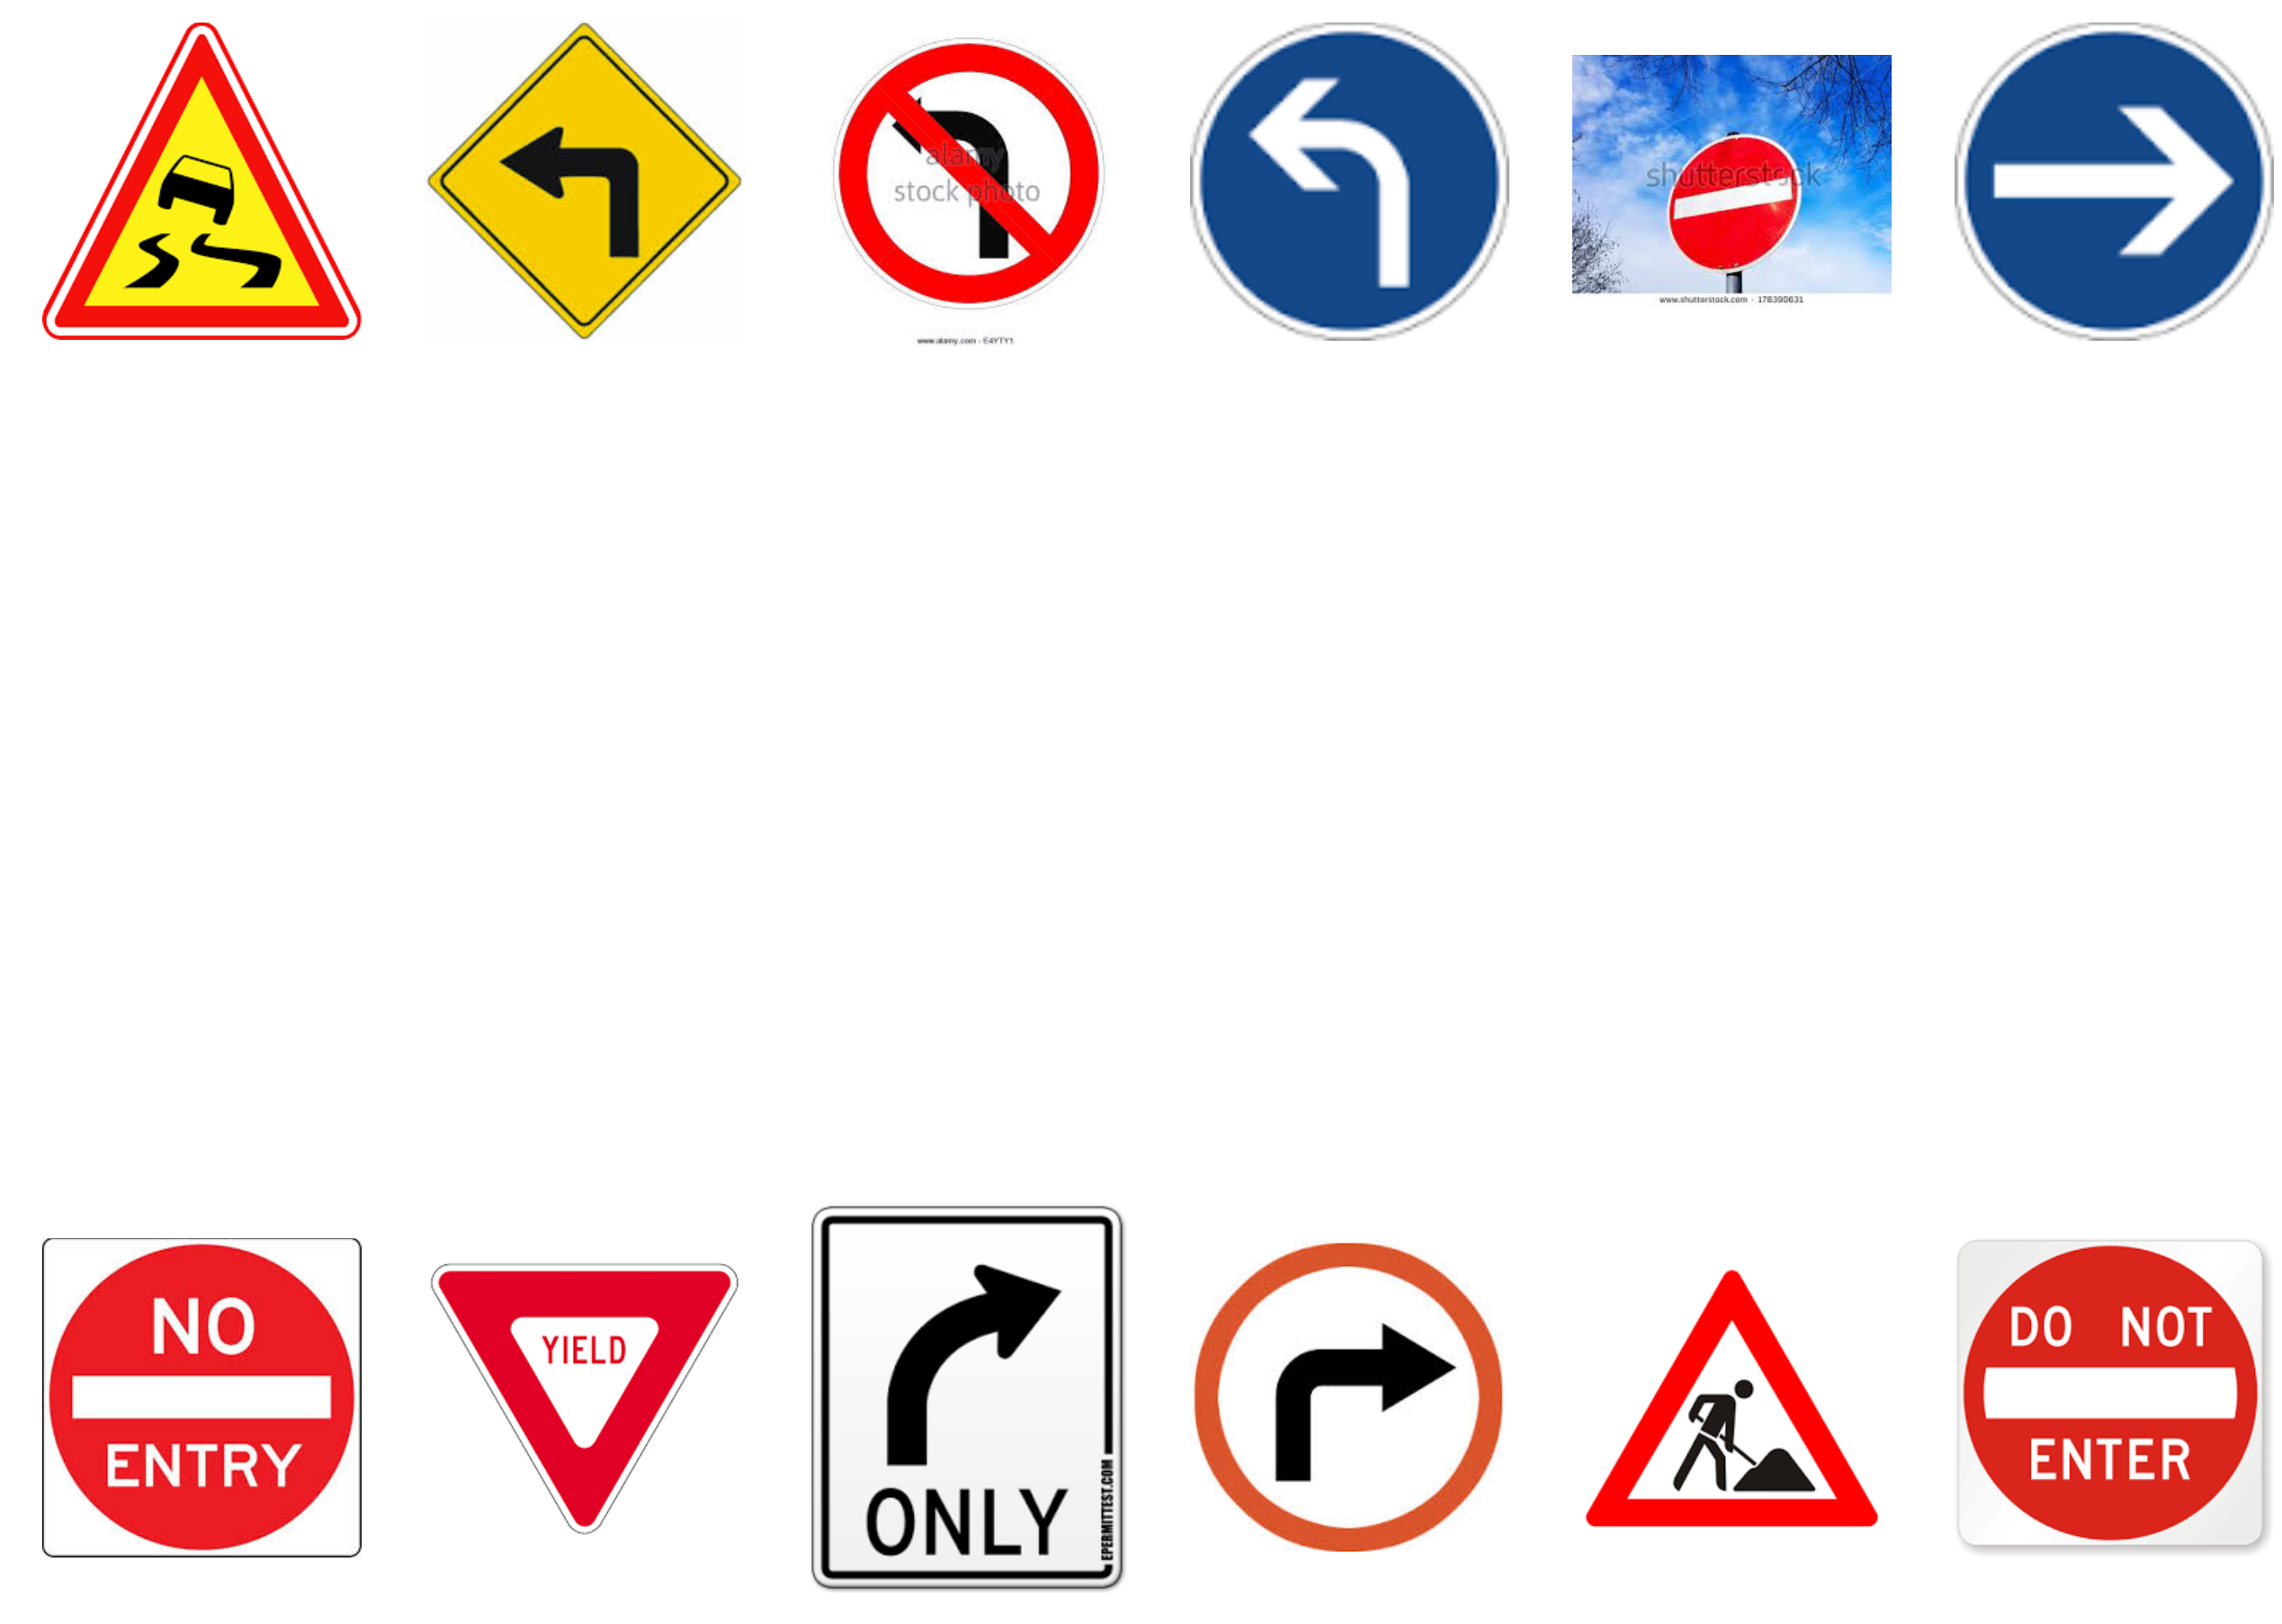

In [183]:
##Display the images
import glob
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline
testing_images = []
plt.clf()
plt.rcParams.update({'font.size': 12})
plt.figure(figsize=(32, 32))
for i, fname in zip(range(12),glob.glob("testing_images/*")):
    if fname[fname.find('.'):] == '.png':
        image = (mpimg.imread(fname)*255).astype('uint8')
    else:
        image = mpimg.imread(fname )
    testing_images.append(image)
    plt.subplot(2,6, i+1)
    plt.axis('off')
    var_holder = plt.imshow(image)
plt.show()


In [189]:
##Resize, greyscale and normalize the images
import cv2
resized_images = [cv2.resize(image, (32, 32)) for image in testing_images]
grey_scale = [cv2.cvtColor(image, cv2.COLOR_BGR2GRAY) for image in  resized_images]
normalized_images = [normalize_greyscale(image) for image in grey_scale]

### Question 6

_Choose five candidate images of traffic signs and provide them in the report. Are there any particular qualities of the image(s) that might make classification difficult? It would be helpful to plot the images in the notebook._



**Answer:**

The images were downloaded from the internet, I chose 3 'no entry' signs 2 with different wording and one with no words to see how well my model will perform on them, 2 turn left with different colors and shapes, 1 no left turn just to confuse my model, and a couple of other signs.

In [191]:
saver = tf.train.Saver()
with tf.Session() as sess:
    # Restore variables from disk.
    saver.restore(sess, "saved_models/model.ckpt")
    n_logits = logits.eval({x: normalized_images})
    

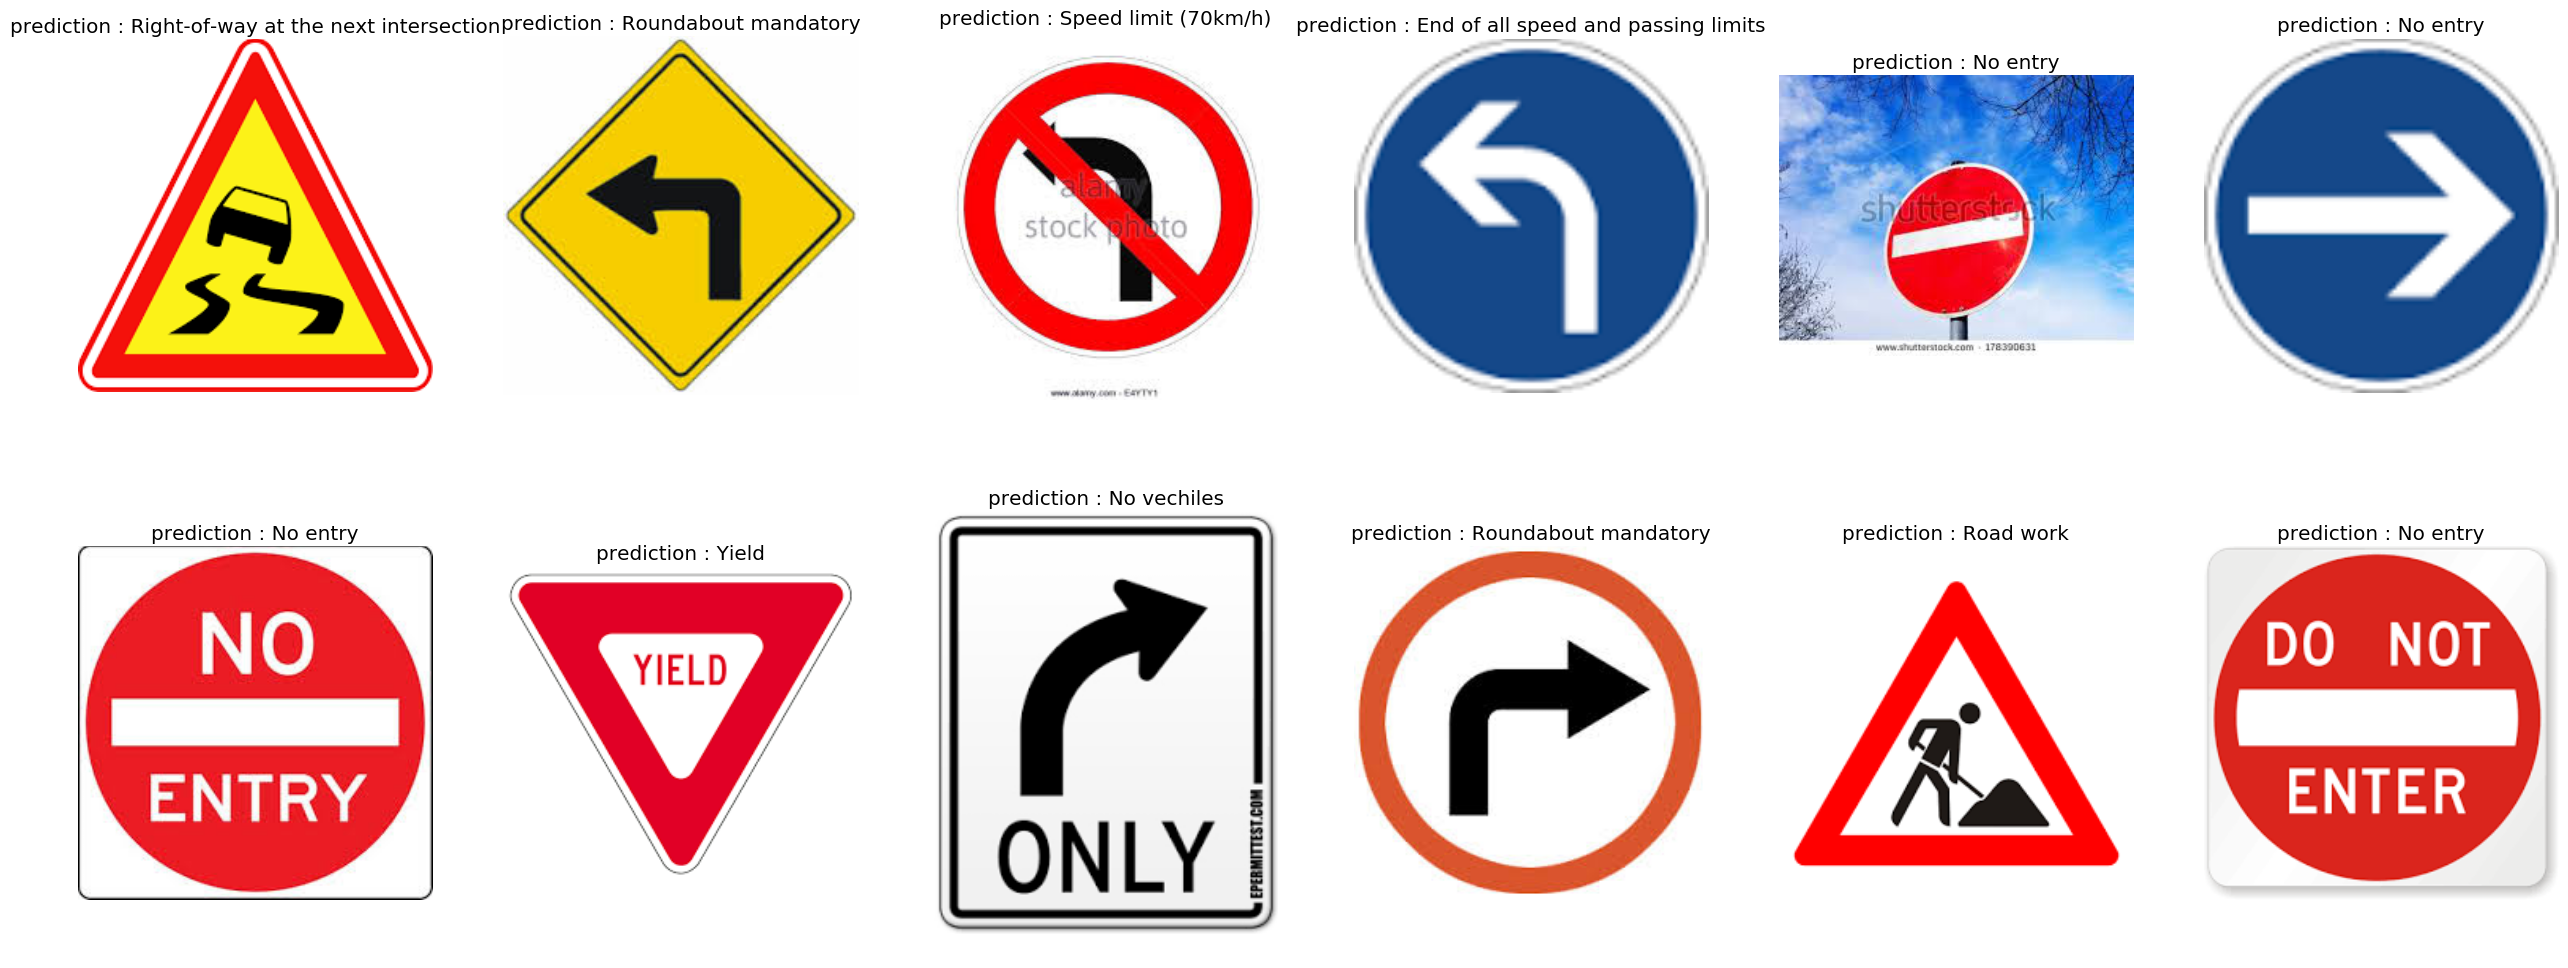

In [194]:
## get the highest predicted value and plot the predicted label on the image
import operator
labels = [sign_names[max(enumerate(logit), key=operator.itemgetter(1))[0]] for logit in n_logits]
plt.clf()
plt.rcParams.update({'font.size': 12})
plt.figure(figsize=(32,12))
i = 1
for image, label in zip(testing_images,labels):
    plt.subplot(2,6, i)
    plt.title("prediction : " + label)
    plt.axis('off')
    var_holder = plt.imshow(image)
    i+=1
plt.show()

### Question 7

_Is your model able to perform equally well on captured pictures or a live camera stream when compared to testing on the dataset?_


**Answer:**

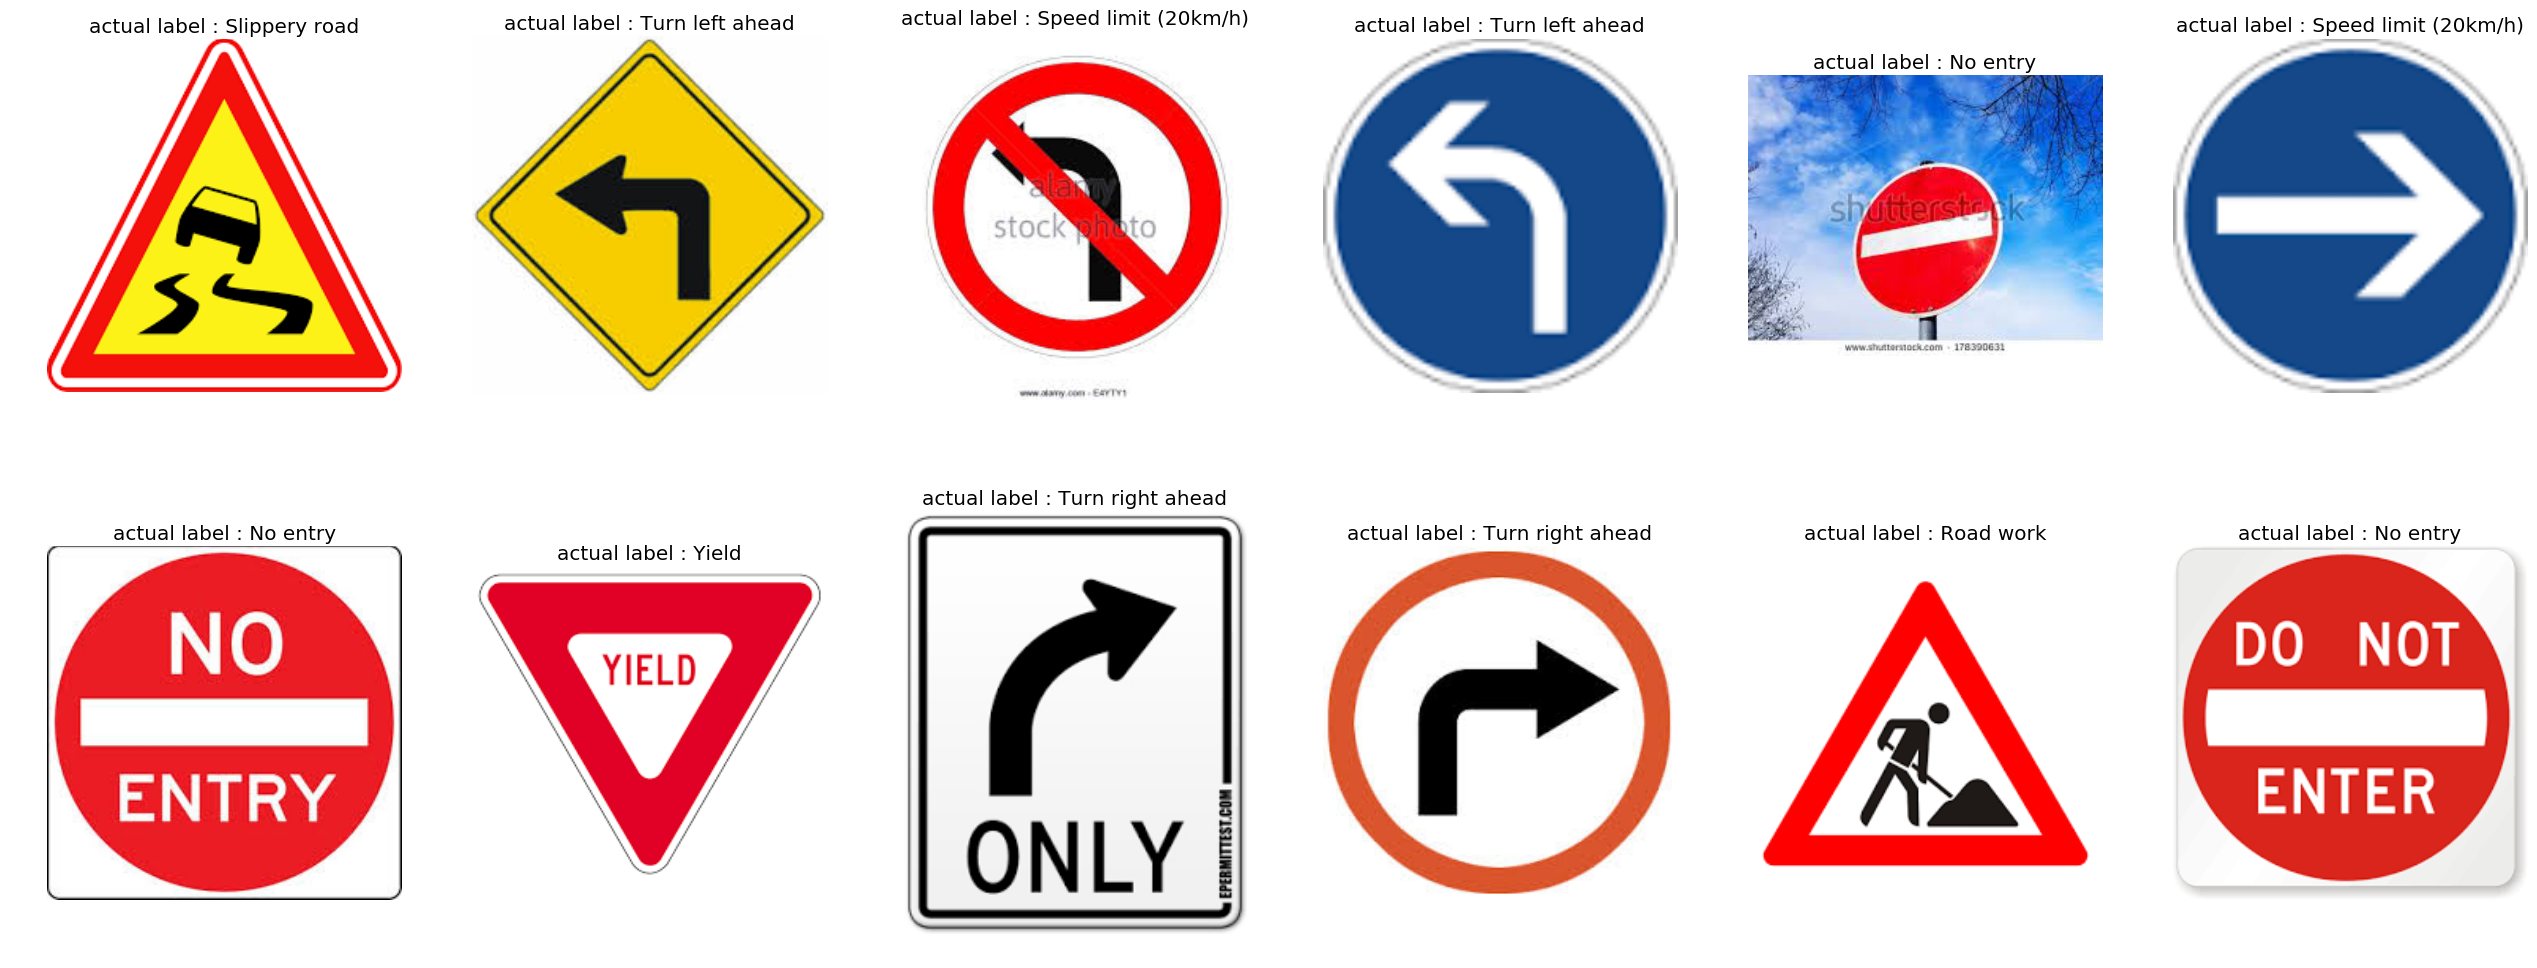

In [195]:
testing_labels= [23,34,0,34,17,0,17,13,33,33,25,17]
labels = [sign_names[lab] for lab in testing_labels]
plt.clf()
plt.rcParams.update({'font.size': 12})
plt.figure(figsize=(32,12))
i = 1
for image, label in zip(testing_images,labels):
    plt.subplot(2,6, i)
    plt.title("actual label : " + label + "\n ")
    plt.axis('off')
    var_holder = plt.imshow(image)
    i+=1
plt.show()

In [196]:
testing_labels= [23,34,0,34,17,0,17,13,33,33,25,17]
test_one_hot_labels = encoder.transform(testing_labels)
test_one_hot_labels = test_one_hot_labels.astype(np.float32)
saver = tf.train.Saver()

with tf.Session() as sess:
    # Restore variables from disk.
    saver.restore(sess, "saved_models/model.ckpt")
    test_accuracy = accuracy.eval({x: normalized_images, y: test_one_hot_labels})
    print(test_accuracy)

0.416667


### Question 8

*Use the model's softmax probabilities to visualize the **certainty** of its predictions, [`tf.nn.top_k`](https://www.tensorflow.org/versions/r0.11/api_docs/python/nn.html#top_k) could prove helpful here. Which predictions is the model certain of? Uncertain? If the model was incorrect in its initial prediction, does the correct prediction appear in the top k? (k should be 5 at most)*


In [229]:
with tf.Session() as sess:
    # Restore variables from disk.
    saver.restore(sess, "saved_models/model.ckpt")
    values = top_5_val.eval({x: normalized_images})
    indices = top_5_ind.eval({x: normalized_images})

In [233]:
for top_5,label in zip(indices,testing_labels):
    if label in top_5:
        print(list(top_5).index(label))
    else:
        print("false")

false
false
false
0
1
4
0
0
false
false
0
0


**Answer:**

### Question 9
_If necessary, provide documentation for how an interface was built for your model to load and classify newly-acquired images._


**Answer:**

I resized the images to be 32*32 and did the same preprocessing on the images as done in the training data.

> **Note**: Once you have completed all of the code implementations and successfully answered each question above, you may finalize your work by exporting the iPython Notebook as an HTML document. You can do this by using the menu above and navigating to  \n",
    "**File -> Download as -> HTML (.html)**. Include the finished document along with this notebook as your submission.